# MLB Win Expectancy Win and Probability Added, Part II

*The information used here was obtained free of charge from and is copyrighted by Retrosheet. Interested parties may contact Retrosheet at "www.retrosheet.org".*

**Summary**
- We evaluate two models for win expectancy as alternatives to the Baseball Reference methodology.
    - A stand-alone classification tree.
    - An ensemble of univariate logistic regression models.
-	The models are fit to historical data from 1920 to 2022.
-	Park factors, season factors, and win expectancies are derived from the data set and do not require simulating run scoring environments for each context.
-	Model results are compared to a small sample of estimates from Baseball Reference.
-	We apply the model to evaluate game tactics.


## 1. Introduction

Win expectancy and win probability added are statistics used to evaluate how each event in a baseball game relate to the outcome. Win expectancy (WE) is the probability, prior to the start of a recorded event, that a team will win the game. Win probability added (WPA) is the difference in WE prior to and after a recorded event. WE is useful for identifying crucial game states and informing decisions ranging from game strategy to roster construction. WPA, on the other hand, is used to evaluate player performance; good players aggregate positive WPA, and bad players aggregate negative WPA.
Calculating WE and WPA is made easier because a baseball game can be reduced to a small number of discrete events. For a regulation game there are, at most, 53 outs recorded prior to the start of an event, and there are eight possible ways the bases can be occupied totaling 432 base-out situations for which the WE is a function of the run differential. Baseball Reference describes their method for calculating WE as follows:
1.	Calculate the score differential prior to each event of record. The maximum score differential is 11 runs; any lead (by either team) is treated as a score differential of +/- 11 runs.
2.	Apply adjustments to the score differential to account for the run scoring context. The run scoring context is affected by the season and the park where the game is played. Baseball Reference estimates the season and park factors by simulating a series of run scoring environments.
3.	Calculate the *a priori* WE for each game state. Extra innings are treated as repetitions of the 9th inning. Baseball Reference offers a full description of their methodology here: https://www.baseball-reference.com/about/wpa.shtml.

The Baseball Reference procedure is essentially a Bayesian model with minor transformations to the feature set. WPA is assigned to the player or players most responsible for the result in the play. WPA is typically assigned to completely to the batter and the pitcher. Baserunners are not credited with WPA except for events where the batter makes no play: stolen bases, caught stealing, wild pitches, passed balls, etc. Fielders are not credited with WPA at all. See the link above for more details.

In addition to WE, Baseball reference offers the leverage index. Leverage acknowledges that a given event type may produce different values of WPA depending on the base-out situation and the score differential. When aggregating WPA to evaluate player performance, we must be aware that leverage can bias the results. Below average players can accrue positive WPA by succeeding in high leverage situations and good players are not awarded for “stat padding”, i.e., succeeding in low leverage situations where the contest is virtually decided. We will leave the issue of leverage to a future project and focus on producing a model for WE and WPA.


## 2. Motivation

The goal of this project is to produce a model for WE and WPA that serves as an alternative to the method described by Baseball Reference (see Section 1). Our model will not truncate the scoring differential at +/-11 runs for reasons discussed in Section 3. Furthermore, our model will not require simulations to determine park and season factors that adjust for run scoring environments.

## 3. ETL/EDA

### 3.1 Data Set
Our data set consists of more 164,000 regular-season games and twelve million events from the 1920 season through the 2022 season. The unmodified features in the data set are as follows:
- *home_team*: 3-charachter code identifying the home team.
- *vis_team*: 3-charachter code identifying the visiting team.
- *season*: integer value for the season during which the game is played.
- *park*: 5-digit alphanumeric code for the park where the game is played.
- *game_id*: 12-digit alphanumeric code that uniquely identifies the game.
- *event_id*: integer that uniquely each event in a game.
- *batting_team*: Boolean integer that indicates if the home team is batting:
    - 'f'=false
    - 't'=true
- *inning*: integer that represents the inning in which the event takes place.
- *outs*: integer that represents the number of outs prior to the event of record.
- *vis_score*: integer that represents the visiting team score prior to the event of record.
- *home_score*: integer that represents the home team score prior the event of record.
- *result_pitcher_id*: 8-digit alphanumeric code that uniquely identfies the pitcher for the event of record.
- *result_batter_hand*: 8-digit alphanumeric code that uniquely identifies the batter for the event of record.
    - 'l' = left
    - 'r' = right
- *result_pitcher_hand*: 1-digit code that indicates the throwing hand of the result pitcher id.
- **run_1b**: 8-digit alphanumeric code that uniquely identifies the runner of on first base, if any.
- *run_2b*: 8-digit alphanumeric code that uniquely identifies the runner of on second base, if any.
- *run_3b*: 8-digit alphanumeric code that uniquely identifies the runner of on third base, if any.
- *leadoff*: Boolean value indicating if the event of record is the first of the inning.
    - 'f'=false
    - 't'=true
- *pinch_hit*: Boolean value indicating if the result batter is a pinch hitter for the event of record.
    - 'f'=false
    - 't'=true
- *batt_lineup_pos*: integer representing the order in which the result batter appears in the lineup.
- *start_game*: Boolean value indicating that the event of record is the first event of the game.
    - 'f'=false
    - 't'=true
- *end_game*: Boolean value indicating that the event of record is the last event of the game.
    - 'f'=false
    - 't'=true
- *pinch_run_1b*: 8-digit alphanumeric code that uniquely identifies the pinch-runner on first base, if present.
- *pinch_run_2b*: 8-digit alphanumeric code that uniquely identifies the pinch-runner on second base, if present.
- *pinch_run_3b*: 8-digit alphanumeric code that uniquely identifies the pinch-runner on third base, if present.

The source data is from the Retrosheet event files, and the full description of the files can be found here: https://www.retrosheet.org/eventfile.htm. Note that data coverage prior to 1973 is not complete.


### 3.2 Transformations
Like Baseball Reference, we will truncate all extra-inning games to 9 innings. That is, extra innings are considered repeats of the 9th inning until a winner is determined. Rain shortened games are eliminated from the training data; they are relatively few and removing them will not materially affect the training results.

Next, we convert the *run_1b*, *run_2b*, and *run_3b* features into one hot encoded Boolean variables:
- *r_1b* where *r_1b = 1* if first base is occupied; 0 otherwise
- *r_2b* where *r_2b = 1* if first base is occupied; 0 otherwise
- *r_3b* where *r_3b = 1* if first base is occupied; 0 otherwise

The features *batting_team*, *inning*, and *outs* describe the progress of the game prior to the event of record. First convert batting team to a Boolean variable where *batting_team*=0 for the top half of an inning and *batting_team*=1 for the bottom half. Then these three features can be combined into *outs_played*, given by the formula:
$$outs played=6(inning-1)+3*batting team+outs $$

If, for example, there is 1 out in the bottom of the 4th inning, the number of outs played prior to the event of record is:

$$outs played=6(4-1)+3(1)+1=22$$

Next, we add the features *score_diff* and *home_win*. The feature *score_diff* is simply the home team score minus the visiting team score and *home_win* is a Boolean variable indicating the home team ultimately won the game.


### 3.3 Park/Season Factors
The concept of park and season factors is straightforward: the “real” value of a given score differential, and consequently, WE/WPA, is directly related to the run scoring environment in which the game is played. In a high scoring environment, runs are easier to come by and their value must be discounted. The converse is also true: low scoring environments increase the value of a run. Park and season factors are a series of constants determined from historical data and applied to the score differential that account for this problem.
Parks factors are a combination of latent features unique to each location including, but not limited to, outfield dimensions, stadium type (indoor/outdoor), altitude above sea level, etc. Likewise, season factors are influenced by changes in the rules, tactics, and strategies (among others) that evolve over time.

Here, we will calculate the factors by the following method:
1.	Group the games by park and season.
2.	Calculate the combined runs per outs played for each park and season.
3.	Divide (2) by the overall mean combined runs per outs played.

There are instances where regular season games were played at an alternate site, the 2003 Montreal Expos being a notable example having played 22 regular season games in Puerto Rico. We define a small sample as sites with less than a half-season of games (2214 outs) played, and the park factors are set to 1 for sites below this threshold.

This is a crude method for determining the factors but is sufficient for the purposes of this project. The subject of park and season factors is complex and worthy of its own detailed analysis. This is also the first departure from the procedure described by Baseball Reference. The Baseball Reference procedure relies on simulating a series of run scoring environments, determining the factor relative to an “average” result from a similar cohort, and estimating WE/WPA from the results. We want to demonstrate an alternative method that does not require this added complexity.


### 3.4 EDA

Recall that extra innings are treated as repeats of the ninth inning, so there are a maximum of 432 unique and mutually exclusive base-out scenarios in the data set. The *a priori* WE, then, is a univariate function of the run differential. We can calculate a naïve estimate for the *a priori* (home team) WE by dividing the number of home wins by the total number of games in the base-out and score-differential strata. However, since this is a classification problem, we can fit the observed outcomes to a sigmoid function which will smooth the irregularities caused by rare events that occur at the fringes of the data set.

Let us look at the plot of the *a priori* WE when there are runners on 1st and 2nd base. The win expectancy, as a function of outs played and adjusted score differential, looks like this:


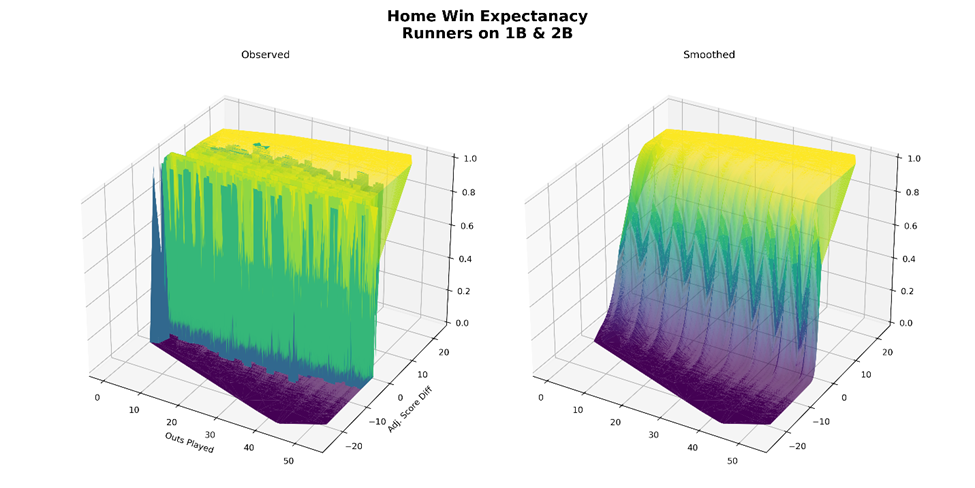

With a runner on 2nd base, we get this:

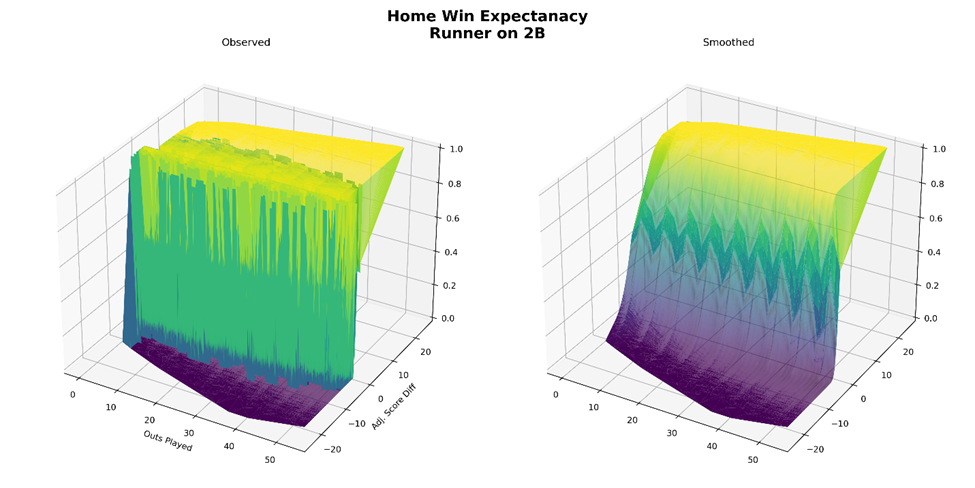

*Note that WE is not the result of a continuous function that produces a 3D surface. This was done to help visualize the results. The WE plot should be a series of unconnected lines along the outs_played axis.*

There are similar but unique plots for each of the eight possible baserunner scenarios. We conclude that a stand-alone model for WE must be nonlinear to capture this complex behavior, or we might consider an ensemble of logistic regression models over the 432 possible (and mutually exclusive) base-out combinations. The first option is more convenient but computationally expensive and less interpretable. The second option has the potential for better predictive performance and interpretability. However, fitting and invoking many models is clunky and risks overfitting if not applied carefully.


## 4. Training and Model Selection

The training and model selection are not the focus of this project, so we forego a detailed description of those processes and offer a brief description.
The training data set is more than 12.8 million events (90%) using the following features:

- *r_1b*: Boolean variable indicating a runner occupies first base.
- *r_2b*: Boolean variable indicating a runner occupies second base.
- *r_3b*: Boolean variable indicating a runner occupies third base.
- *outs_played2*: The number of outs recorded prior to the event of record. Extra innings are treated as repeats of the ninth inning, so values are between [0,54].
- *score_diff_adj*: The home team score minus the visiting team score, adjusted for park and season, prior to the event of record.

The response variable is:
-	*home_win*: Boolean variable indicating the home team won the game.

In a previous project, we surveyed a series of linear and non-linear classification methods. Stand-alone logistic regression models and naïve Bayes classifier were rejected for poor F1 scores, Matthew’s correlation coefficients, cross-validation scores, and they did not generalize well when applied to the testing and validation sets. A generalized additive model was rejected for the computational cost of fitting such a large data set.




### 4.1 Which Algorithms?

Given the non-linear nature of the problem, the two best candidates for a stand-alone model are decision trees and artificial neural networks. An ensemble of logistic regression classifiers, one for each of the 432 base-out scenarios, is also included.


### 4.2 Evaluating Performance

#### 4.2.1 Classifcation/Regression Metrics
The primary classification metric is the Matthew's correlation coefficient (MCC). The data set is almost equally divided by the positive/negative classes and the F1 score arrives at the same conclusion, so we omit it. We are more interested in the prediction probabilities, however, and not the classification results. Here we use the mean-squared error (MSE) between the predicted probabilities (from the models) versus the *a priori* home_we.



#### 4.2.2 Combined Scores

The final model should have good predictive performance and must generalize well. When we calculate the classification scores (MCC, in this case) on the testing, training, and cross-validation data, the best model will have a high score and low variance between the data sets. So, we define a combined classification score that is the mean MCC divided by the variance of the MCC. Higher values indicate better overall performance. Similarly, the MSE and variance of the MSE should be low among the three data sets, so we define a second combined score as the product of the negative log of the product of the mean MSE and the variance of the MSE. The two values of the combined scores are max-min scaled and the best model will be largest product of the two.  

### 4.3 Final Model Candidates

The final models are the logistic regression ensemble and a decision tree classifier with the following parameters:
-	*ccp_alpha*: 0.0,
-	*class_weight*: None,
-	*criterion*: gini,
-	*max_depth*: None,
-	*max_features*: None,
-	*max_leaf_nodes*: 1830,
-	*min_impurity_decrease*: 0.0,
-	*min_samples_leaf*: 1365,
-	*min_samples_split*: 2,
-	*min_weight_fraction_leaf*: 0.0,
-	*random_state*: None,
-	*splitter*: best

The *min_samples_leaf* parameter was fixed at the minimum observed number of samples in the training data over the base-out situations. The hyperparameter *max_leaf_nodes* is determined by the model with the best combined score among the model candidates.


## 5 Model Performance

Install Numpy and pickle5.

In [1]:
#!pip install numpy==1.24.3
!pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255315 sha256=88a17ba6386c3434cd1914aec065f5ece1a38ddb055a7f5ba552db67cf170e6e
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


Imports.

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt

import pickle5 as pickle

from sklearn import linear_model
from sklearn import tree
from sklearn import neural_network


Function definitions.

In [3]:
def clean_df(df):
    # clean df
    # baserunner cols
    print('Cleaning dataframe...')

    print('\tFix baserunning columns...')
    df['r_1b'] = 0
    ix = df.loc[df['run_1b'].notna()].index
    df['r_1b'].loc[ix] = 1

    df['r_2b'] = 0
    ix = df.loc[df['run_2b'].notna()].index
    df['r_2b'].loc[ix] = 1

    df['r_3b'] = 0
    ix = df.loc[df['run_3b'].notna()].index
    df['r_3b'].loc[ix] = 1

    df = df.drop(['run_1b','run_2b','run_3b'], axis=1)
    print('\tDone.')

    # fix batter/pitcher hands
    print('\tFixing batter/pitcher hands...')
    df['batt_rh'] = 0
    ix = df.loc[df['result_batter_hand']=='r'].index
    df['batt_rh'].loc[ix] = 1

    df['pitcher_rh'] = 0
    ix = df.loc[df['result_pitcher_hand']=='r'].index
    df['pitcher_rh'].loc[ix] = 1

    df = df.drop(['result_batter_hand','result_pitcher_hand'], axis=1)
    del(ix)
    print('\tDone')

    # convert t/f boolean to one hot encoding
    print('\tConvert boolean variables...')
    df = df.replace({'t':1,
                     'f':0})
    print('\tDone')

    # convert batting_team to int
    print('\tConvert batting team/runner destinations to integer data type...')
    df['batting_team'] = df['batting_team'].astype('Int64')
    df['batt_dest'] = df['batt_dest'].astype('Int64')
    df['run_1b_dest'] = df['run_1b_dest'].astype('Int64')
    df['run_2b_dest'] = df['run_2b_dest'].astype('Int64')
    df['run_3b_dest'] = df['run_3b_dest'].astype('Int64')
    print('\tDone')

    #eliminate HTBF games
    print('\tEliminate HTBF games...')
    m0 = (df['start_game']==1) & (df['batting_team']==1)
    game_ids = list(df['game_id'].loc[m0])
    ix = df.loc[df['game_id'].isin(game_ids)].index
    df = df.drop(ix, axis=0)
    print('\tDone')

    #eliminate shortened games
    print('\tEliminate shortened games...')
    m0 = (df['end_game']==1) & (df['inning']<9)
    drop_games_list = df['game_id'].loc[m0]
    df = df.loc[~df['game_id'].isin(drop_games_list)]
    print('\tDone')

    # add score diff col (home_score - vis_score)
    print('\tAdd score differential column...')
    df['score_diff'] = df['home_score'] - df['vis_score']
    print('\tDone')

    # truncate extra innings games
    df['inning2'] = df['inning']
    df['inning2'].loc[df['inning2']>=9] = 9

    del(m0, game_ids)

    # create outs_played as alternate to inning-base-out situations
    print('\tCreate outs-played column...')
    df['outs_played'] = 6*(df['inning']-1) + 3*df['batting_team'] + df['outs']
    df['outs_played2'] = 6*(df['inning2']-1) + 3*df['batting_team'] + df['outs']
    print('\tDone')
    # fix batter lineup position dtype
    print('\tFix lineup position data type...')
    df['batt_lineup_pos'] = df['batt_lineup_pos'].astype('Int64')
    print('\tdone')

    ## get final scores
    print('\tCalculating final scores')
    m0 = df['end_game']==1
    m1 = (df['batt_dest']<4) & (df['run_1b_dest']<4) & (df['run_2b_dest']<4) & (df['run_3b_dest']<4)

    df_temp1 = df[['game_id','vis_score','home_score']].loc[m0&m1]
    df_temp1 = df_temp1.rename({'vis_score':'vis_final_score',
                                'home_score':'home_final_score'},
                               axis=1)

    # deal with scoring in final ab
    df_temp2 = df.loc[m0&~m1]
    df_temp2['vis_final_score'] = df_temp2['vis_score']
    df_temp2['home_final_score'] = df_temp2['home_score']

    # home team final at-bat
    m2 = (df_temp2['batt_dest']>=4) & (df_temp2['batting_team']==1)
    df_temp2['home_final_score'].loc[m2] = df_temp2['home_final_score'].loc[m2] + 1

    m2 = (df_temp2['run_1b_dest']>=4) & (df_temp2['batting_team']==1)
    df_temp2['home_final_score'].loc[m2] = df_temp2['home_final_score'].loc[m2] + 1

    m2 = (df_temp2['run_2b_dest']>=4) & (df_temp2['batting_team']==1)
    df_temp2['home_final_score'].loc[m2] = df_temp2['home_final_score'].loc[m2] + 1

    m2 = (df_temp2['run_3b_dest']>=4) & (df_temp2['batting_team']==1)
    df_temp2['home_final_score'].loc[m2] = df_temp2['home_final_score'].loc[m2] + 1

    #vis team final at-bat
    m2 = (df_temp2['batt_dest']>=4) & (df_temp2['batting_team']==0)
    df_temp2['vis_final_score'].loc[m2] = df_temp2['vis_final_score'].loc[m2] + 1

    m2 = (df_temp2['run_1b_dest']>=4) & (df_temp2['batting_team']==0)
    df_temp2['vis_final_score'].loc[m2] = df_temp2['vis_final_score'].loc[m2] + 1

    m2 = (df_temp2['run_2b_dest']>=4) & (df_temp2['batting_team']==0)
    df_temp2['vis_final_score'].loc[m2] = df_temp2['vis_final_score'].loc[m2] + 1

    m2 = (df_temp2['run_3b_dest']>=4) & (df_temp2['batting_team']==0)
    df_temp2['vis_final_score'].loc[m2] = df_temp2['vis_final_score'].loc[m2] + 1

    #trim columns
    df_temp2 = df_temp2[['game_id','vis_final_score','home_final_score']]
    # concat temp dataframes and merge with df
    df_temp = pd.concat([df_temp1, df_temp2])
    del(df_temp1, df_temp2)

    df = df.merge(df_temp,
                        how='left',
                        left_on=['game_id'],
                        right_on=['game_id'])

    del(df_temp)
    del(m0,m1,m2)
    print('\tDone')

    ## add home-team win column
    print('\tAdding home win column...')
    m0 = df['home_final_score']>df['vis_final_score']
    df['home_win'] = 0
    df['home_win'].loc[m0] = 1
    del(m0)
    print('\tDone')

    print('Dataframe cleaned.')
    return(df)

Get files.

In [4]:
# make temp folder
!mkdir /content/temp_folder
# get files from github

# slice of events file
!wget -P /content/temp_folder https://github.com/cmtoner/retrosheets_we_wpa/raw/main/event_slice.zip
!unzip /content/temp_folder/event_slice.zip -d /content/temp_folder
# final model dictionary and park/season factors
!wget -P /content/temp_folder https://github.com/cmtoner/retrosheets_we_wpa/raw/main/final_mod_dict.pkl
!wget -P /content/temp_folder https://github.com/cmtoner/retrosheets_we_wpa/raw/main/park_season_factors.csv
# get Baseball Reference exemplars
!wget -P /content/temp_folder https://github.com/cmtoner/retrosheets_we_wpa/raw/main/bbref_we_examplar01.csv
!wget -P /content/temp_folder https://github.com/cmtoner/retrosheets_we_wpa/raw/main/bbref_wpa_2010_exemplar01.csv

--2024-03-18 15:48:48--  https://github.com/cmtoner/retrosheets_we_wpa/raw/main/event_slice.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cmtoner/retrosheets_we_wpa/main/event_slice.zip [following]
--2024-03-18 15:48:49--  https://raw.githubusercontent.com/cmtoner/retrosheets_we_wpa/main/event_slice.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6009433 (5.7M) [application/zip]
Saving to: ‘/content/temp_folder/event_slice.zip’

event_slice.zip     100%[===================>]   5.73M  22.0MB/s    in 0.3s    

2024-03-18 15:48:50 (22.0 MB/s) - ‘/content/temp_folder/event_slice.zip’ sav

Load model dictionary, event slice, and park/season factors

In [5]:
# load final models candidates
final_mod_dict = pickle.load(open('/content/temp_folder/final_mod_dict.pkl','rb'))

# load event slice
df_slice = pd.read_csv('/content/temp_folder/event_slice.csv',
                       header=0,
                       index_col=False)
# clean df_slice
df_slice = clean_df(df_slice)

# load park/season factors
df_factors = pd.read_csv('/content/temp_folder/park_season_factors.csv',
                         header=0,
                         index_col=False)

<ipython-input-5-8f6dbc0fffc1>:5: DtypeWarning: Columns (59,68,69,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df_slice = pd.read_csv('/content/temp_folder/event_slice.csv',


Cleaning dataframe...
	Fix baserunning columns...
	Done.
	Fixing batter/pitcher hands...
	Done
	Convert boolean variables...
	Done
	Convert batting team/runner destinations to integer data type...
	Done
	Eliminate HTBF games...
	Done
	Eliminate shortened games...
	Done
	Add score differential column...
	Done
	Create outs-played column...
	Done
	Fix lineup position data type...
	done
	Calculating final scores
	Done
	Adding home win column...
	Done
Dataframe cleaned.


Merge park/season factors and events slice.

In [6]:
df_slice = df_slice.merge(df_factors[['park','season','factor']],
                          how='left',
                          left_on=['park','season'],
                          right_on=['park','season'])

del(df_factors)

df_slice['score_diff_adj'] = df_slice['score_diff']*df_slice['factor']

Add model predictions and calculate WPA.

In [7]:
# add predictions
xcols = ['r_1b', 'r_2b', 'r_3b', 'outs_played2','score_diff_adj']
ycol = ['home_win']

#add decision tree classifier (dt_clf) predictions
df_slice['yhat_dt_clf'] = final_mod_dict['dt_clf'].predict_proba(df_slice[xcols])[:,1]

# add logistic regression classifier (lr_ens) predictions
df_slice['yhat_lr_ens'] = None
count = 1
for i in [0,1]:
    for j in [0,1]:
        for k in [0,1]:
            for l in range(54):
                #print(f'Fitting {count} of 432')
                count += 1
                m0 = (df_slice['r_1b']==i)&(df_slice['r_2b']==j)&(df_slice['r_3b']==k)&(df_slice['outs_played2']==l)
                df_slice['yhat_lr_ens'].loc[m0] = final_mod_dict['lr_ens'][(i,j,k,l)].predict_proba(np.array(df_slice['score_diff_adj'].loc[m0]).reshape(-1, 1))[:,1]

del(i,j,k,l,m0,xcols,ycol,count)

# calc WPA
# dt_clf
# home team wpa
df_slice['wpa_dt_clf'] = df_slice['yhat_dt_clf'].shift(-1) - np.array(df_slice['yhat_dt_clf'])
# fix end of game entries
m0 =df_slice['end_game']==1
df_slice['wpa_dt_clf'].loc[m0] =df_slice['home_win'].loc[m0] -df_slice['yhat_dt_clf'].loc[m0]
# flip sign for vis_team plate appearance
m0 =df_slice['batting_team']==0
df_slice['wpa_dt_clf'].loc[m0] = -1*df_slice['wpa_dt_clf'].loc[m0]

# lr_ens
# home team wpa
df_slice['wpa_lr_ens'] = df_slice['yhat_lr_ens'].shift(-1) - np.array(df_slice['yhat_lr_ens'])
# fix end of game entries
m0 =df_slice['end_game']==1
df_slice['wpa_lr_ens'].loc[m0] =df_slice['home_win'].loc[m0] -df_slice['yhat_lr_ens'].loc[m0]
# flip sign for vis_team plate appearance
m0 =df_slice['batting_team']==0
df_slice['wpa_lr_ens'].loc[m0] = -1*df_slice['wpa_lr_ens'].loc[m0]

# fix data types
for col in ['yhat_dt_clf', 'yhat_lr_ens','wpa_dt_clf', 'wpa_lr_ens']:
   df_slice[col] =df_slice[col].astype(float)

del(col,m0)

Inspect df_slice.

In [8]:
df_slice.head(25)

home_team vis_team  season   park       game_id  event_id  batting_team  \
0        ANA      MIN    2010  ANA01  ANA201004050         1             0   
1        ANA      MIN    2010  ANA01  ANA201004050         2             0   
2        ANA      MIN    2010  ANA01  ANA201004050         3             0   
3        ANA      MIN    2010  ANA01  ANA201004050         4             1   
4        ANA      MIN    2010  ANA01  ANA201004050         5             1   
5        ANA      MIN    2010  ANA01  ANA201004050         6             1   
6        ANA      MIN    2010  ANA01  ANA201004050         7             1   
7        ANA      MIN    2010  ANA01  ANA201004050         8             1   
8        ANA      MIN    2010  ANA01  ANA201004050         9             1   
9        ANA      MIN    2010  ANA01  ANA201004050        10             1   
10       ANA      MIN    2010  ANA01  ANA201004050        11             1   
11       ANA      MIN    2010  ANA01  ANA201004050        12             0   
12       ANA      MIN    2010  ANA01  ANA201004050        13             0   
13       ANA      MIN    2010  ANA01  ANA201004050        14             0   
14       ANA      MIN    2010  ANA01  ANA201004050        15             0   
15       ANA      MIN    2010  ANA01  ANA201004050        16             0   
16       ANA      MIN    2010  ANA01  ANA201004050        17             1   
17       ANA      MIN    2010  ANA01  ANA201004050        18             1   
18       ANA      MIN    2010  ANA01  ANA201004050        19             1   
19       ANA      MIN    2010  ANA01  ANA201004050        20             1   
20       ANA      MIN    2010  ANA01  ANA201004050        21             0   
21       ANA      MIN    2010  ANA01  ANA201004050        22             0   
22       ANA      MIN    2010  ANA01  ANA201004050        23             0   
23       ANA      MIN    2010  ANA01  ANA201004050        24             0   
24       ANA      MIN    2010  ANA01  ANA201004050        25             1   

    inning  outs  balls  ...  outs_played2 vis_final_score  home_final_score  \
0        1     0      2  ...             0               3                 6   
1        1     1      0  ...             1               3                 6   
2        1     2      1  ...             2               3                 6   
3        1     0      3  ...             3               3                 6   
4        1     0      0  ...             3               3                 6   
5        1     1      0  ...             4               3                 6   
6        1     1      3  ...             4               3                 6   
7        1     1      0  ...             4               3                 6   
8        1     2      1  ...             5               3                 6   
9        1     2      2  ...             5               3                 6   
10       1     2      3  ...             5               3                 6   
11       2     0      3  ...             6               3                 6   
12       2     0      1  ...             6               3                 6   
13       2     1      3  ...             7               3                 6   
14       2     2      1  ...             8               3                 6   
15       2     2      0  ...             8               3                 6   
16       2     0      1  ...             9               3                 6   
17       2     1      0  ...            10               3                 6   
18       2     1      2  ...            10               3                 6   
19       2     2      1  ...            11               3                 6   
20       3     0      1  ...            12               3                 6   
21       3     1      2  ...            13               3                 6   
22       3     2      1  ...            14               3                 6   
23       3     2      1  ...            14            

Load first Baseball Reference exemplar.

In [9]:
# load exemplar 1
df_ex01 = pd.read_csv("/content/temp_folder/bbref_we_examplar01.csv",
                      header=0,
                      index_col=False)

#add predicted we/wpa
cols = ['game_id','event_id','yhat_dt_clf','yhat_lr_ens','wpa_dt_clf','wpa_lr_ens']
df_ex01 = df_ex01.merge(df_slice[cols],
                        how='left',
                        left_on=['game_id','event_id'],
                        right_on=['game_id','event_id'])

del(cols)

In [10]:
df_ex01

game_id  event_id  home_win_prob  yhat_dt_clf  yhat_lr_ens  \
0    PHI200407060         1           0.50     0.539747     0.539731   
1    PHI200407060         2           0.52     0.564606     0.564402   
2    PHI200407060         3           0.54     0.581931     0.581757   
3    PHI200407060         4           0.53     0.569335     0.568679   
4    PHI200407060         5           0.55     0.592484     0.592800   
..            ...       ...            ...          ...          ...   
709  SDN202208022        69           0.50     0.515204     0.515276   
710  SDN202208022        70           0.56     0.573090     0.583704   
711  SDN202208022        71           0.60     0.616352     0.637324   
712  SDN202208022        72           0.63     0.647801     0.618876   
713  SDN202208022        73           0.57     0.591885     0.573265   

     wpa_dt_clf  wpa_lr_ens  
0     -0.024859   -0.024670  
1     -0.017325   -0.017355  
2      0.012596    0.013079  
3     -0.023148   -0.024121  
4     -0.026447   -0.025804  
..          ...         ...  
709   -0.057886   -0.068428  
710   -0.043262   -0.053620  
711   -0.031449    0.018448  
712   -0.055916   -0.045612  
713    0.408115    0.426735  

[714 rows x 7 columns]

### 5.1 WE vs BBREF Exemplar 1

Now compare the model results to a selection of games with the Baseball Reference WE.

Plot predicted win exepectancies against Baseball Reference exemplar.

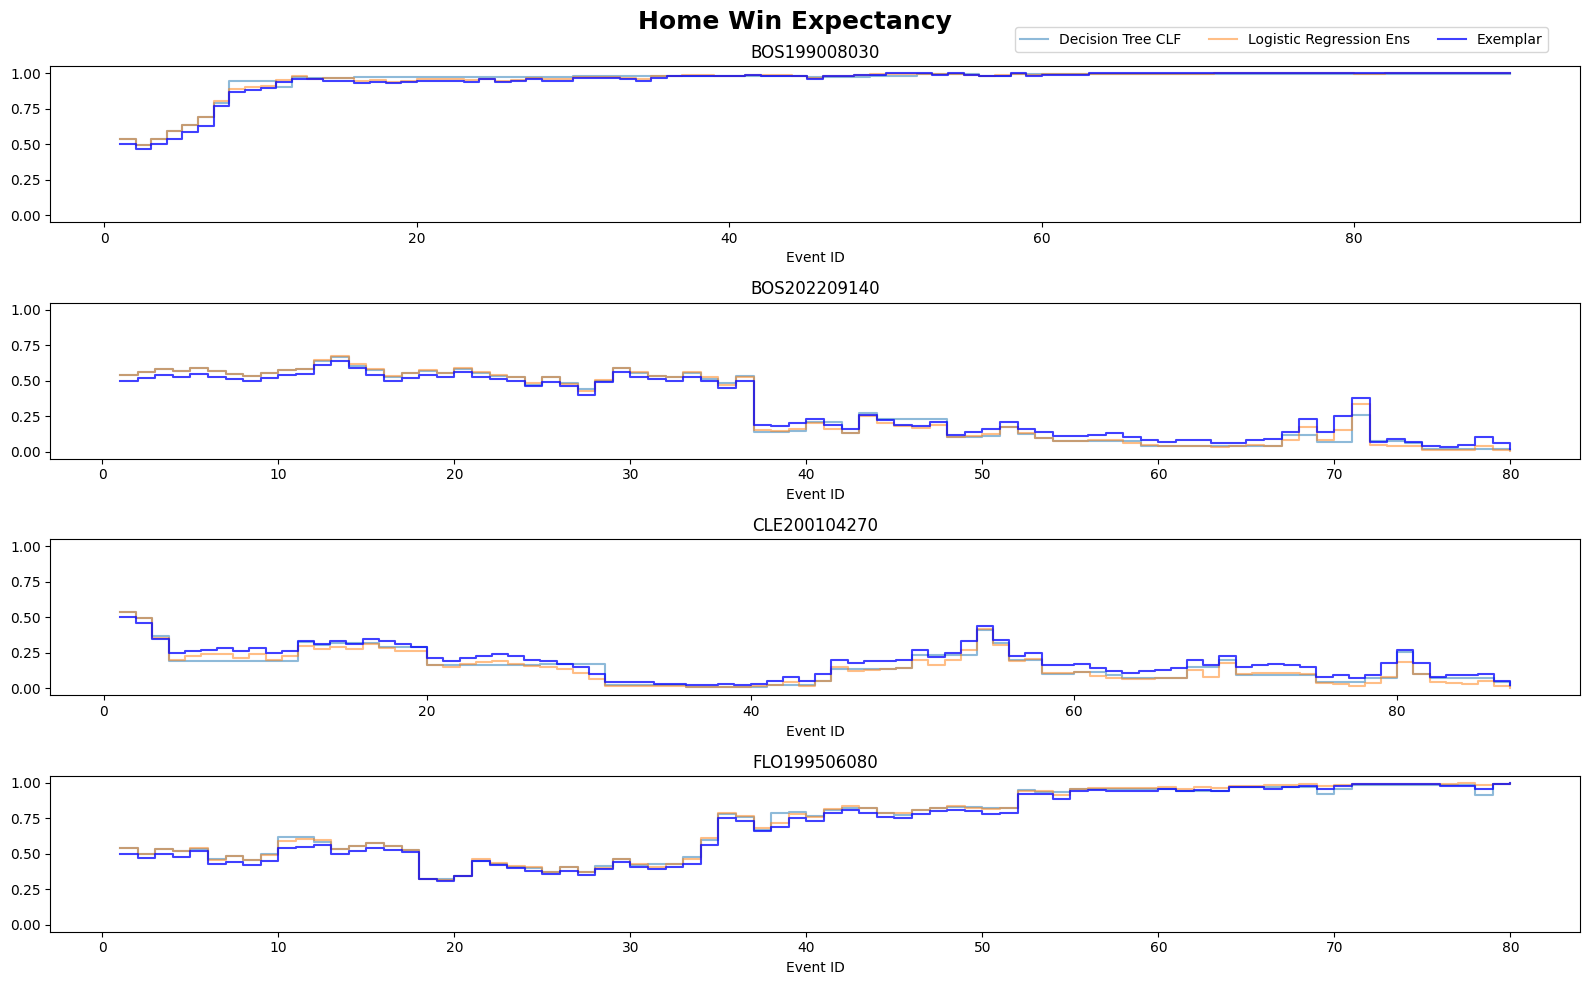

In [11]:
#%%plot home win expectancies for the BBREF exemplar
game_ids = ['BOS199008030','BOS202209140','CLE200104270','FLO199506080']

fig = plt.figure(figsize=(16,10),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(4,1,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_xlabel('Event ID')
    x = df_ex01['event_id'].loc[df_ex01['game_id']==game_id]
    # plot predictions
    for col in ['yhat_dt_clf', 'yhat_lr_ens']:
        y = df_ex01[col].loc[df_ex01['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
        ax[i].set_ylim([-0.05,1.05])
    # add exemplar
    ax[i].step(x,df_ex01['home_win_prob'].loc[df_ex01['game_id']==game_id],
             where='post',
             alpha=0.75,
             c='blue')

leg_list = ['Decision Tree CLF','Logistic Regression Ens','Exemplar']
fig.legend(leg_list,
           ncols=3,
           bbox_to_anchor=(0.975,0.970))

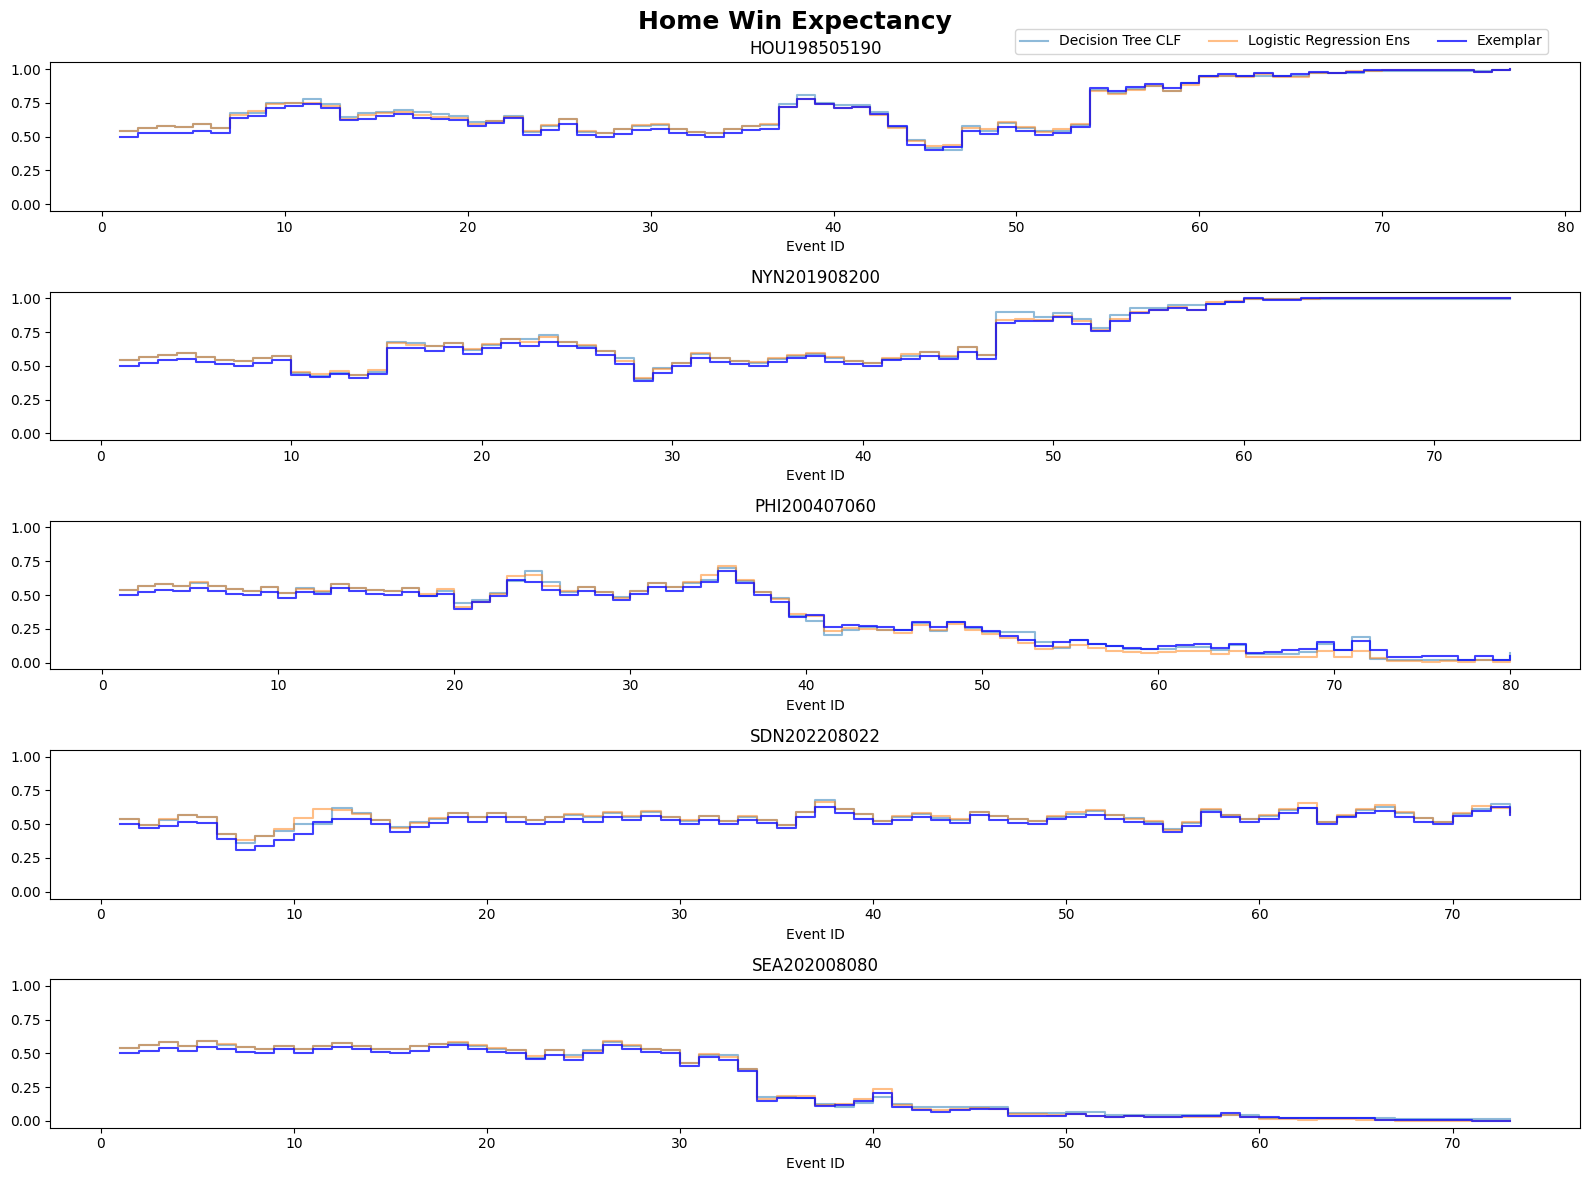

In [12]:
game_ids = ['HOU198505190','NYN201908200','PHI200407060','SDN202208022','SEA202008080']

fig = plt.figure(figsize=(16,12),
                 tight_layout=True)
fig.suptitle('Home Win Expectancy', fontweight='bold', fontsize=18)

ax = []
for i,game_id in enumerate(game_ids):
    ax.append(plt.subplot(5,1,i+1))
    ax[i].set_title(f'{game_id}')
    ax[i].set_xlabel('Event ID')
    x = df_ex01['event_id'].loc[df_ex01['game_id']==game_id]
    # plot predictions
    for col in ['yhat_dt_clf', 'yhat_lr_ens']:
        y = df_ex01[col].loc[df_ex01['game_id']==game_id]
        ax[i].step(x,y,where='post',alpha=0.5)
        ax[i].set_ylim([-0.05,1.05])
    # add exemplar
    ax[i].step(x,df_ex01['home_win_prob'].loc[df_ex01['game_id']==game_id],
             where='post',
             alpha=0.75,
             c='blue')

leg_list = ['Decision Tree CLF','Logistic Regression Ens','Exemplar']
fig.legend(leg_list,
           ncols=3,
           bbox_to_anchor=(0.975,0.970))

del(ax,fig, game_id, game_ids, i, leg_list, x,y)

Visual inspection reveals the results are close with the ensemble classifier performing slightly better with respect to the exemplar. Note that the Baseball Reference WE does not account for home field advantage: both teams start the game with a 0.50 probability of a win. Recall that Baseball Reference describes a method for calculating the WE for average home/visiting teams. This and the fact that Baseball Reference offers WE to 2 decimal places are likely the sources of deviation, at least in the early innings.

### 5.2 WPA vs BBREF Exemplar 2

Load the second Baseball Reference exemplar. This is the aggregated WPA for the top 500 players during the 2010 season.

In [13]:
#%% load BBREF exemplar 2

# load exemplar 2
df_ex02 = pd.read_csv("/content/temp_folder/bbref_wpa_2010_exemplar01.csv",
                      header=0,
                      index_col=False)

In [14]:
df_ex02

Rk            Name        id   Tm  WPA
0      1  Miguel Cabrera  cabrm001  DET  7.5
1      2      Joey Votto  vottj001  CIN  6.9
2      3   Josh Hamilton  hamij003  TEX  6.2
3      4   Albert Pujols  pujoa001  STL  5.3
4      5   Jason Heyward  heywj001  ATL  4.8
..   ...             ...       ...  ...  ...
494  495    Jordan Smith  smitj003  CIN -0.1
495  496     Brad Snyder  snydb002  CHC -0.1
496  497   Huston Street  streh001  COL -0.1
497  498   Cory Sullivan  sullc001  HOU -0.1
498  499    Mitch Talbot  talbm001  CLE -0.1

[499 rows x 5 columns]

Now aggregate the predicted WPA over the same season. We begin with a naive assumption that all credit goes to the batter.

In [15]:
# Naive aggregation: all credit goes to batter
# aggregate predicted values from df_clf
m0 = df_slice['season']==2010
temp = df_slice[['result_batter_id','wpa_dt_clf']].loc[m0].groupby(['result_batter_id']).sum()

#add predicted we/wpa
df_grp0 = df_ex02.merge(temp,
                        how='left',
                        left_on=['id'],
                        right_index=True)

# aggregate predicted values from lr_ens
m0 = df_slice['season']==2010
temp = df_slice[['result_batter_id','wpa_lr_ens']].loc[m0].groupby(['result_batter_id']).sum()

#add predicted we/wpa
df_grp0 = df_grp0.merge(temp,
                        how='left',
                        left_on=['id'],
                        right_index=True)

del(temp)
del(m0)

In [16]:
df_grp0.sort_values(by='wpa_lr_ens', ascending=False)

Rk               Name        id   Tm  WPA  wpa_dt_clf  wpa_lr_ens
0      1     Miguel Cabrera  cabrm001  DET  7.5    8.591352    7.809964
1      2         Joey Votto  vottj001  CIN  6.9    5.637329    6.617475
2      3      Josh Hamilton  hamij003  TEX  6.2    5.661780    6.356752
14    15       Paul Konerko  konep001  CHW  3.7    4.478996    4.589043
8      9     JosÃ© Bautista  bautj002  TOR  4.1    4.518714    4.332010
..   ...                ...       ...  ...  ...         ...         ...
436  437         Dillon Gee   geed001  NYM -0.1         NaN         NaN
438  439       Gio Gonzalez  gonzg001  OAK -0.1         NaN         NaN
443  444  Roberto Hernandez  hernr001  CLE -0.1         NaN         NaN
456  457        Kameron Loe   loek001  MIL -0.1         NaN         NaN
481  482        JosÃ© Reyes  reyej002  NYM -0.1         NaN         NaN

[499 rows x 7 columns]

Now aggregate WPA using the Baseball Reference methodology. In most cases, all credit goes to the batter. However, for baserunning events, the credit is assigned to the lead runner.

In [17]:
# use bbref method for assigning responsibility to an offensive player
# most situations, off player responsible is the batter
df_slice['resp_off_pid01'] = df_slice['result_batter_id']
# assign baserunning events to (lead) runner
br_events = ['balk',
             'caught stealing',
             'defensive indifference',
             'other advance',
             'passed ball',
             'pickoff',
             'stolen base',
             'wild pitch']
m0 = df_slice['event_type'].isin(br_events)
m0 = m0 & df_slice['batter_event']==0
m0 = m0 & (df_slice['sb_run_1b']==1)
m0 = m0 & (df_slice['sb_run_2b']==0)
m0 = m0 & (df_slice['sb_run_3b']==0)
df_slice['resp_off_pid01'].loc[m0] = df_slice['r_1b'].loc[m0]

m0 = df_slice['event_type'].isin(br_events)
m0 = m0 & df_slice['batter_event']==0
m0 = m0 & (df_slice['sb_run_2b']==1)
m0 = m0 & (df_slice['sb_run_3b']==0)
df_slice['resp_off_pid01'].loc[m0] = df_slice['r_2b'].loc[m0]

m0 = df_slice['event_type'].isin(br_events)
m0 = m0 & df_slice['batter_event']==0
m0 = m0 & (df_slice['sb_run_3b']==1)
df_slice['resp_off_pid01'].loc[m0] = df_slice['r_3b'].loc[m0]

del(m0, br_events)

# aggregate predicted values from df_clf
m0 = df_slice['season']==2010
temp = df_slice[['resp_off_pid01','wpa_dt_clf']].loc[m0].groupby(['resp_off_pid01']).sum()

#add predicted we/wpa
df_grp1 = df_ex02.merge(temp,
                        how='left',
                        left_on=['id'],
                        right_index=True)

# aggregate predicted values from lr_ens
m0 = df_slice['season']==2010
temp = df_slice[['resp_off_pid01','wpa_lr_ens']].loc[m0].groupby(['resp_off_pid01']).sum()

#add predicted we/wpa
df_grp1 = df_grp1.merge(temp,
                        how='left',
                        left_on=['id'],
                        right_index=True)

del(temp)
del(m0)

In [18]:
df_grp1.sort_values(by='wpa_lr_ens', ascending=False)

Rk               Name        id   Tm  WPA  wpa_dt_clf  wpa_lr_ens
0      1     Miguel Cabrera  cabrm001  DET  7.5    8.449316    7.782323
1      2         Joey Votto  vottj001  CIN  6.9    5.386516    6.368897
2      3      Josh Hamilton  hamij003  TEX  6.2    5.706315    6.294459
10    11       Delmon Young  yound003  MIN  4.1    5.176966    4.268264
8      9     JosÃ© Bautista  bautj002  TOR  4.1    4.438760    4.224192
..   ...                ...       ...  ...  ...         ...         ...
436  437         Dillon Gee   geed001  NYM -0.1         NaN         NaN
438  439       Gio Gonzalez  gonzg001  OAK -0.1         NaN         NaN
443  444  Roberto Hernandez  hernr001  CLE -0.1         NaN         NaN
456  457        Kameron Loe   loek001  MIL -0.1         NaN         NaN
481  482        JosÃ© Reyes  reyej002  NYM -0.1         NaN         NaN

[499 rows x 7 columns]

### 5.3 Distribution of WPA by Event Type

Here, we examine the distribution of WPA by event types and compare the model results to the *a priori* win expectancy. Recall that *home_we* was estimated by fitting a sigmoid curve to the observed home team wins (as opposed to fitting a model). From this, we calculate the *a priori* WPA and compare the results to the predicted WPA of our models. Note that the data used to produce these plots covers the entire period from 1920 to 2022, so we will omit the code and focus on the results.

Start with singles:

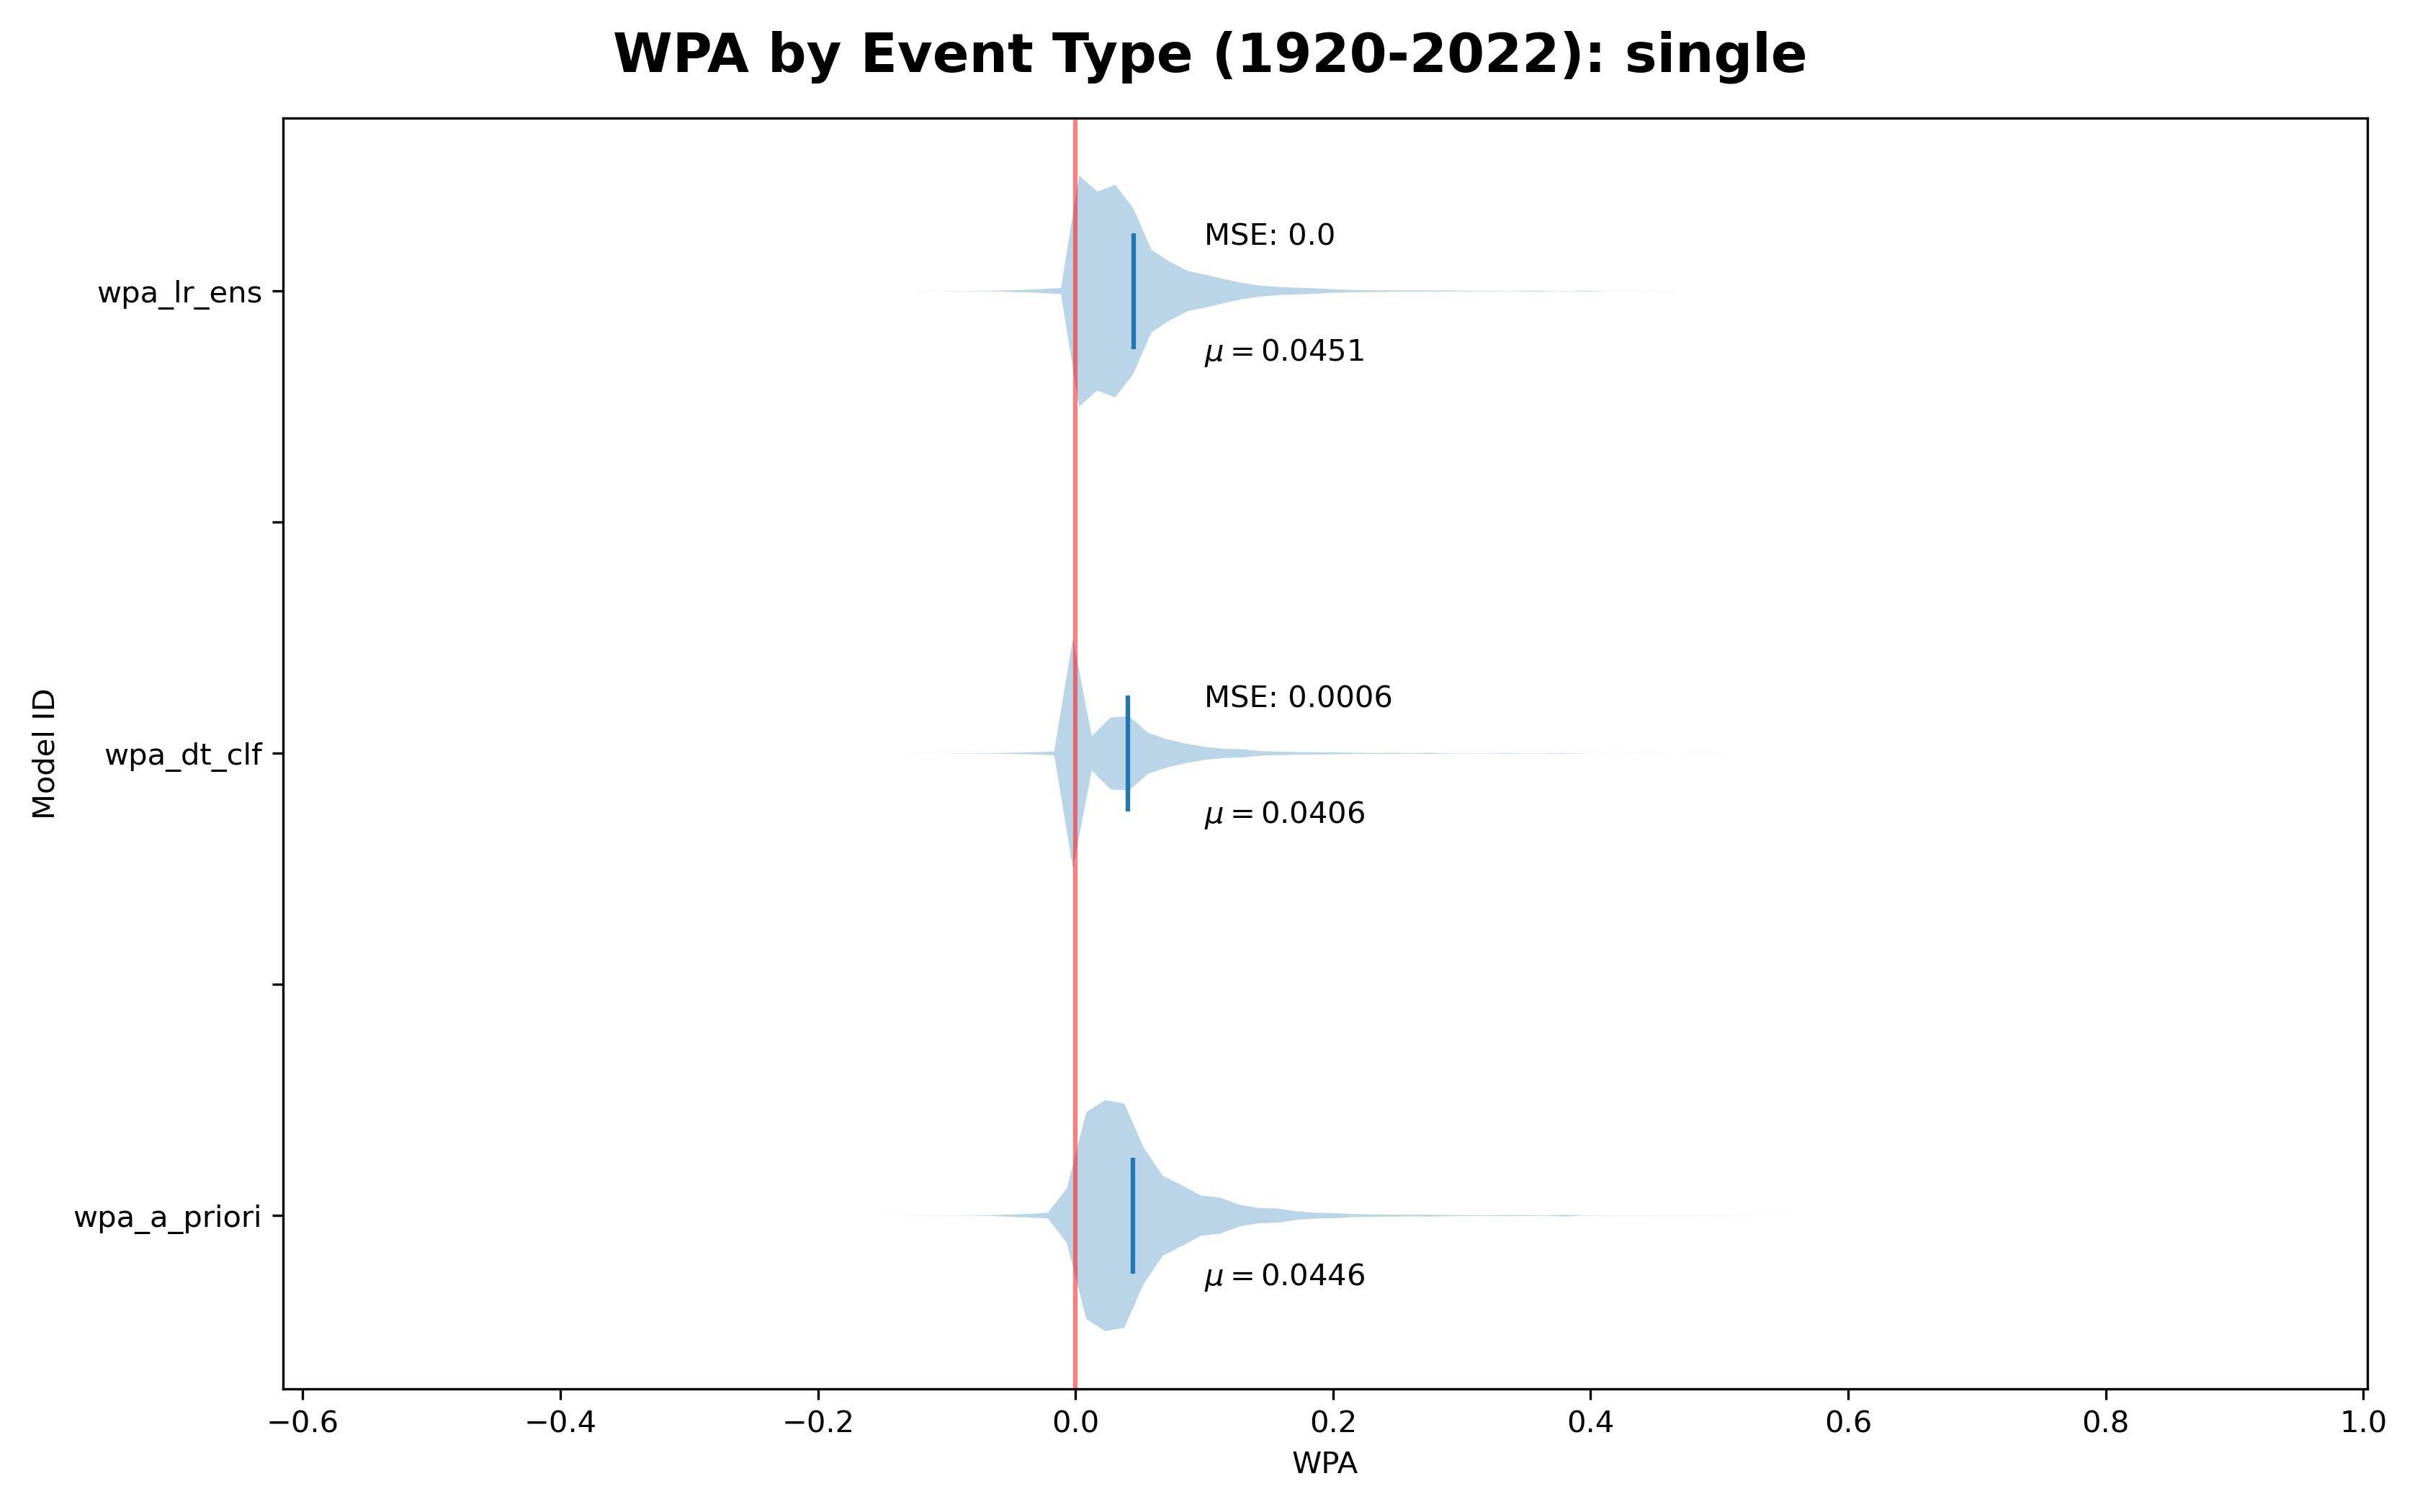

Doubles:

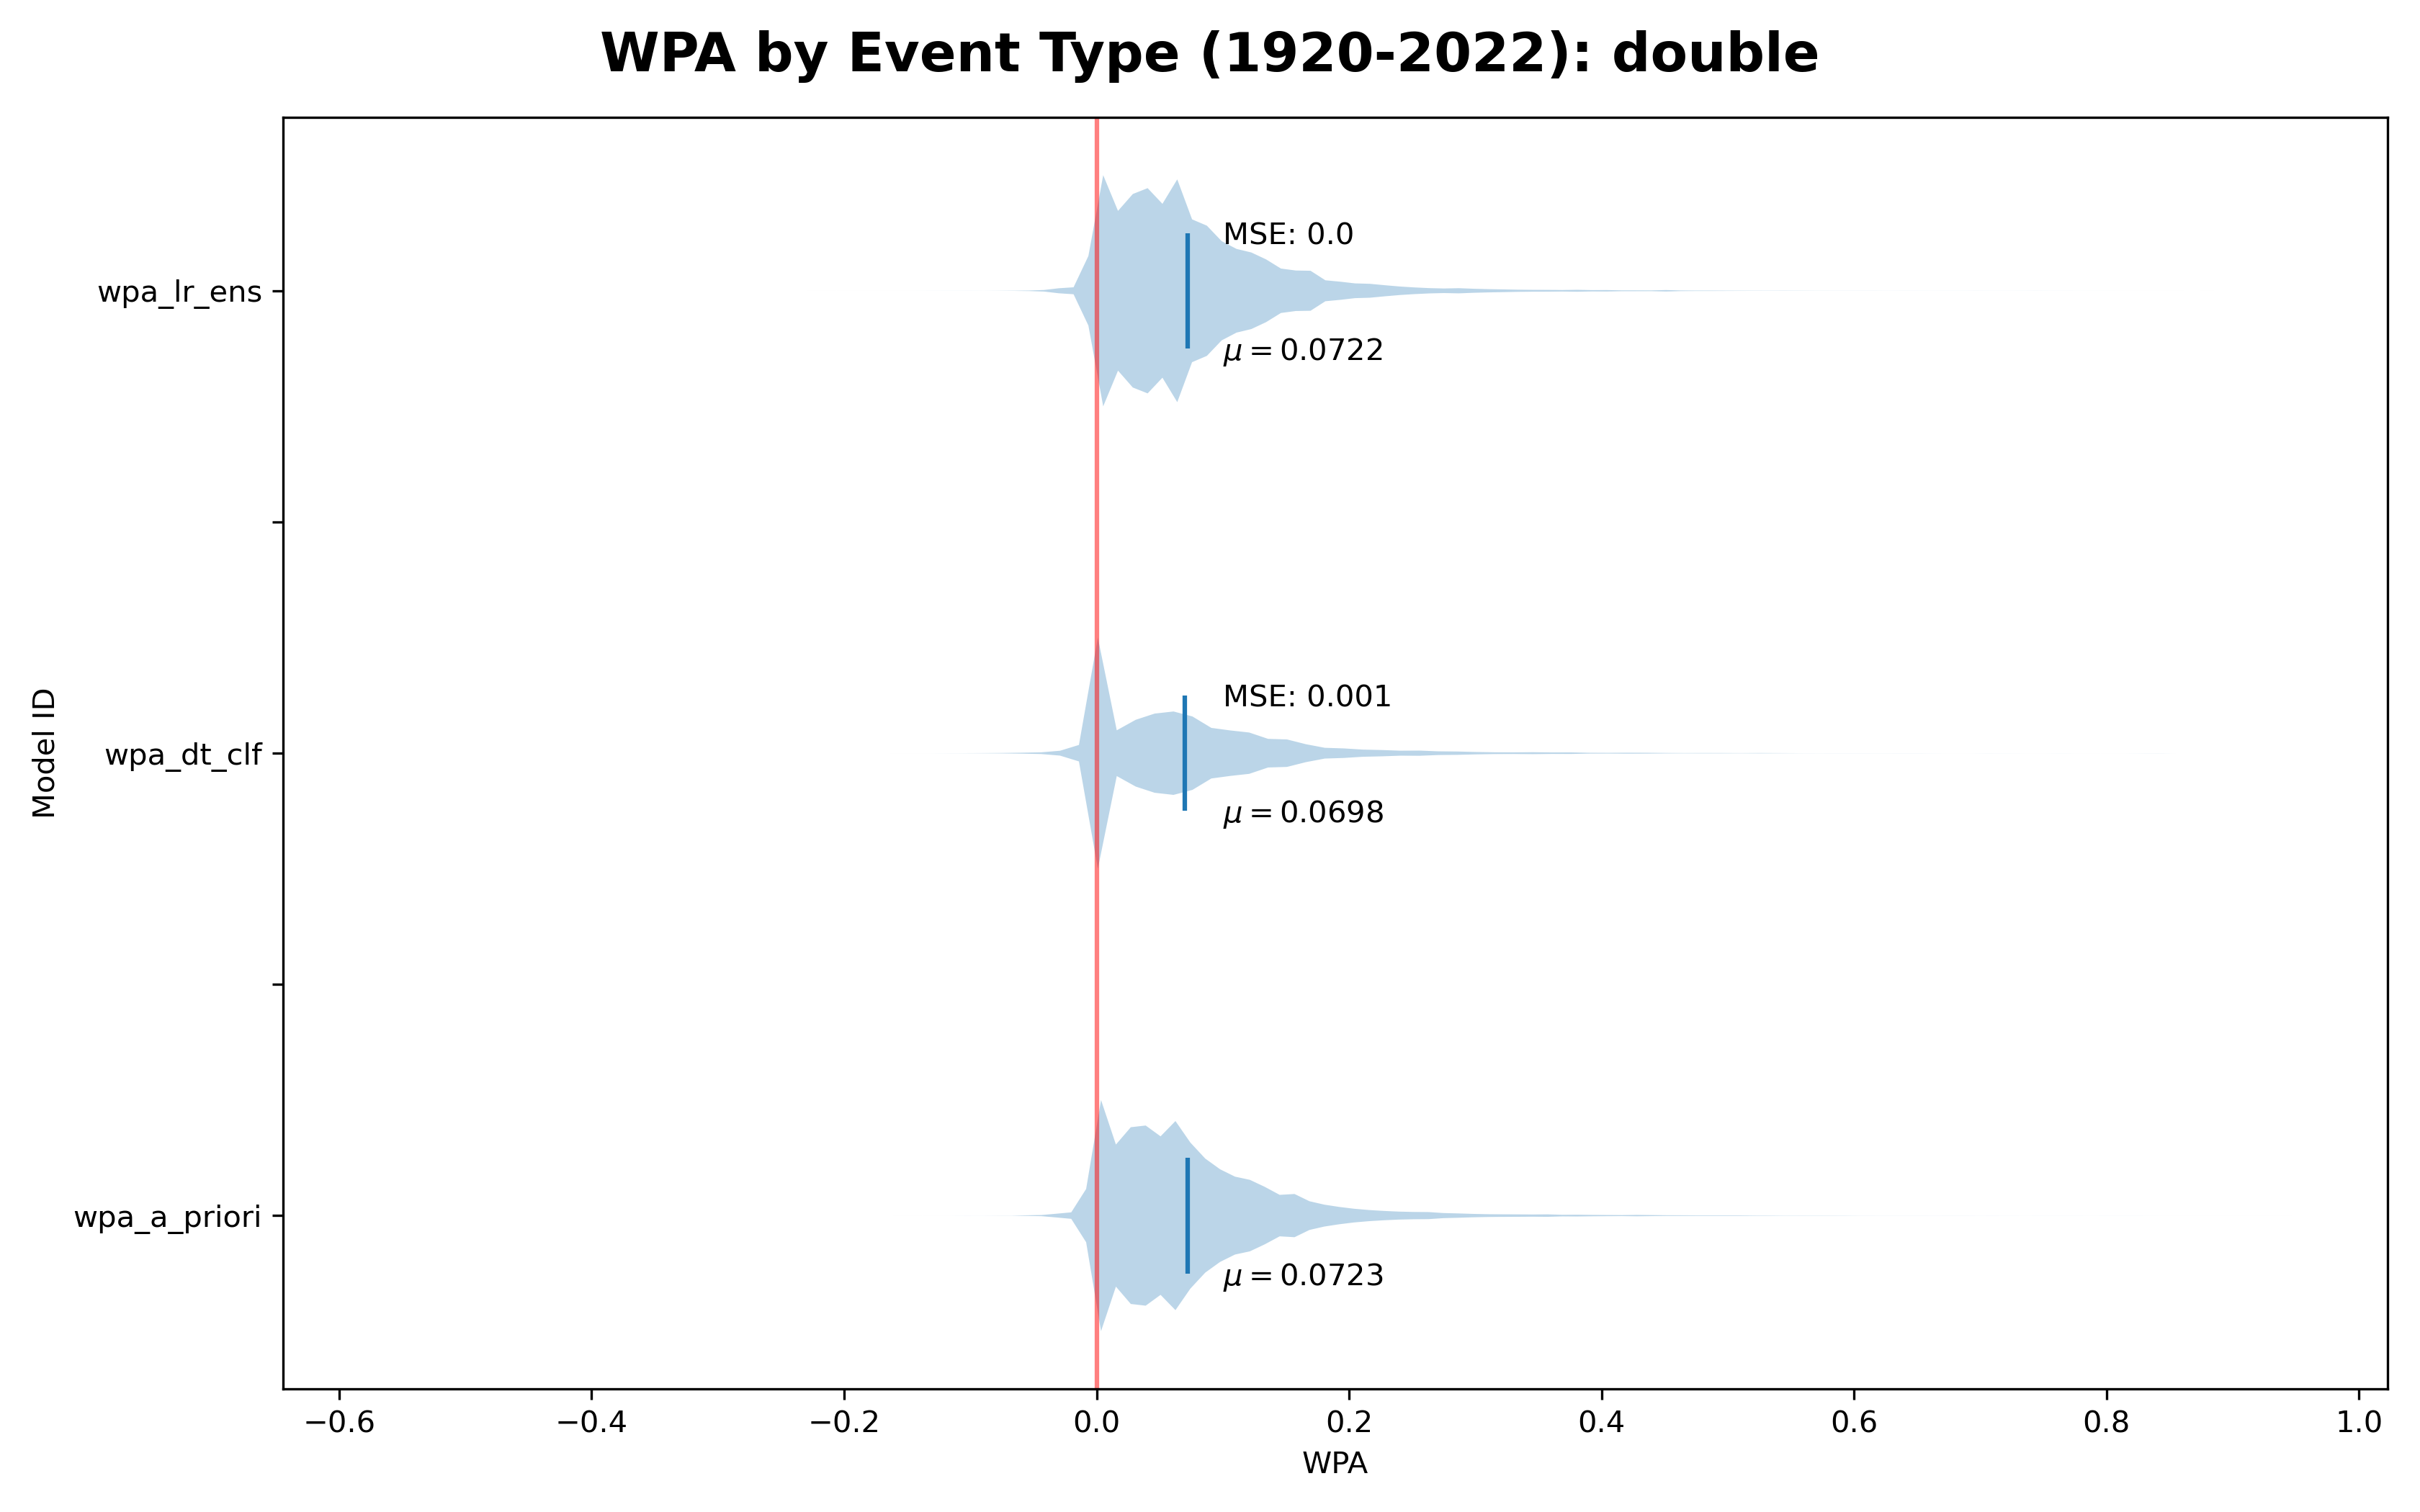

Triples:

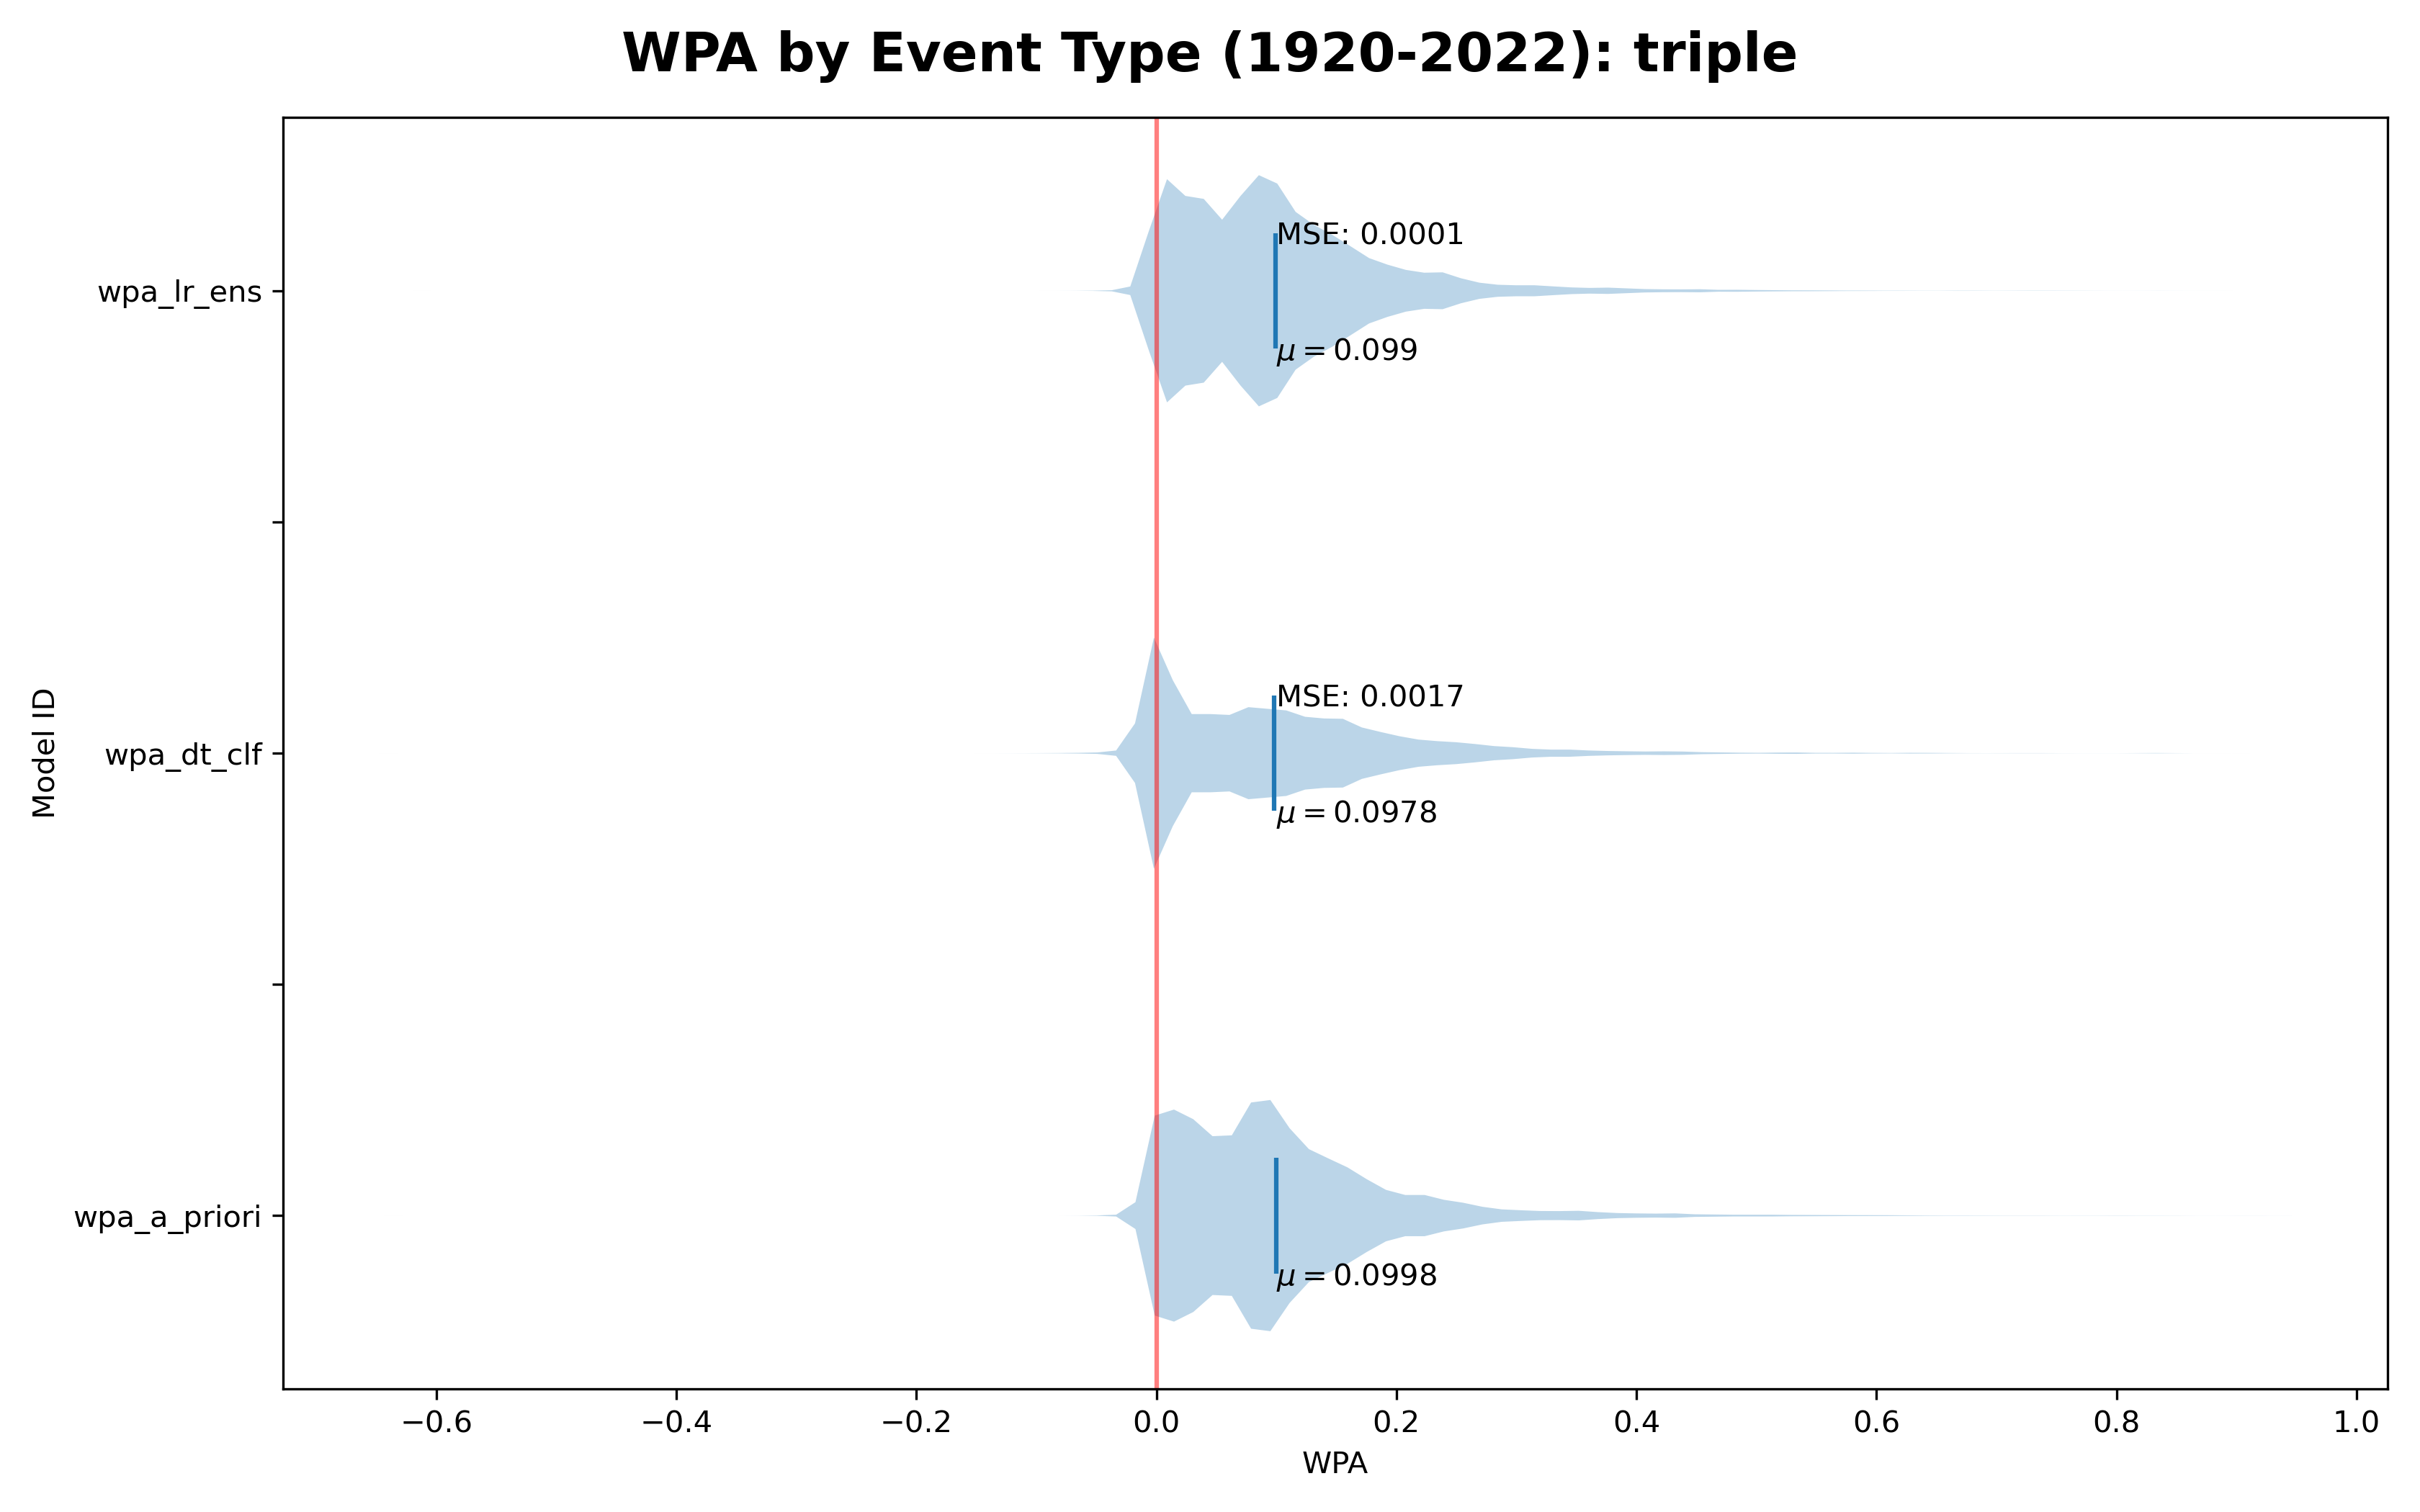

Home runs:

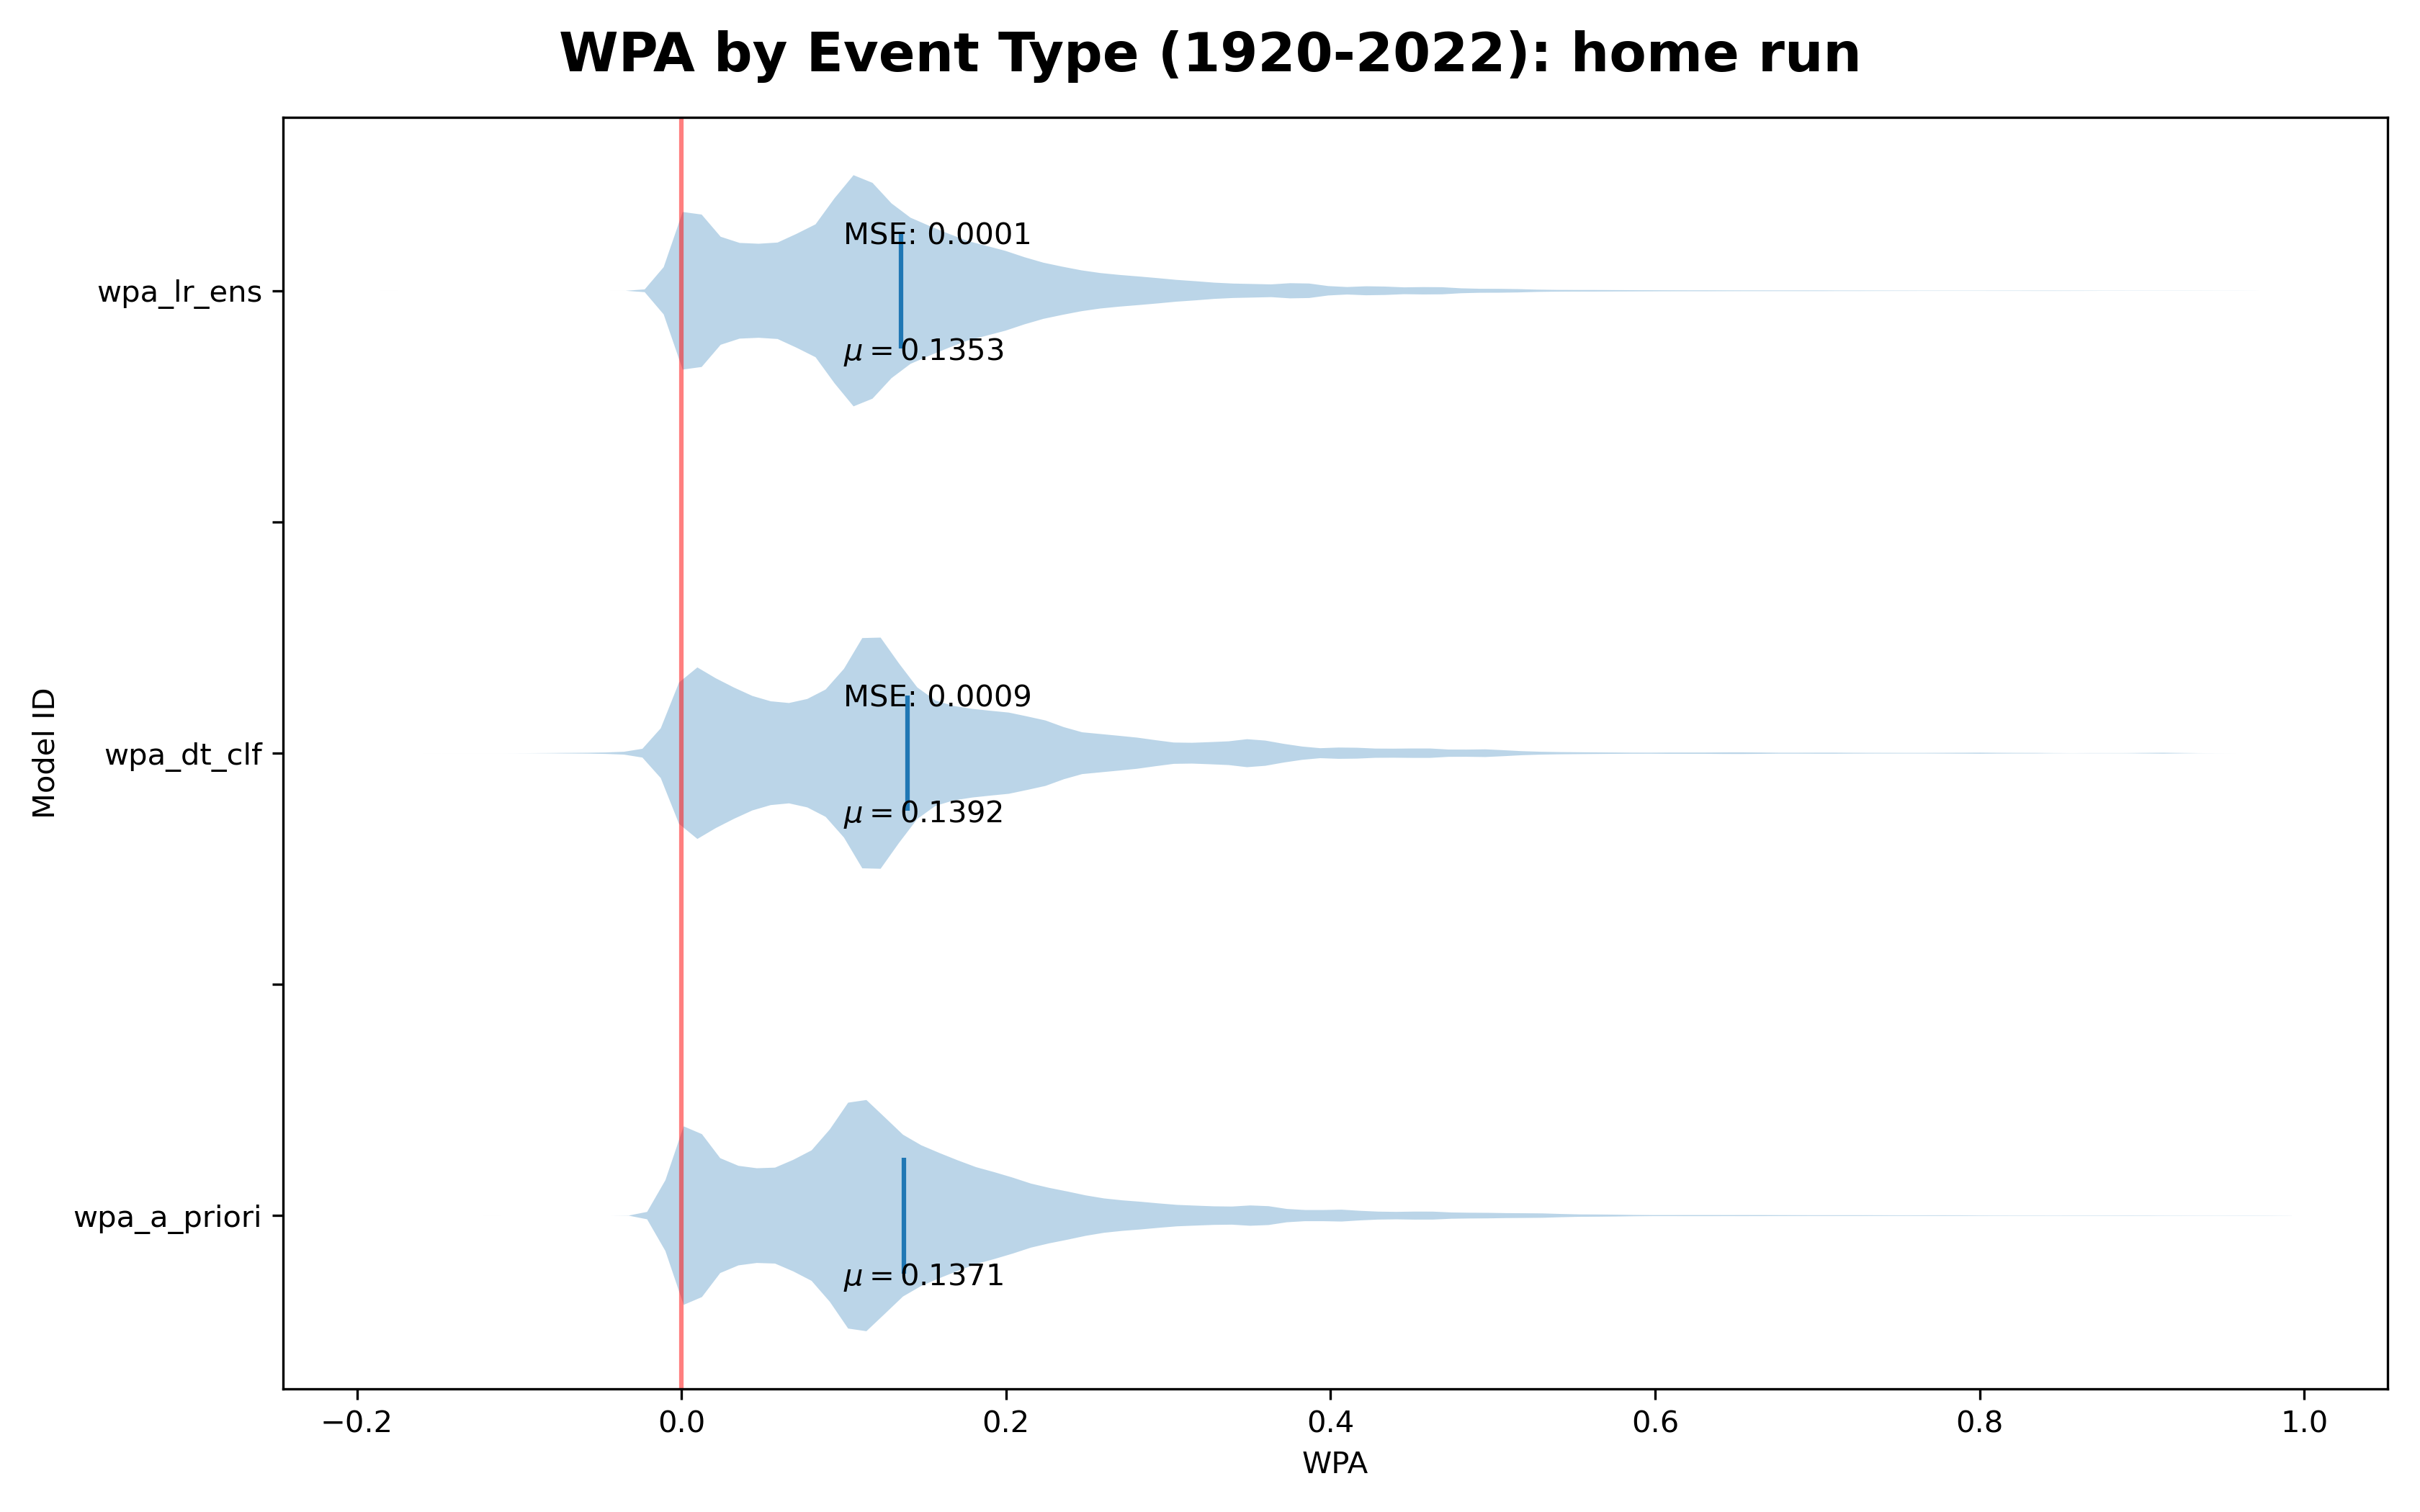

Walks:

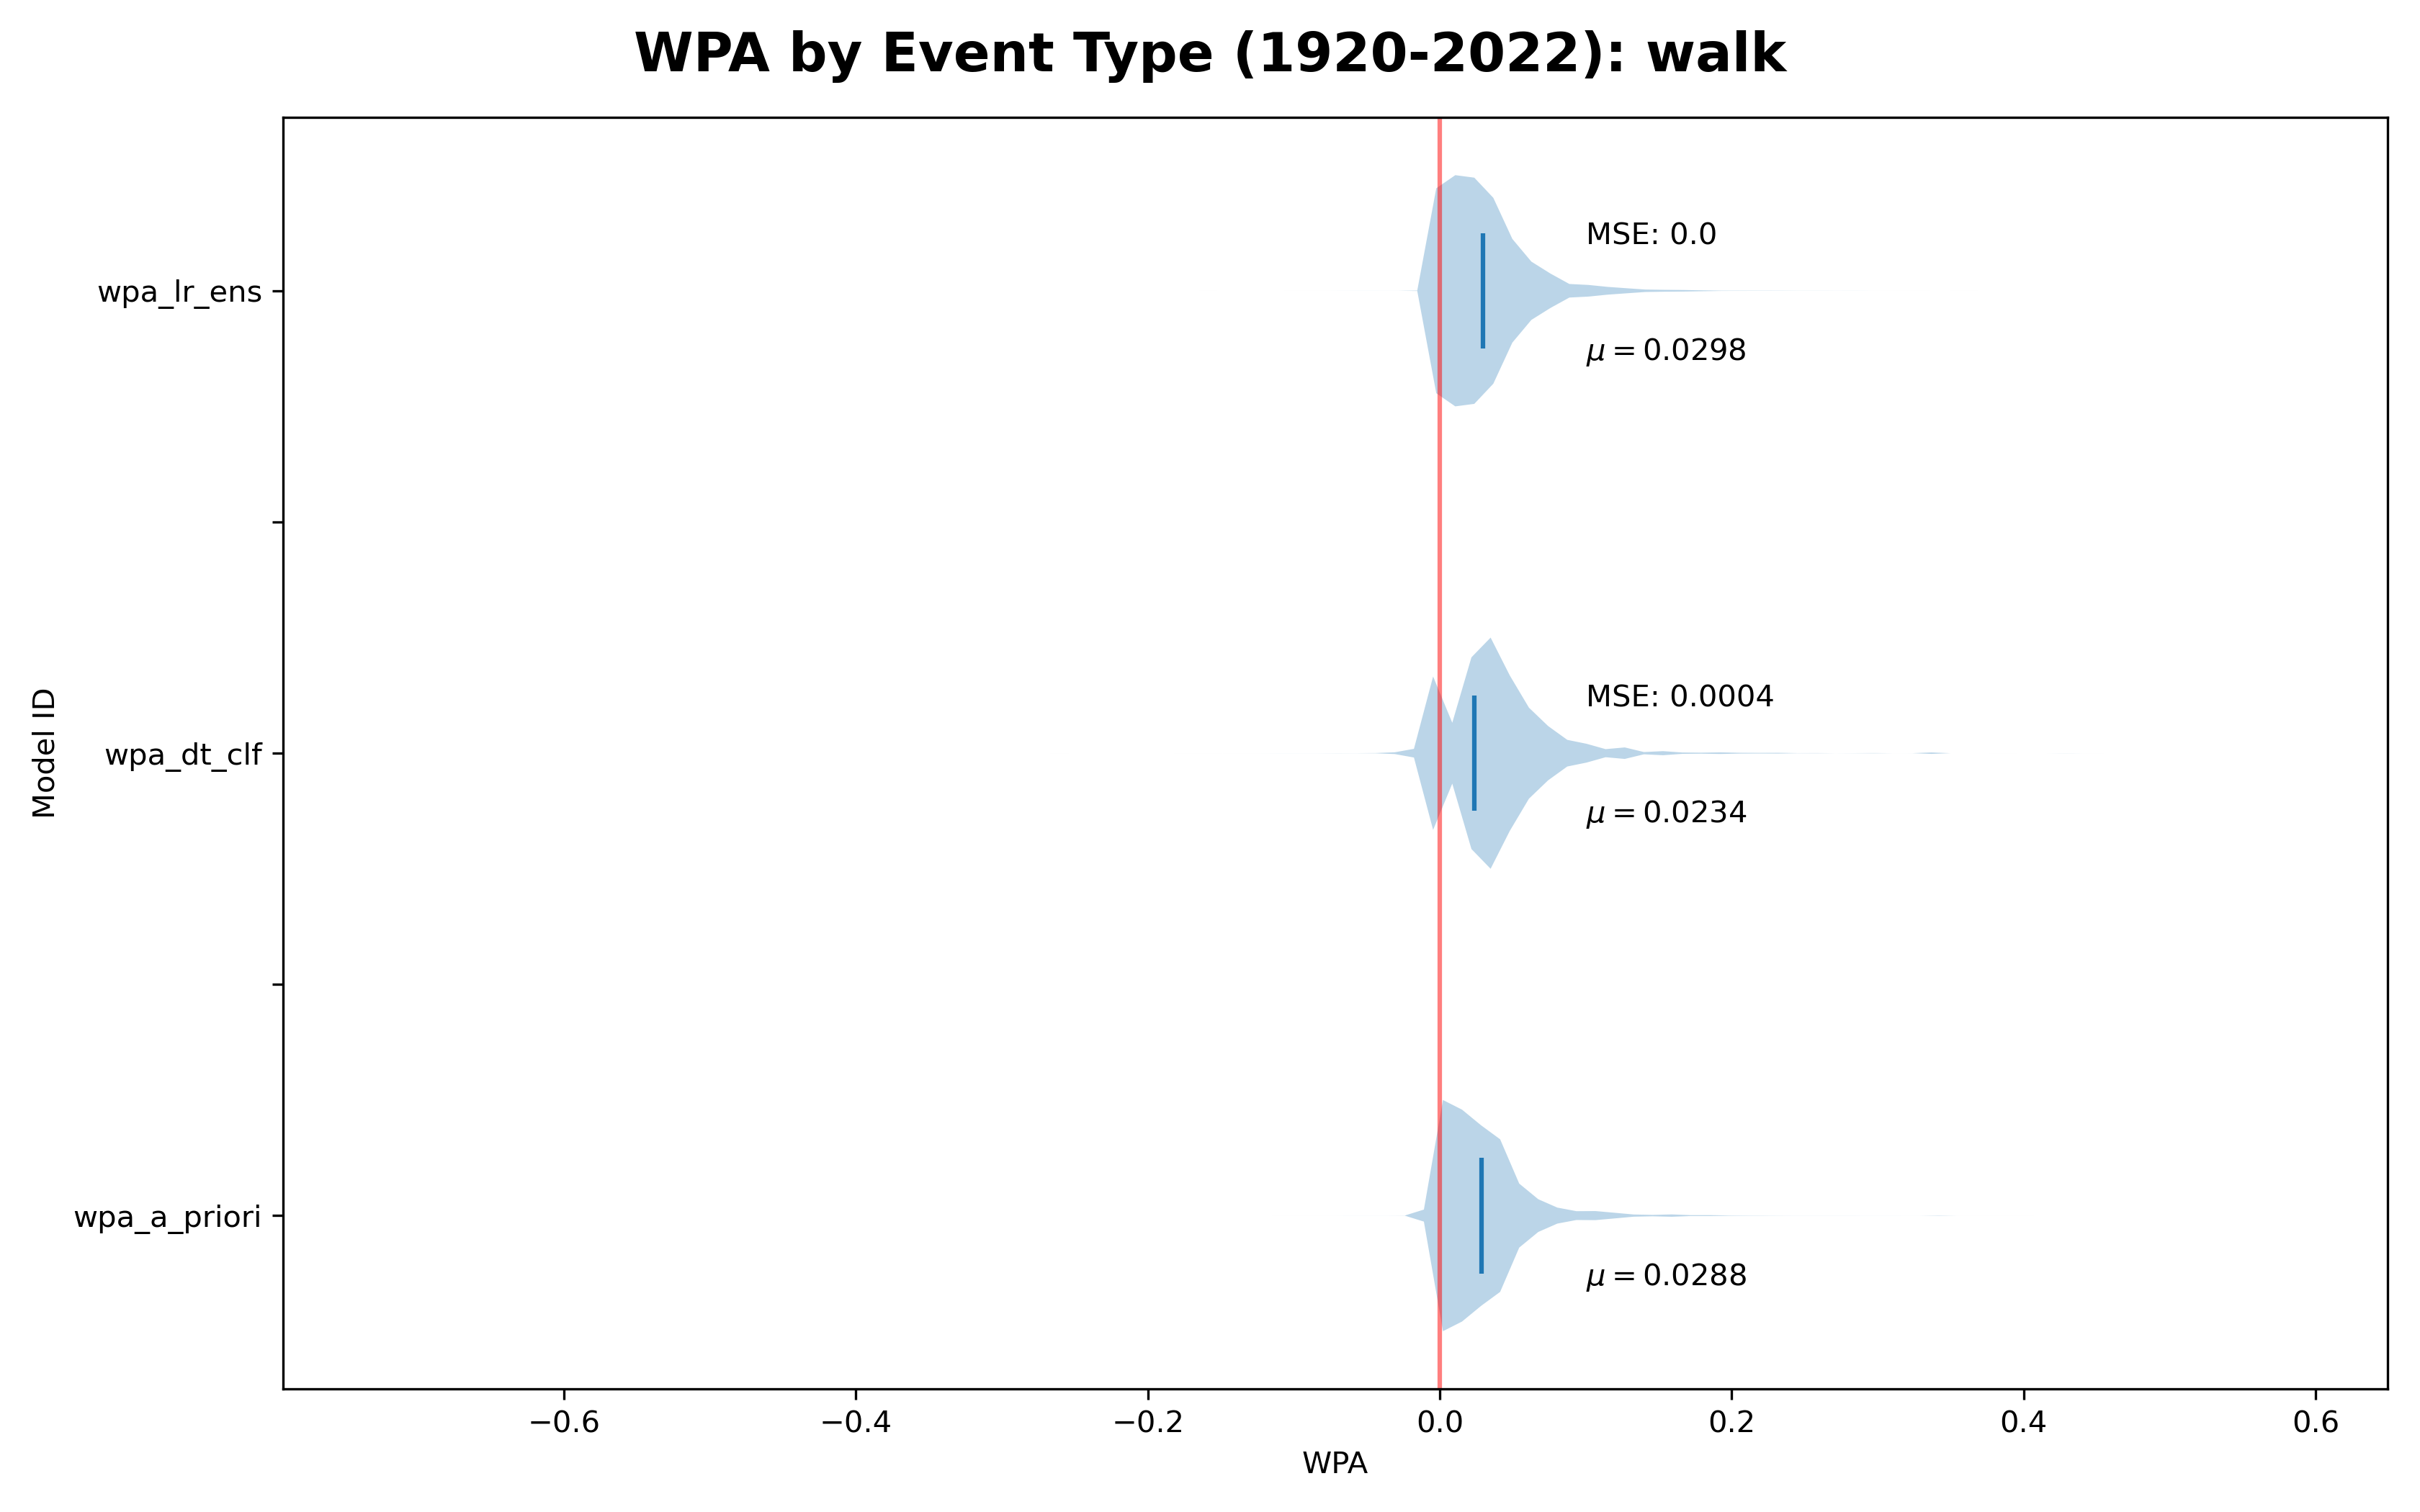

Intentional walks:

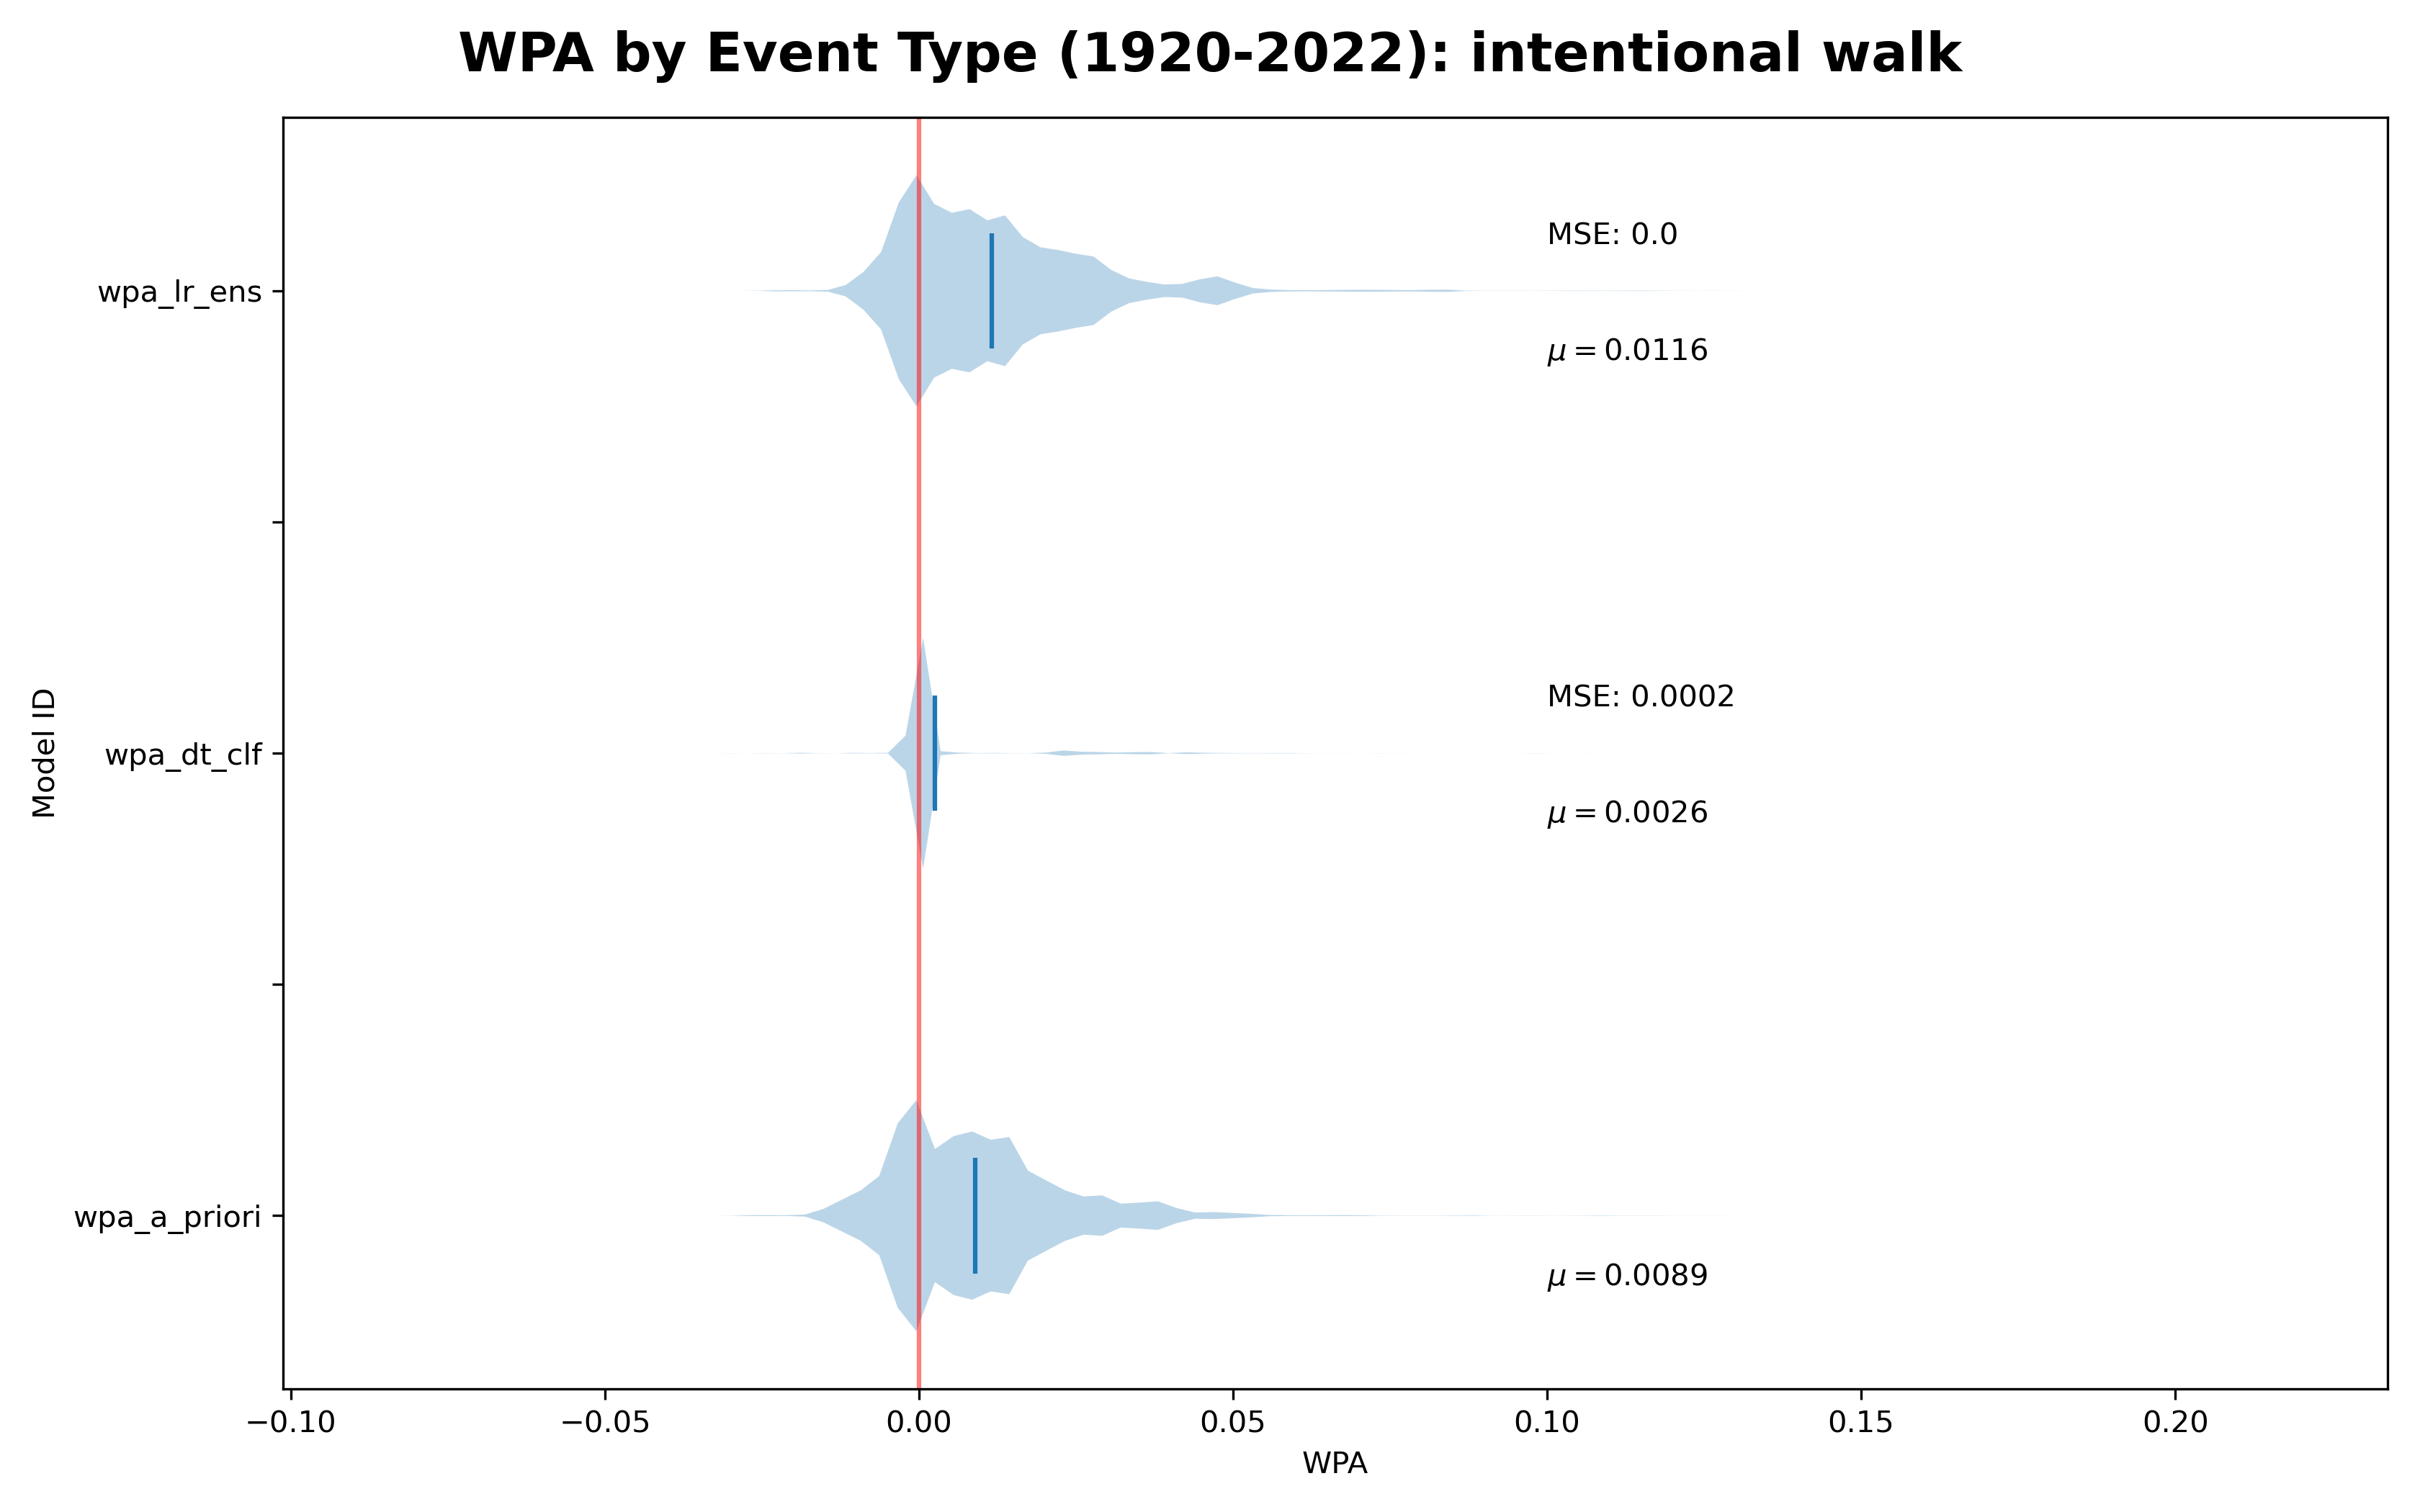

Stolen bases:

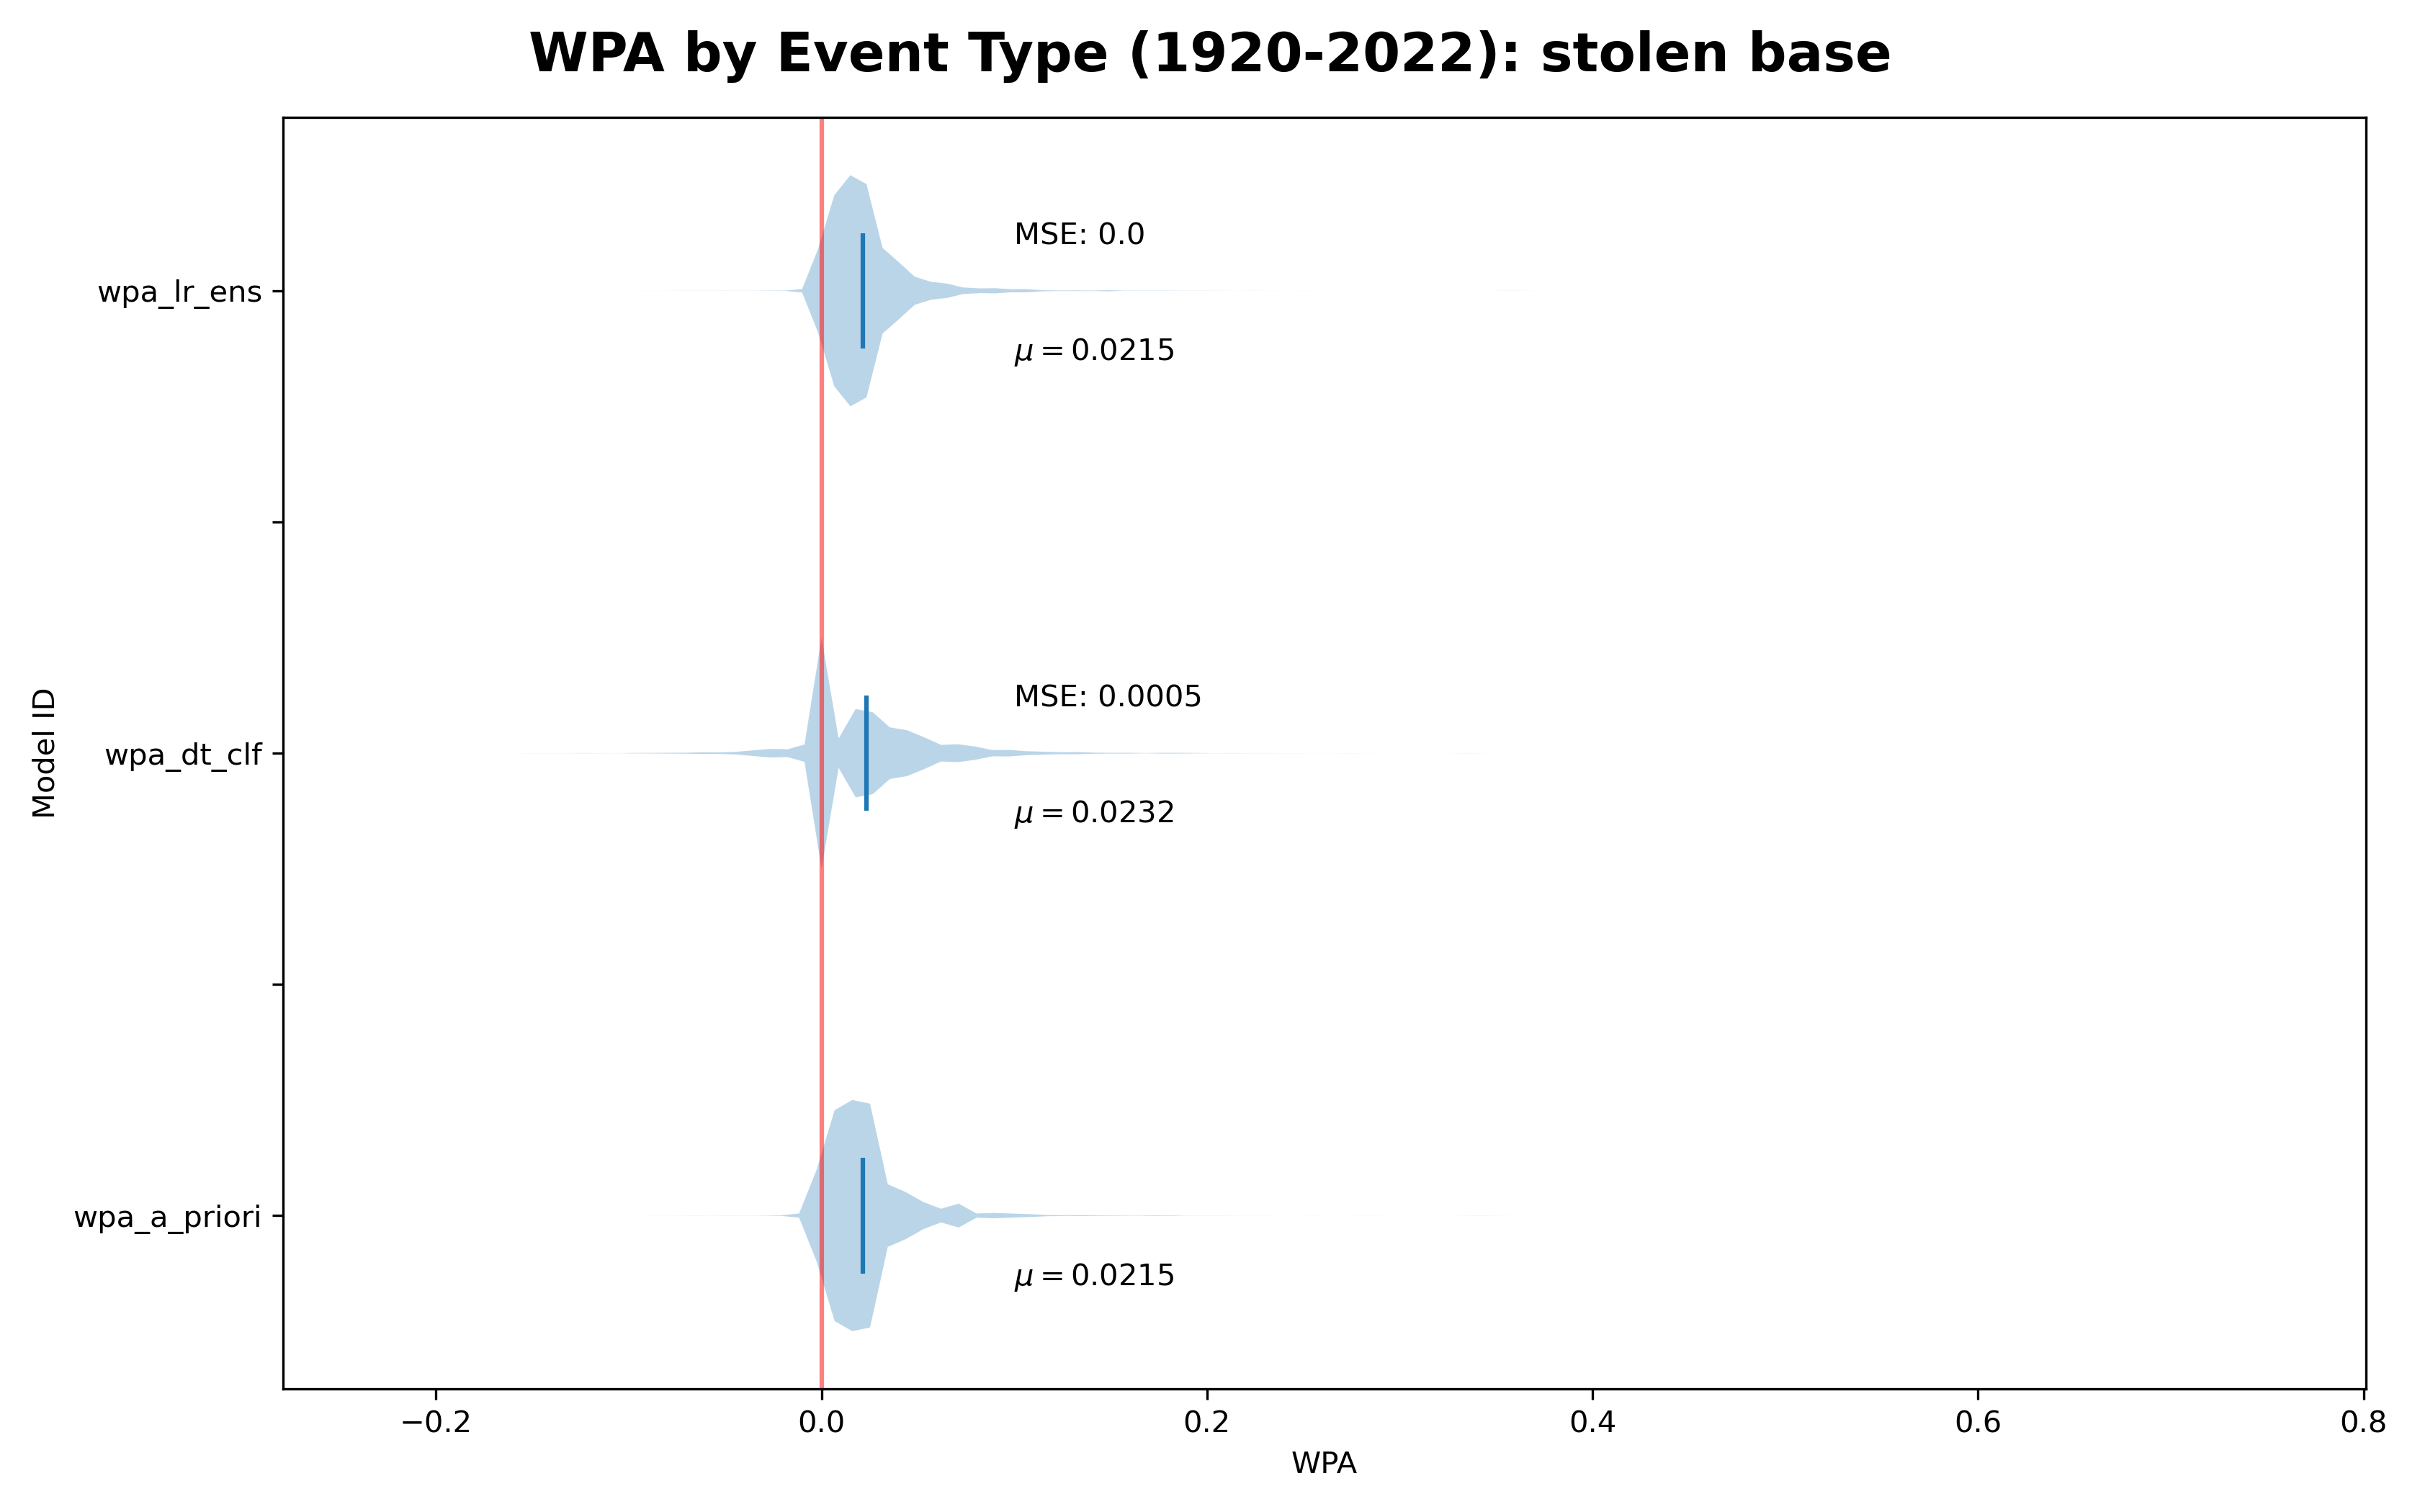

Passed balls:

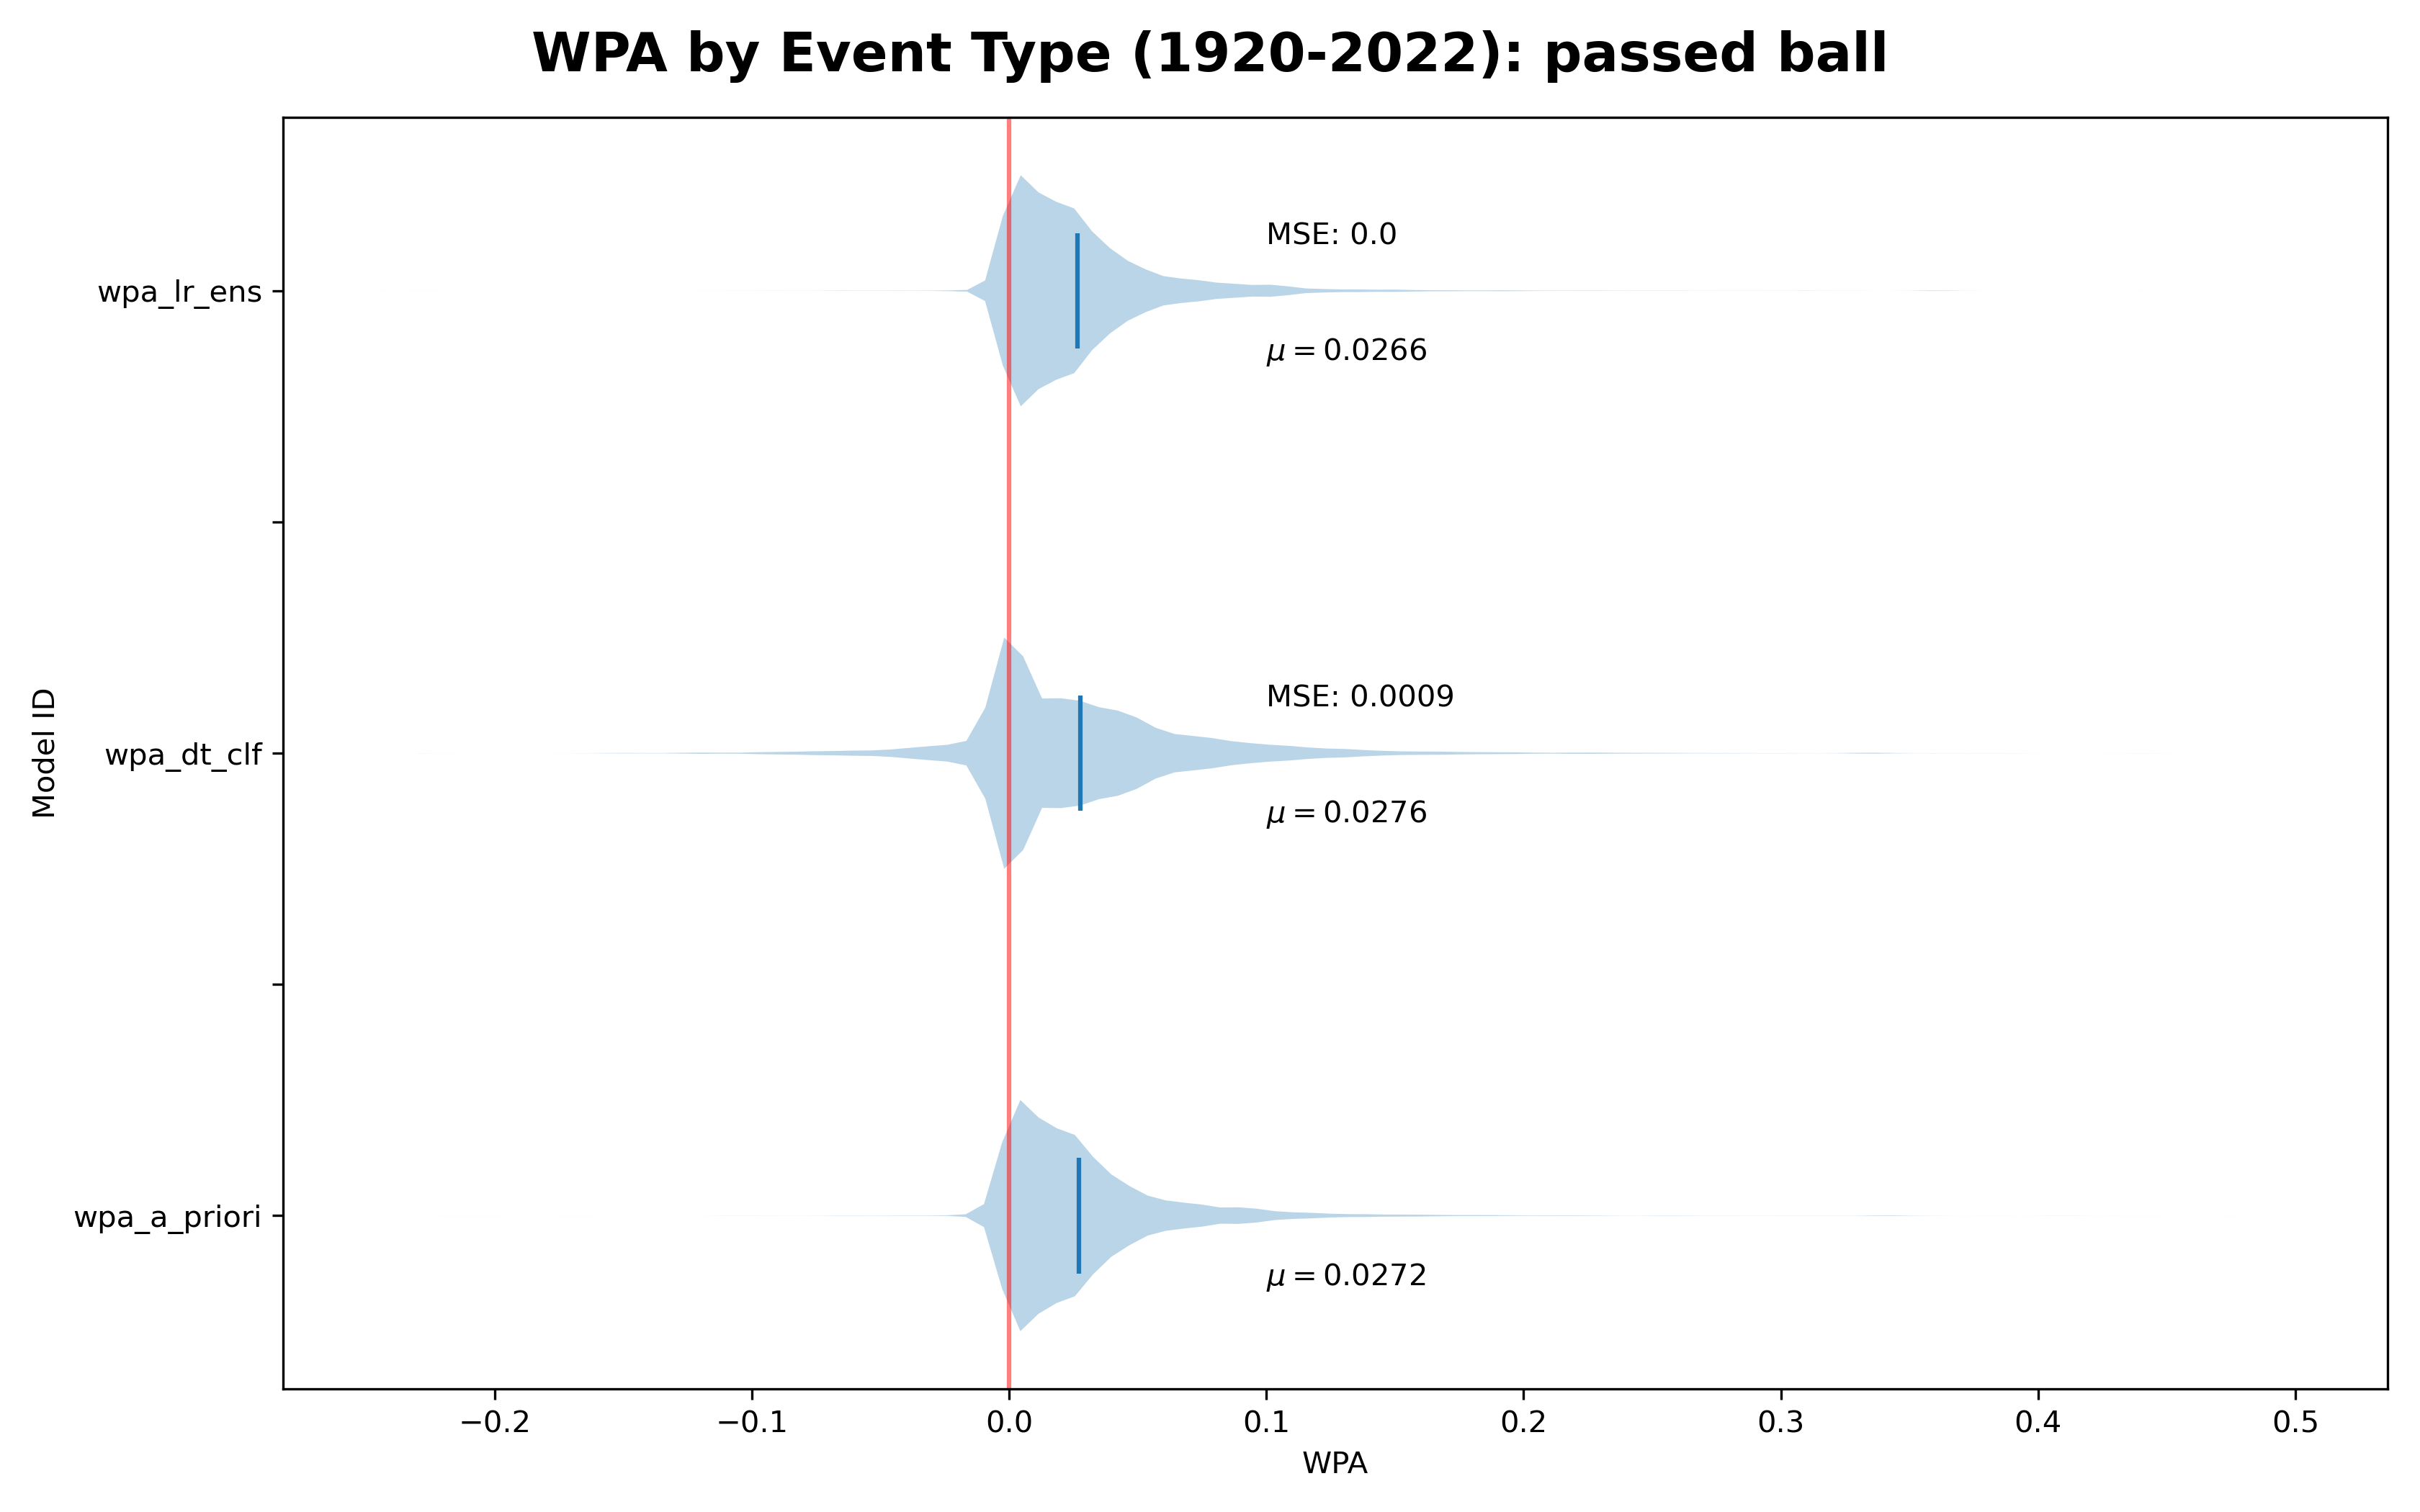

Hit by pitch:

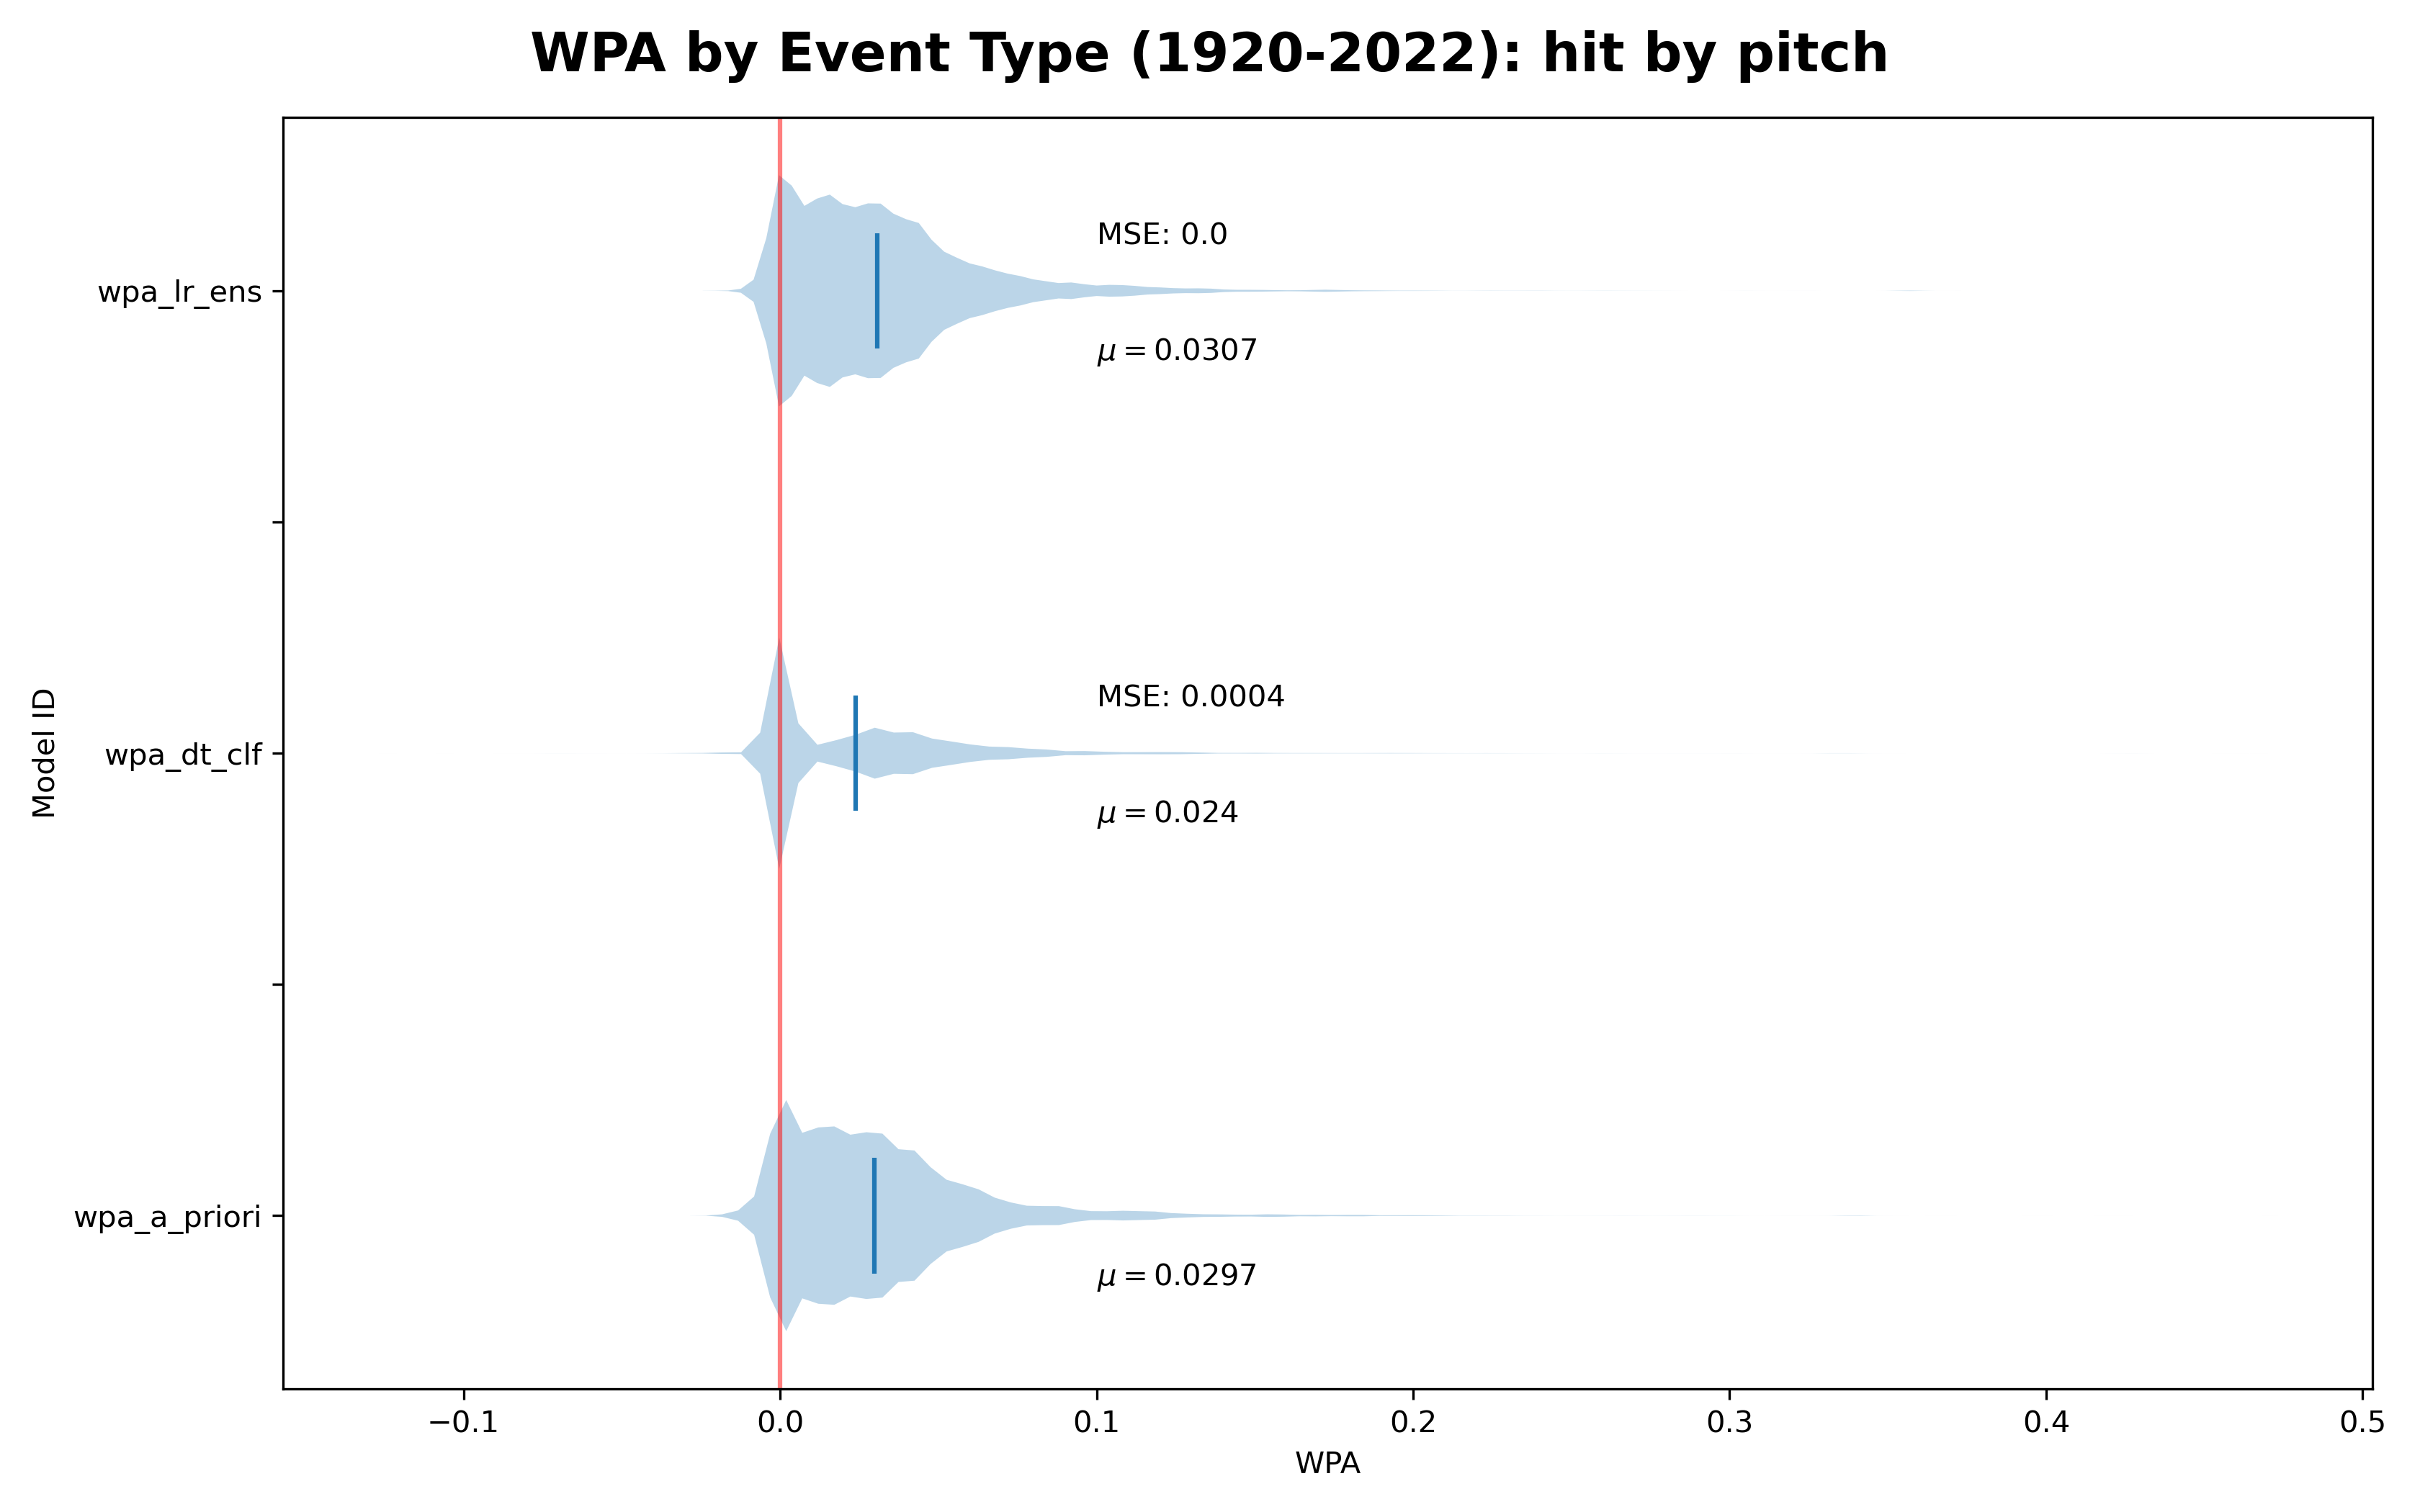

Errors:

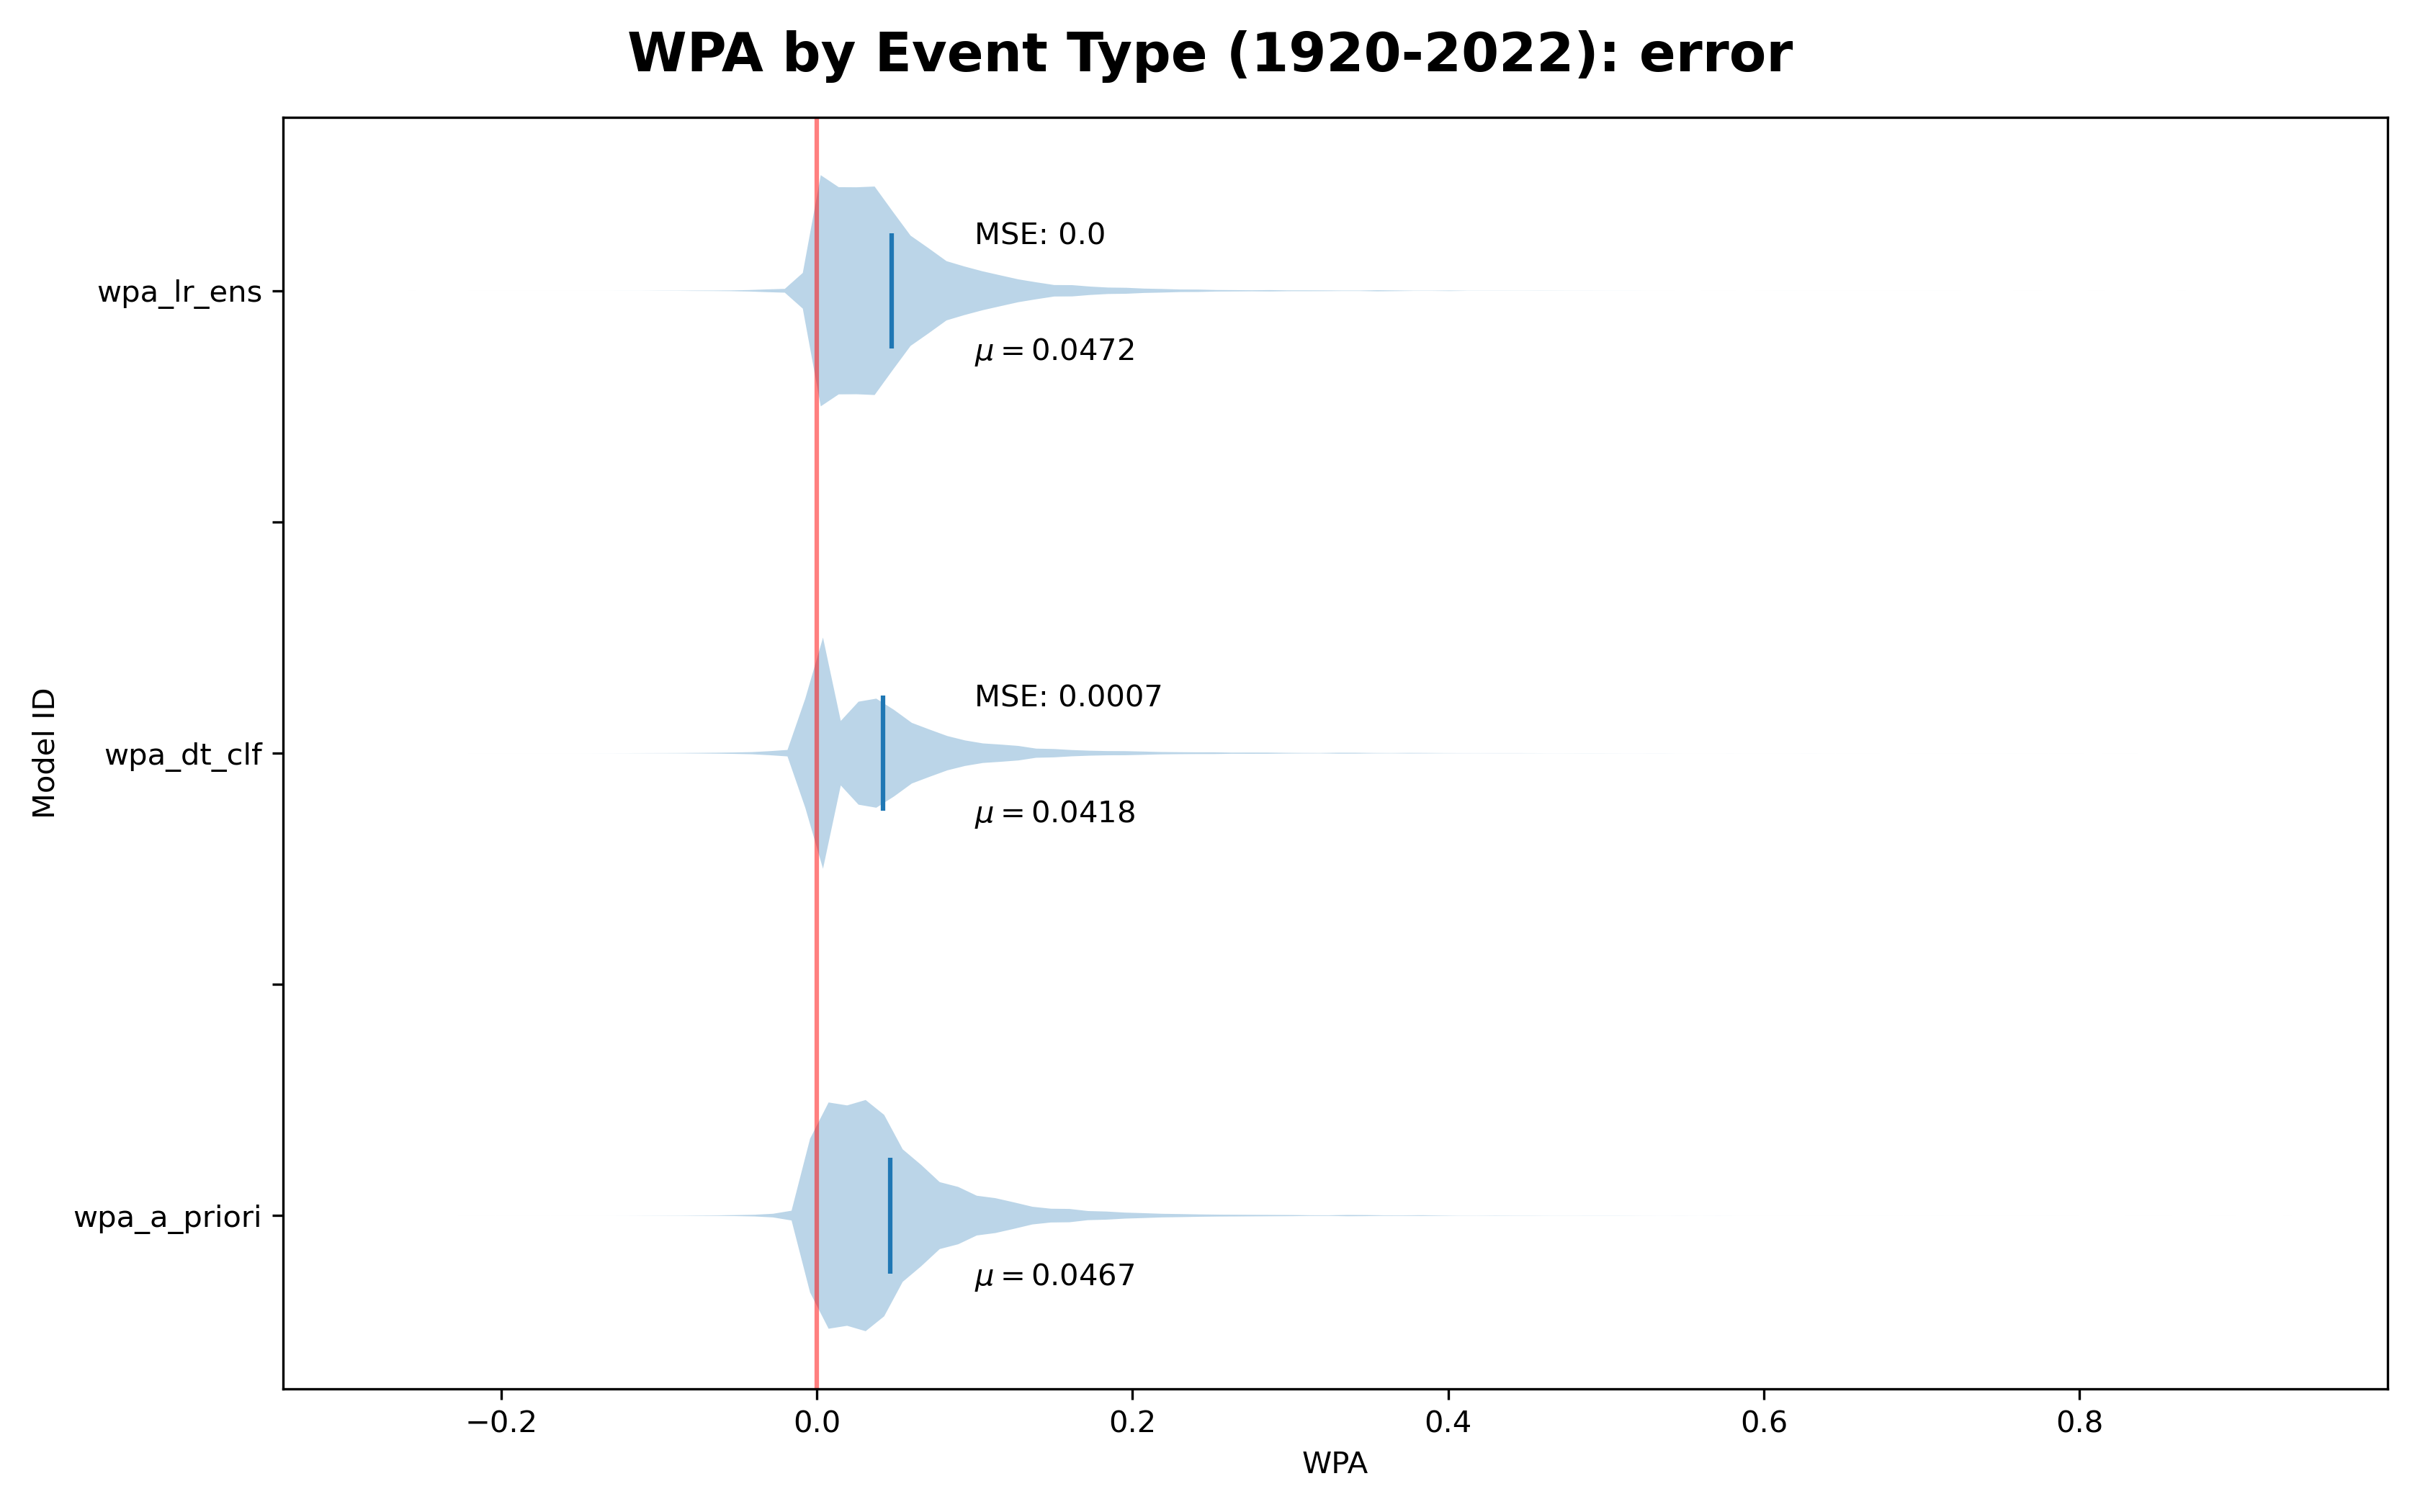

Defensive interference:

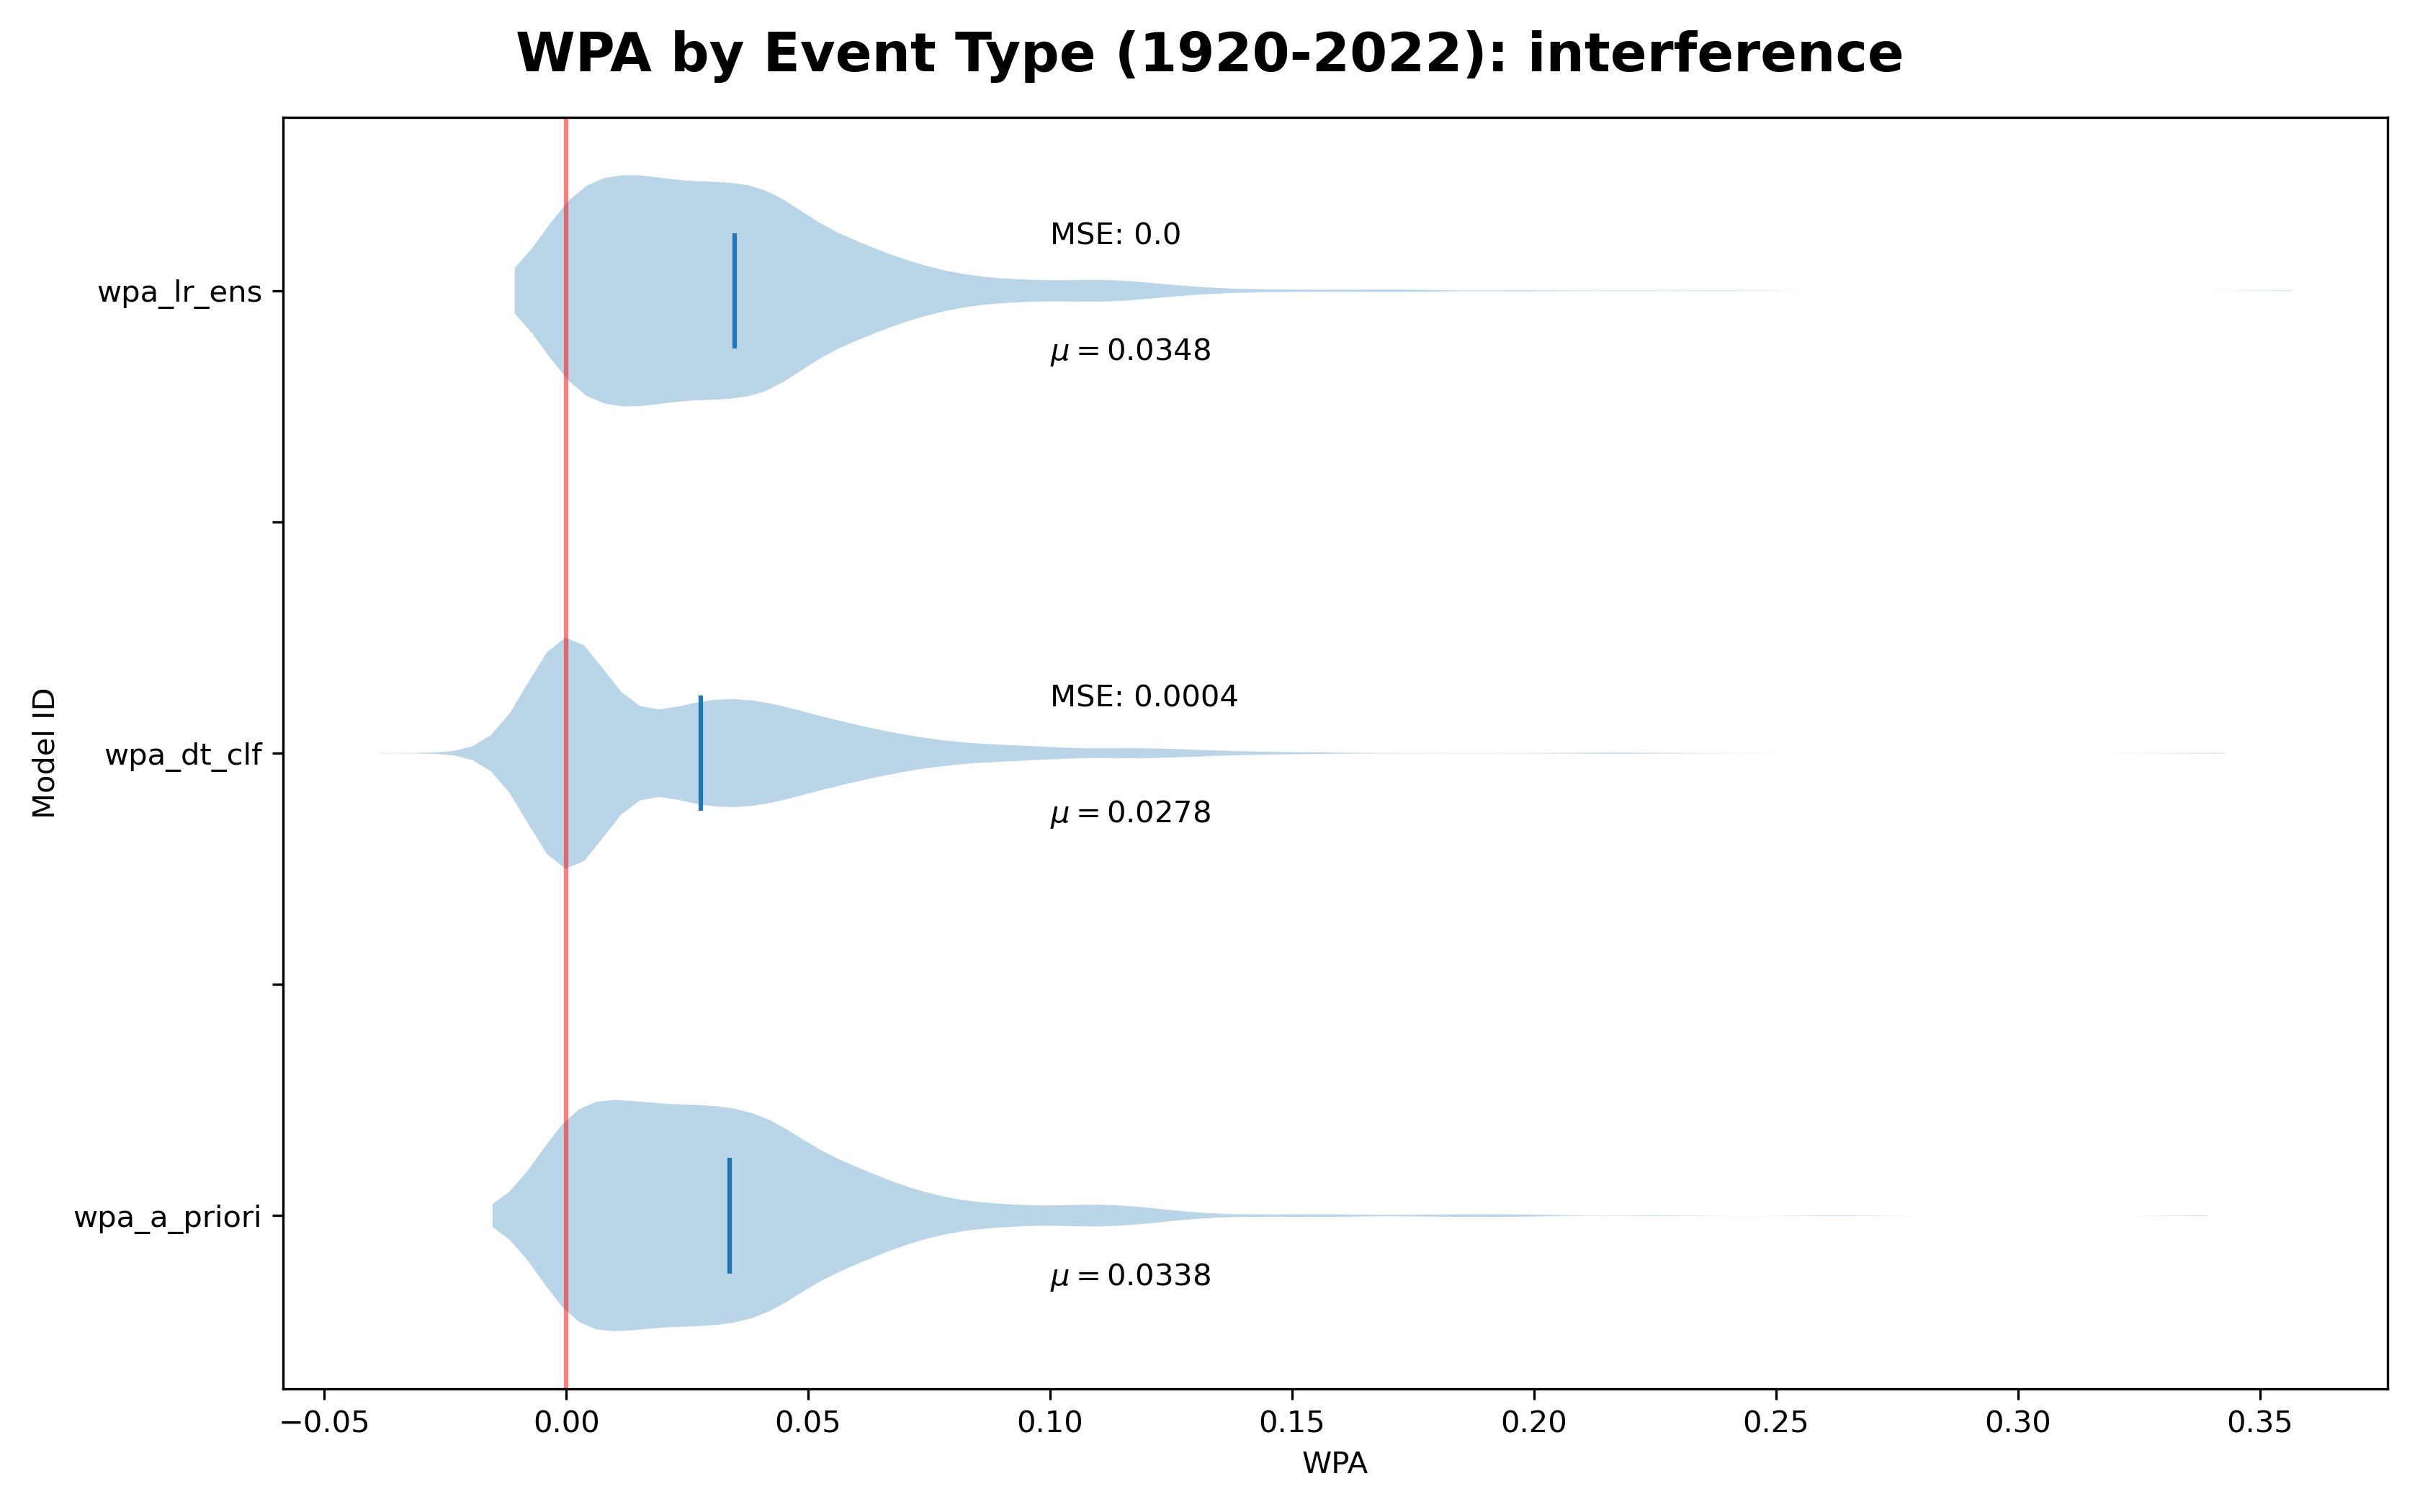

Wild pitch:

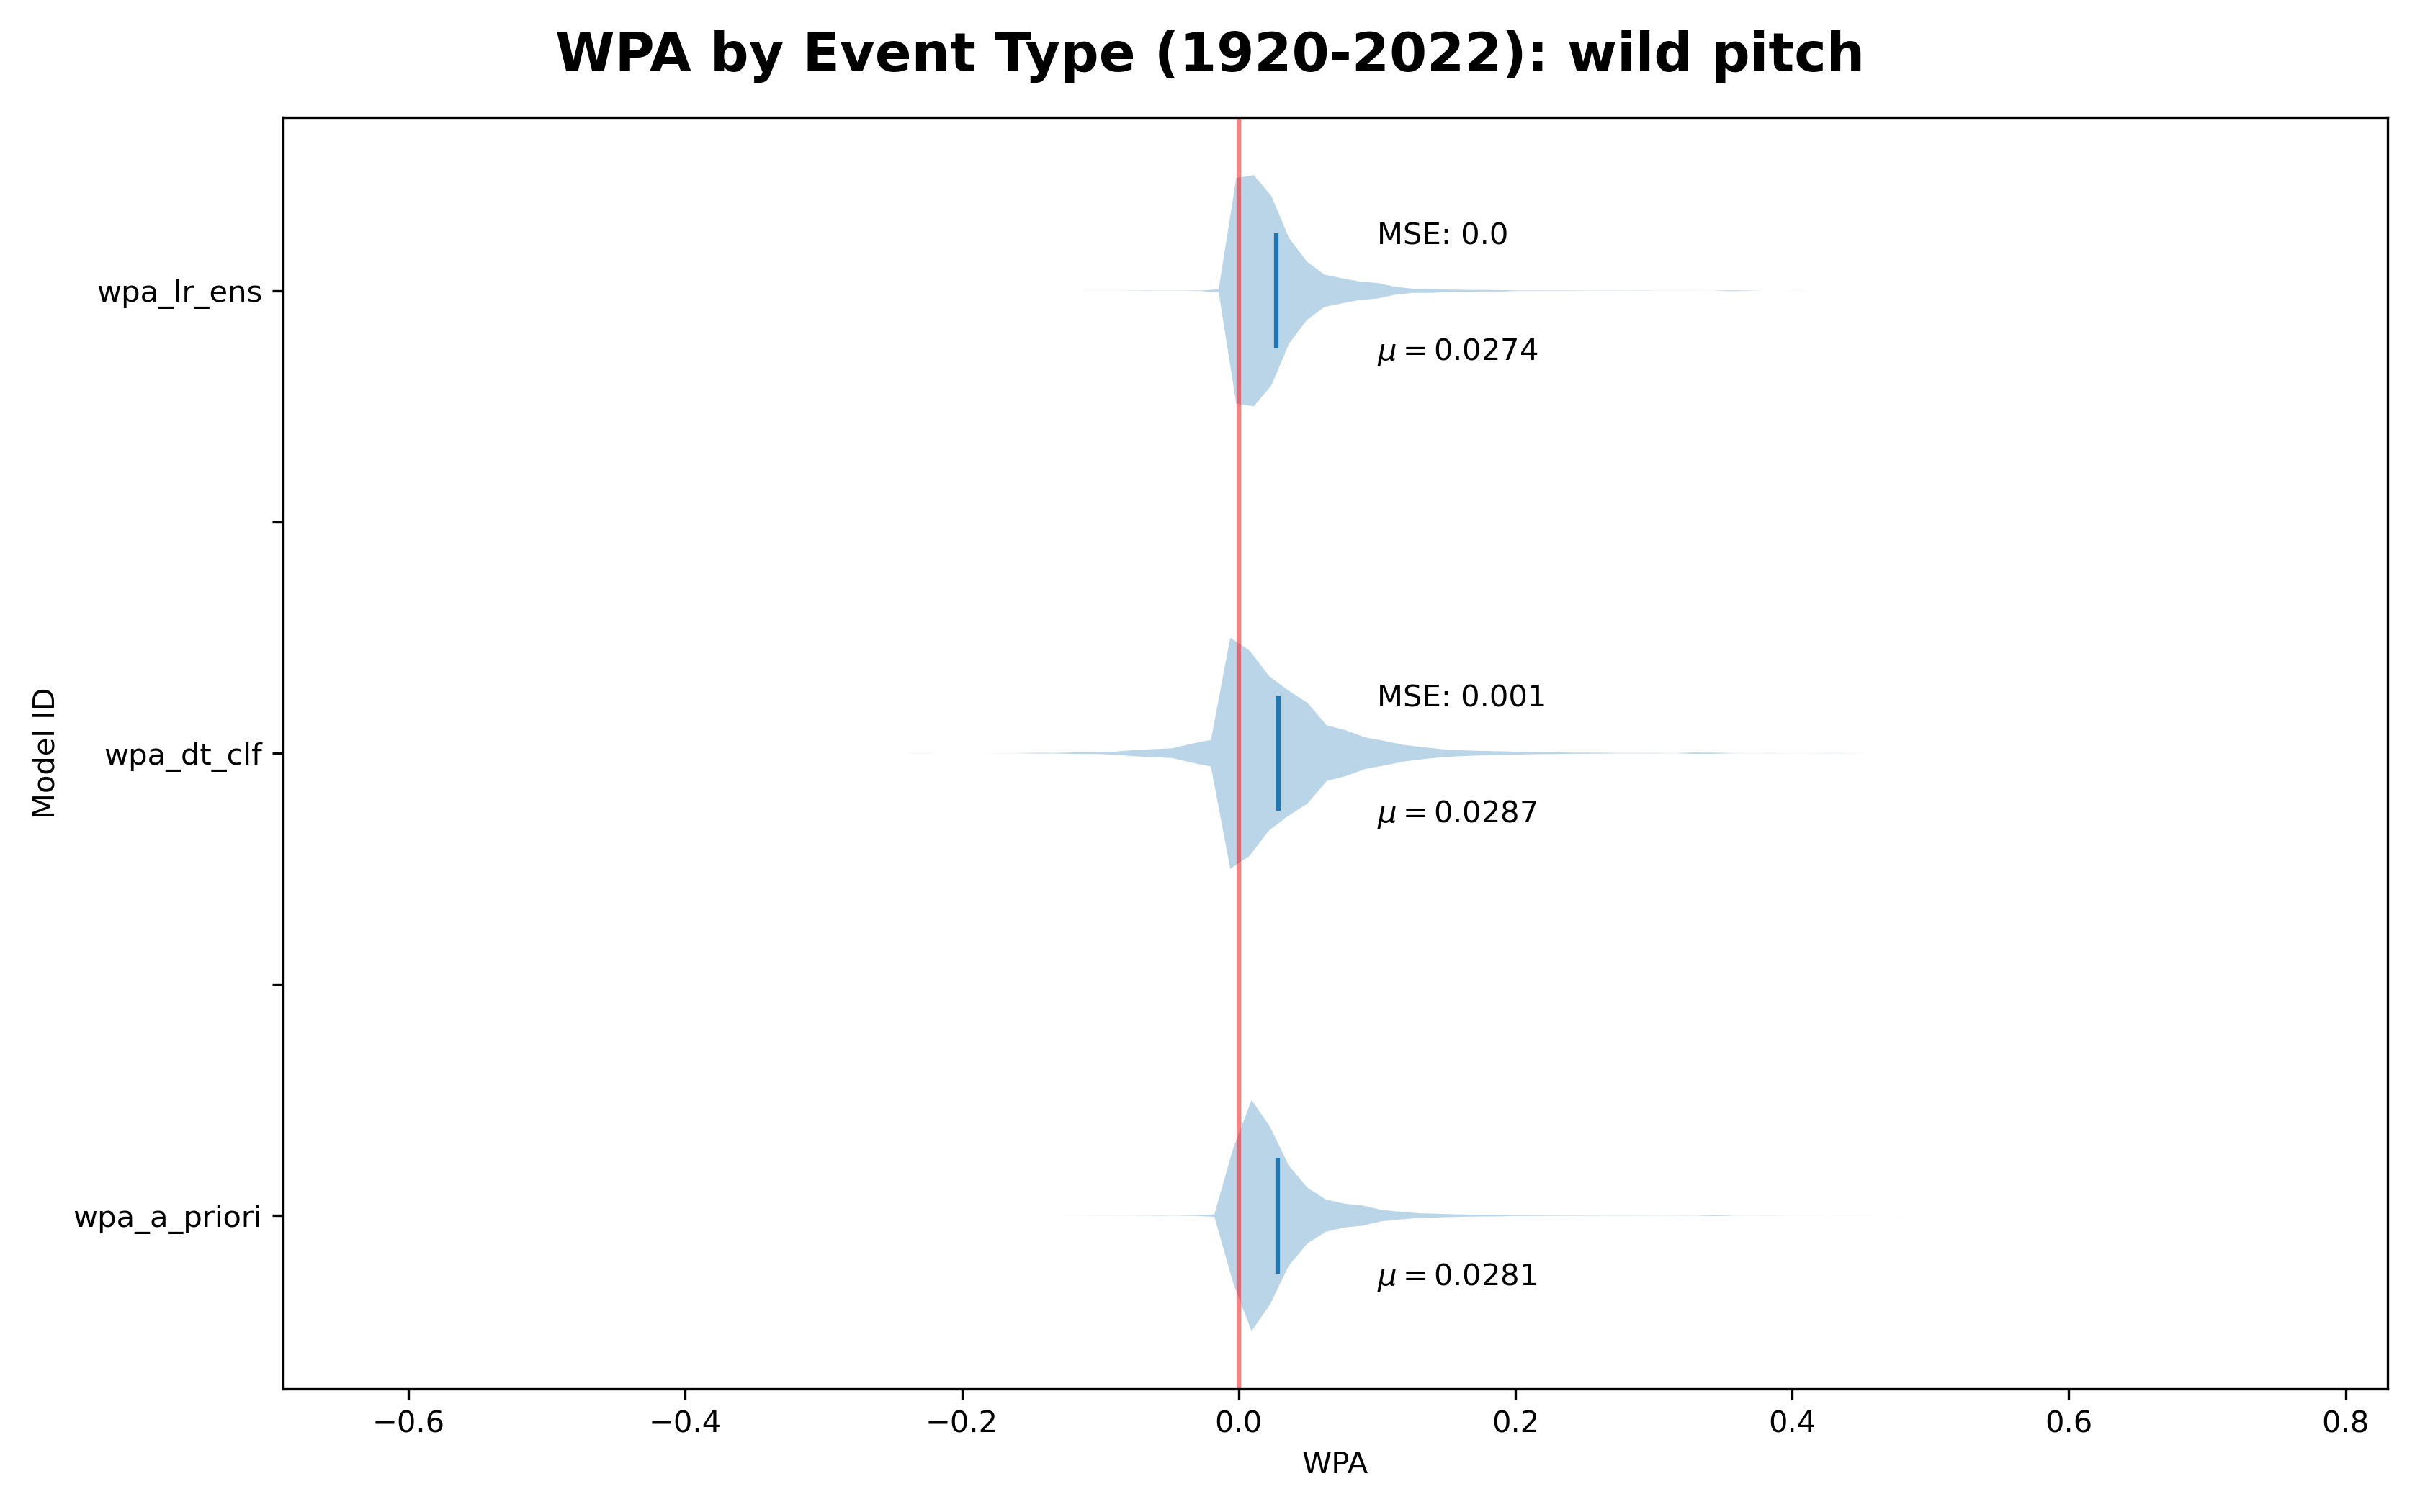

Balk:

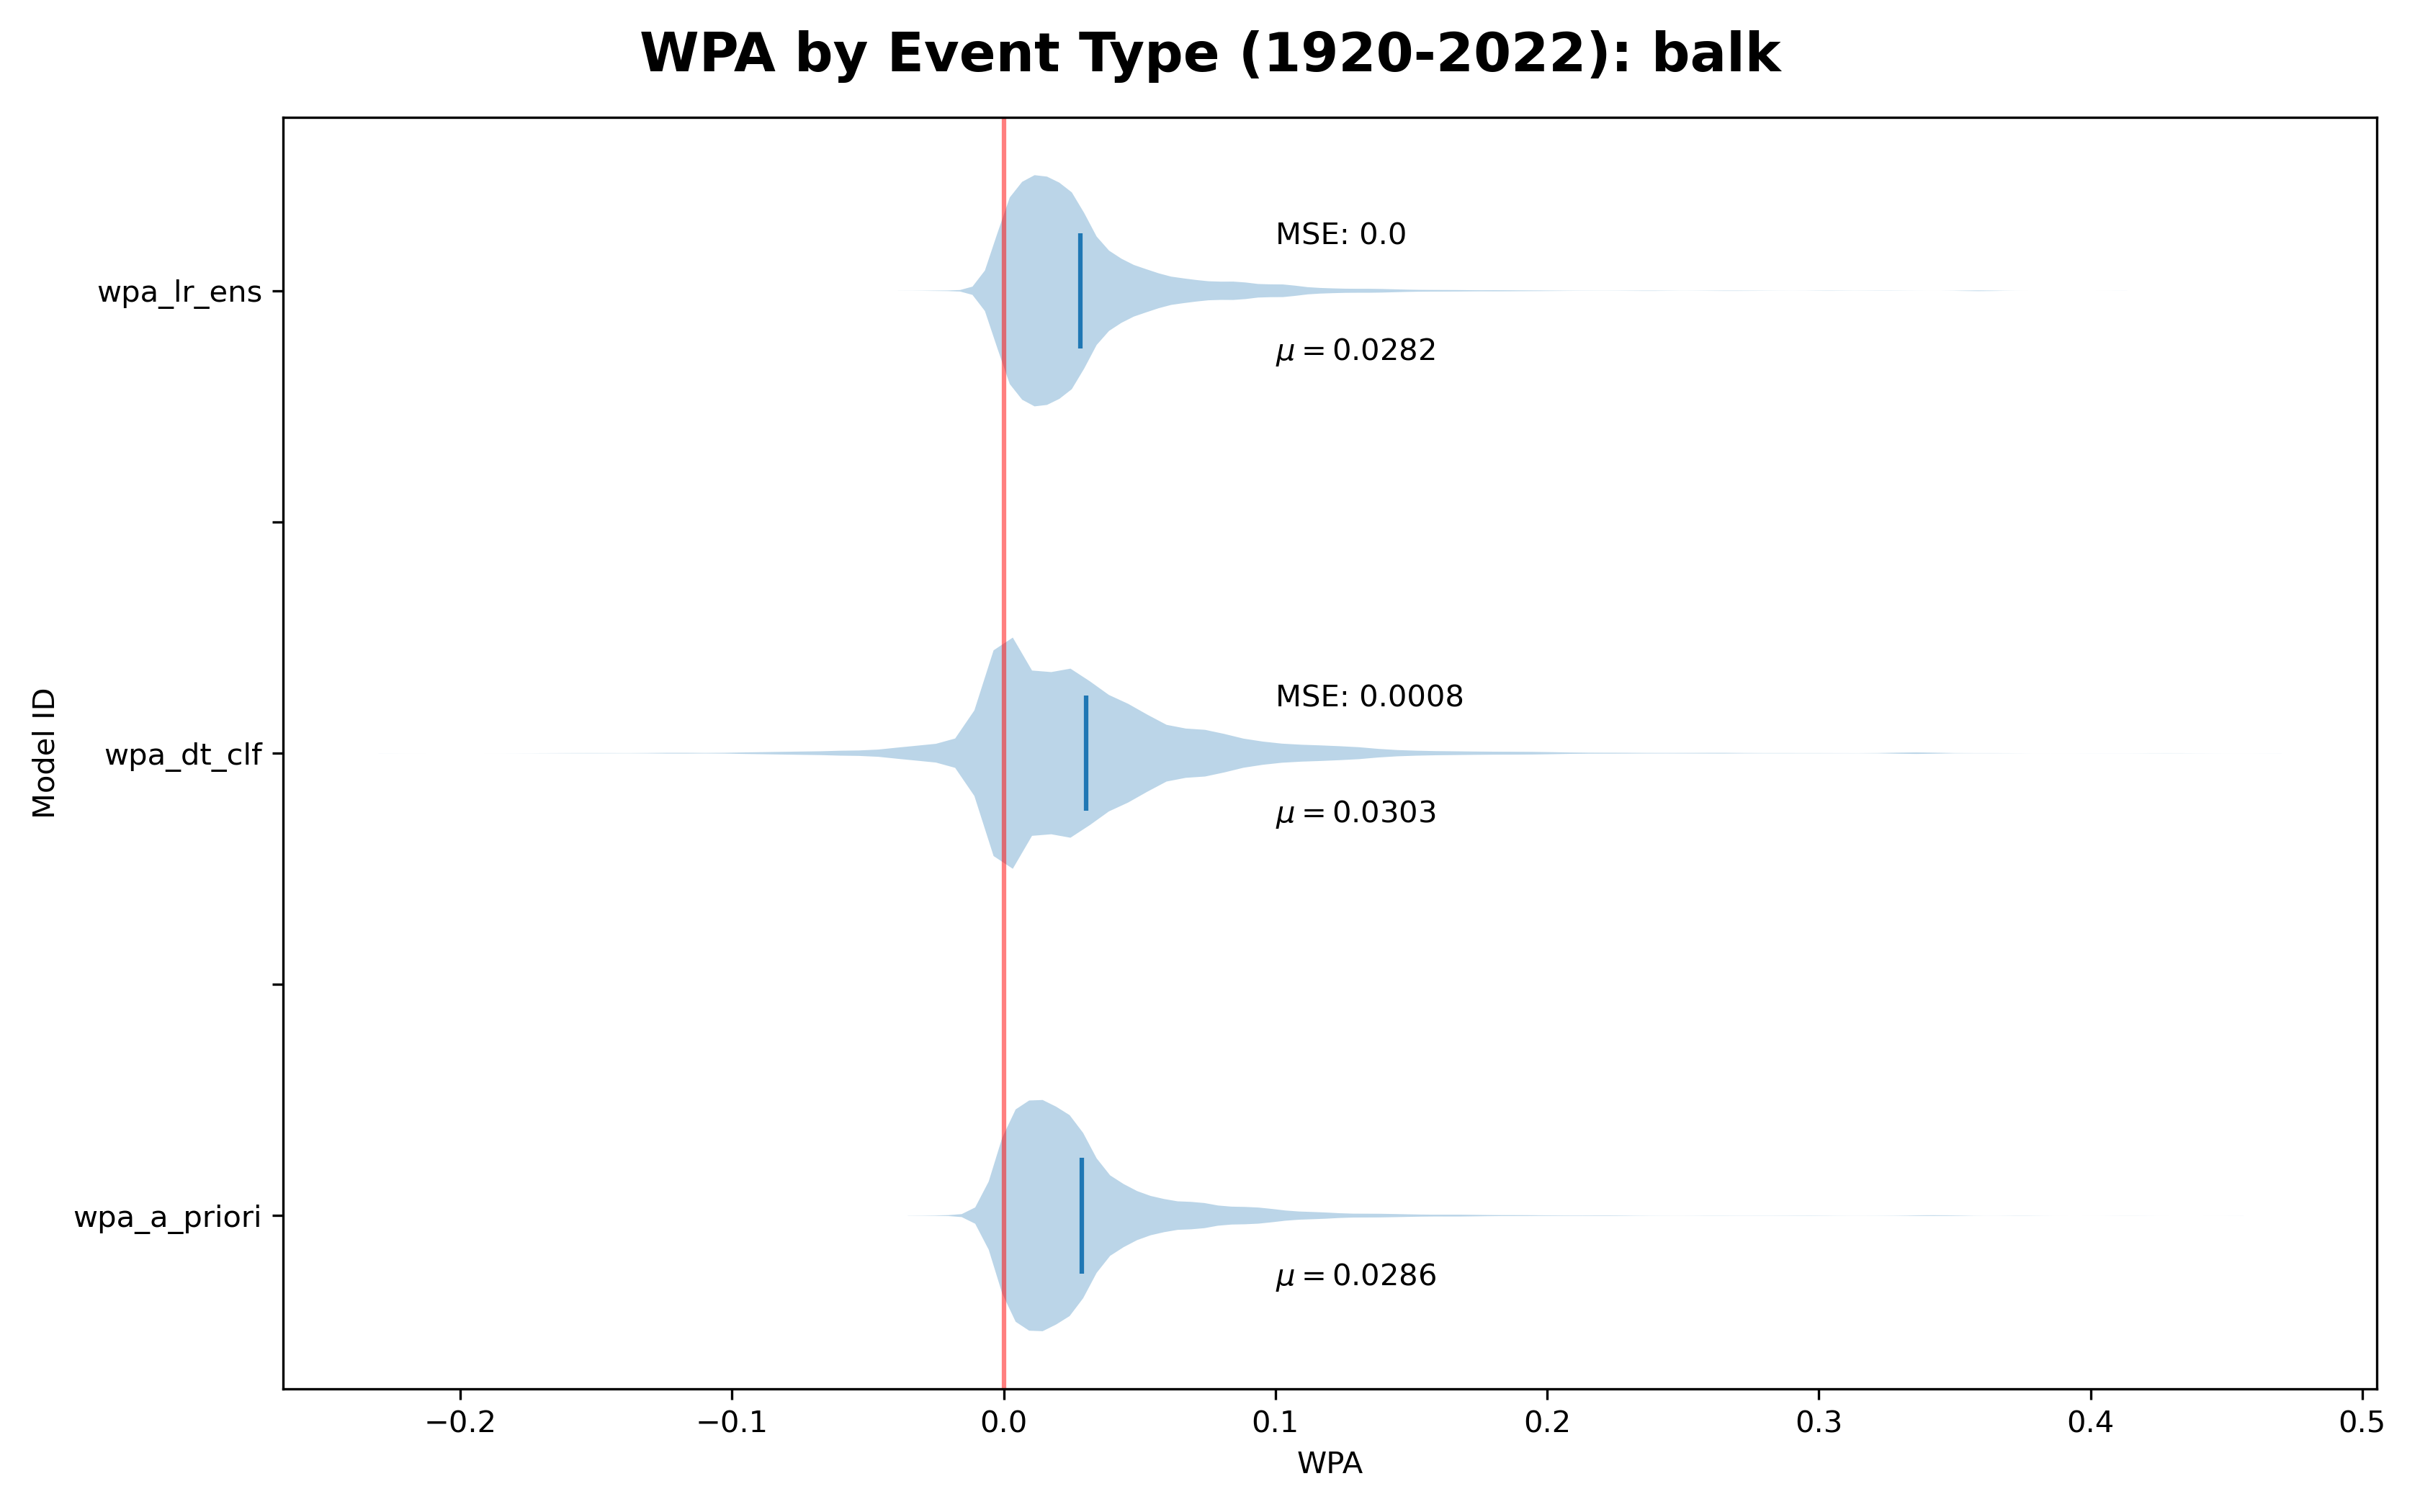

Defensive indifference:

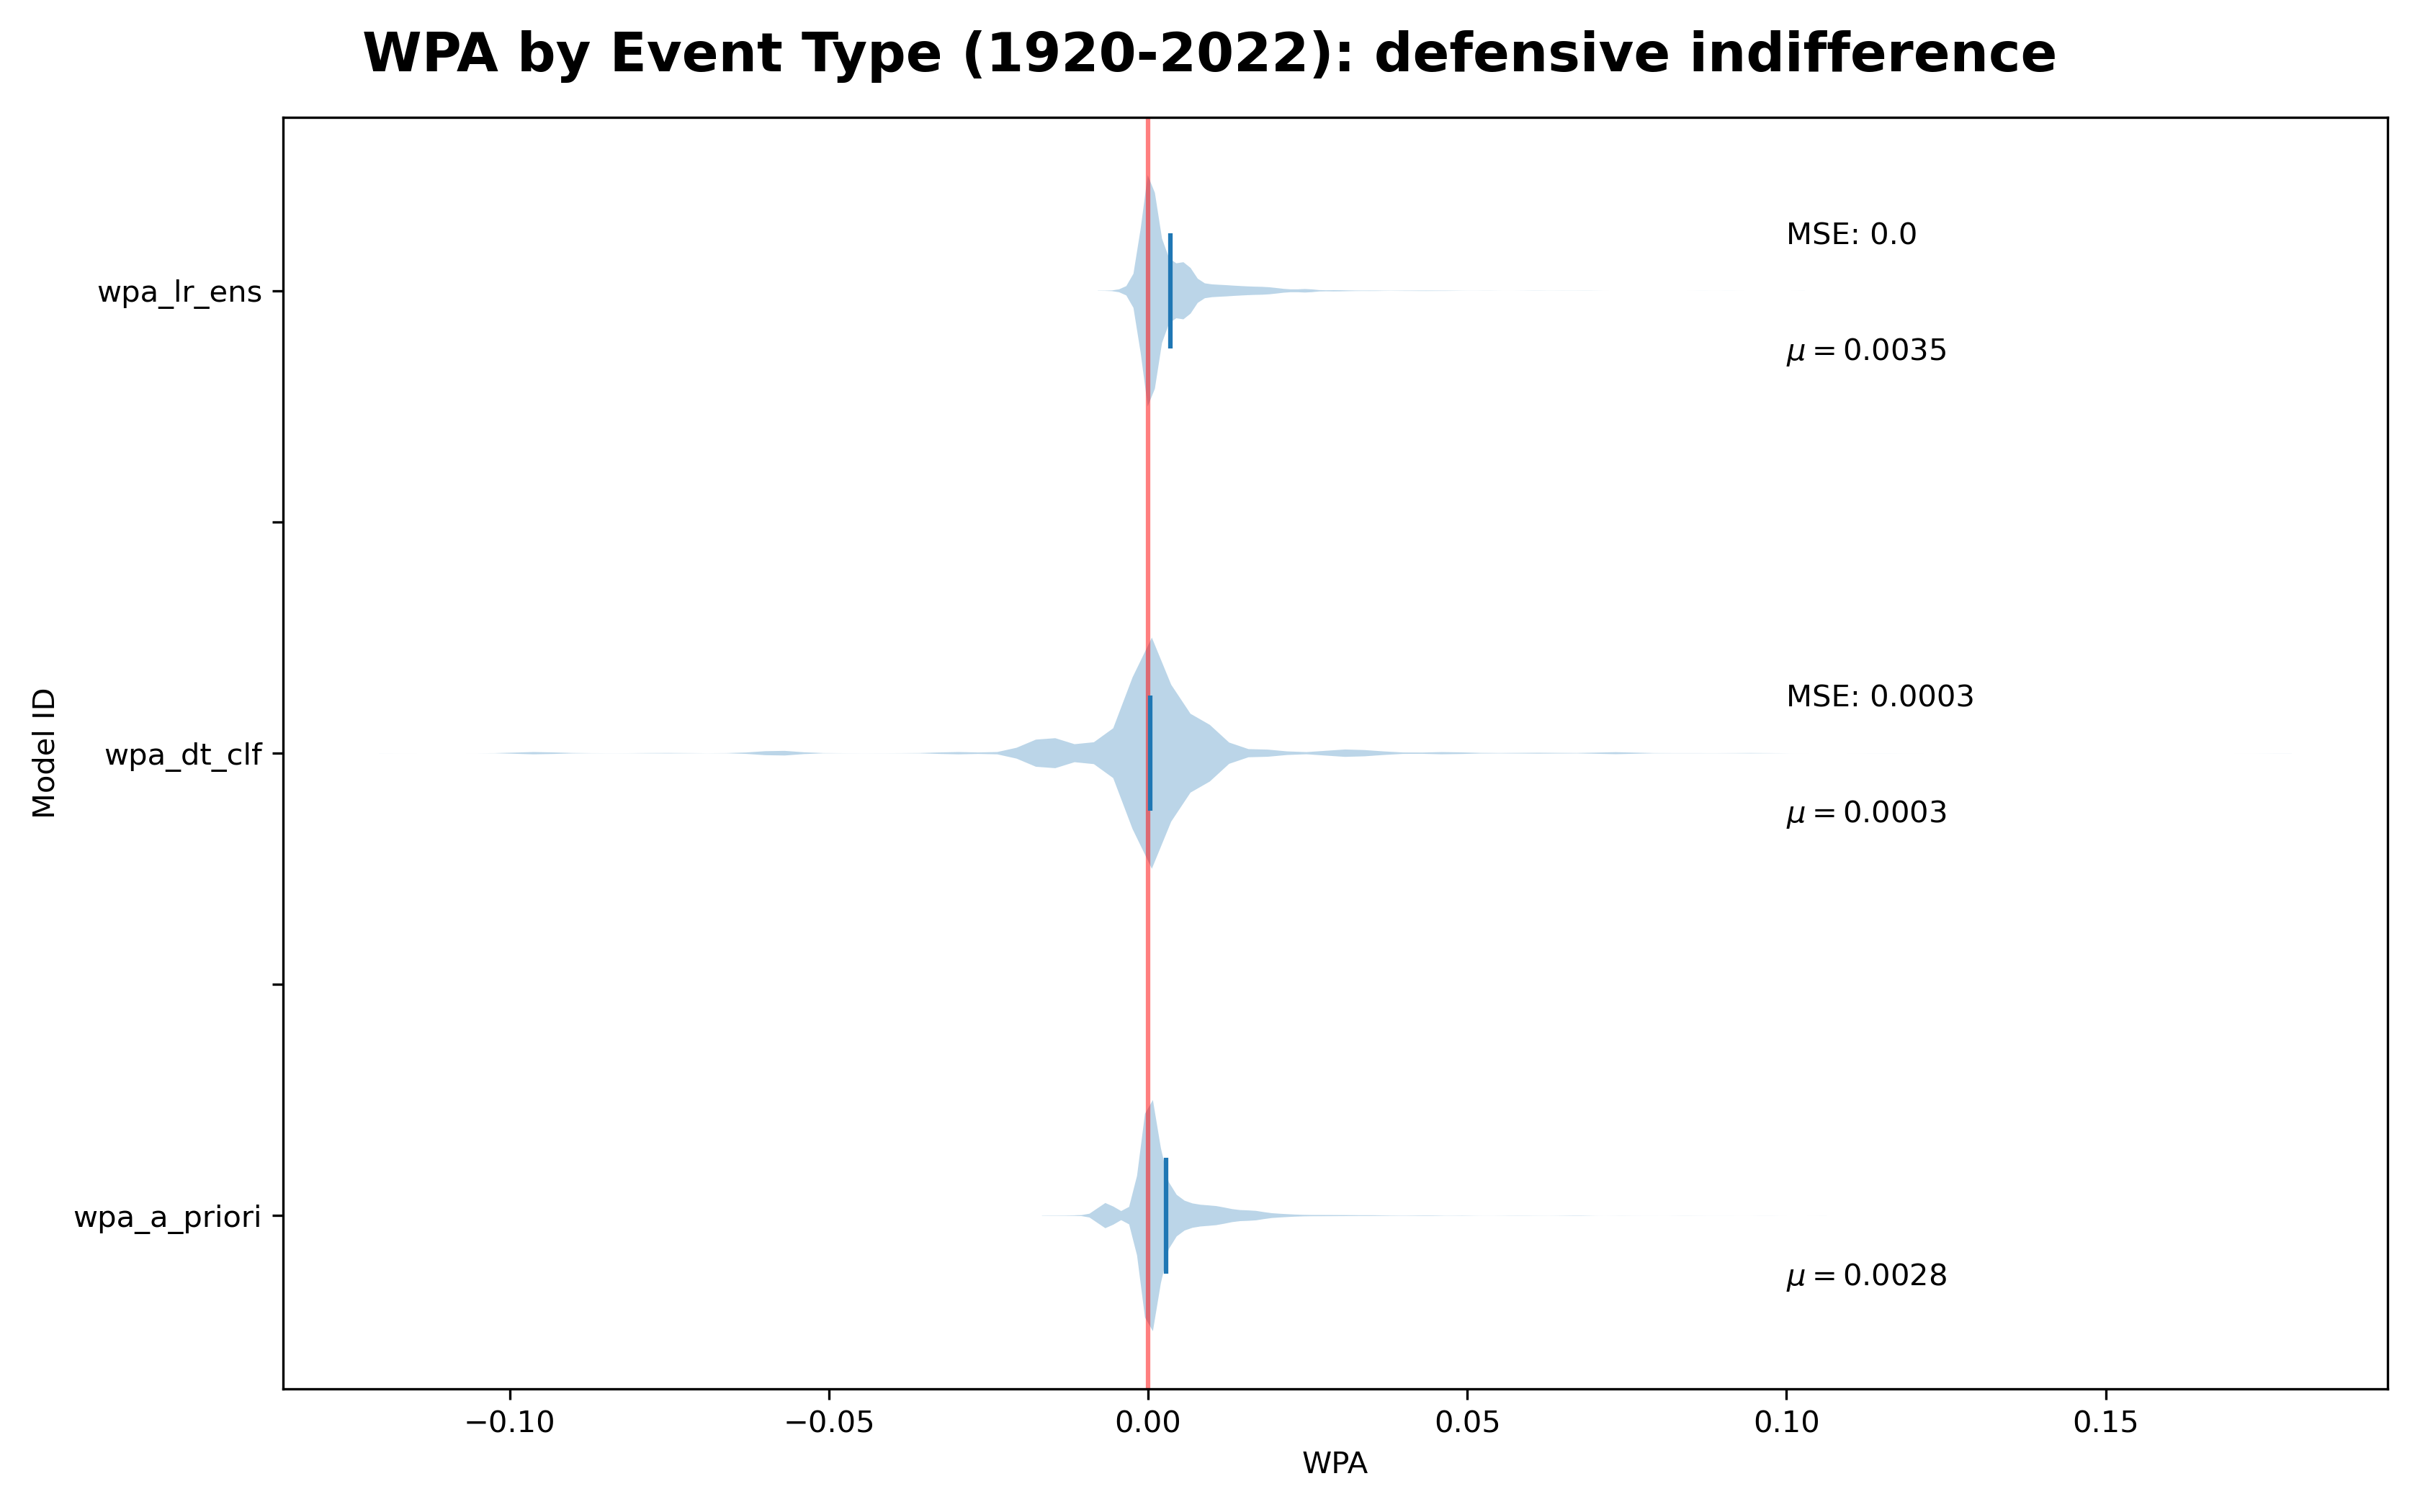

Other advance:

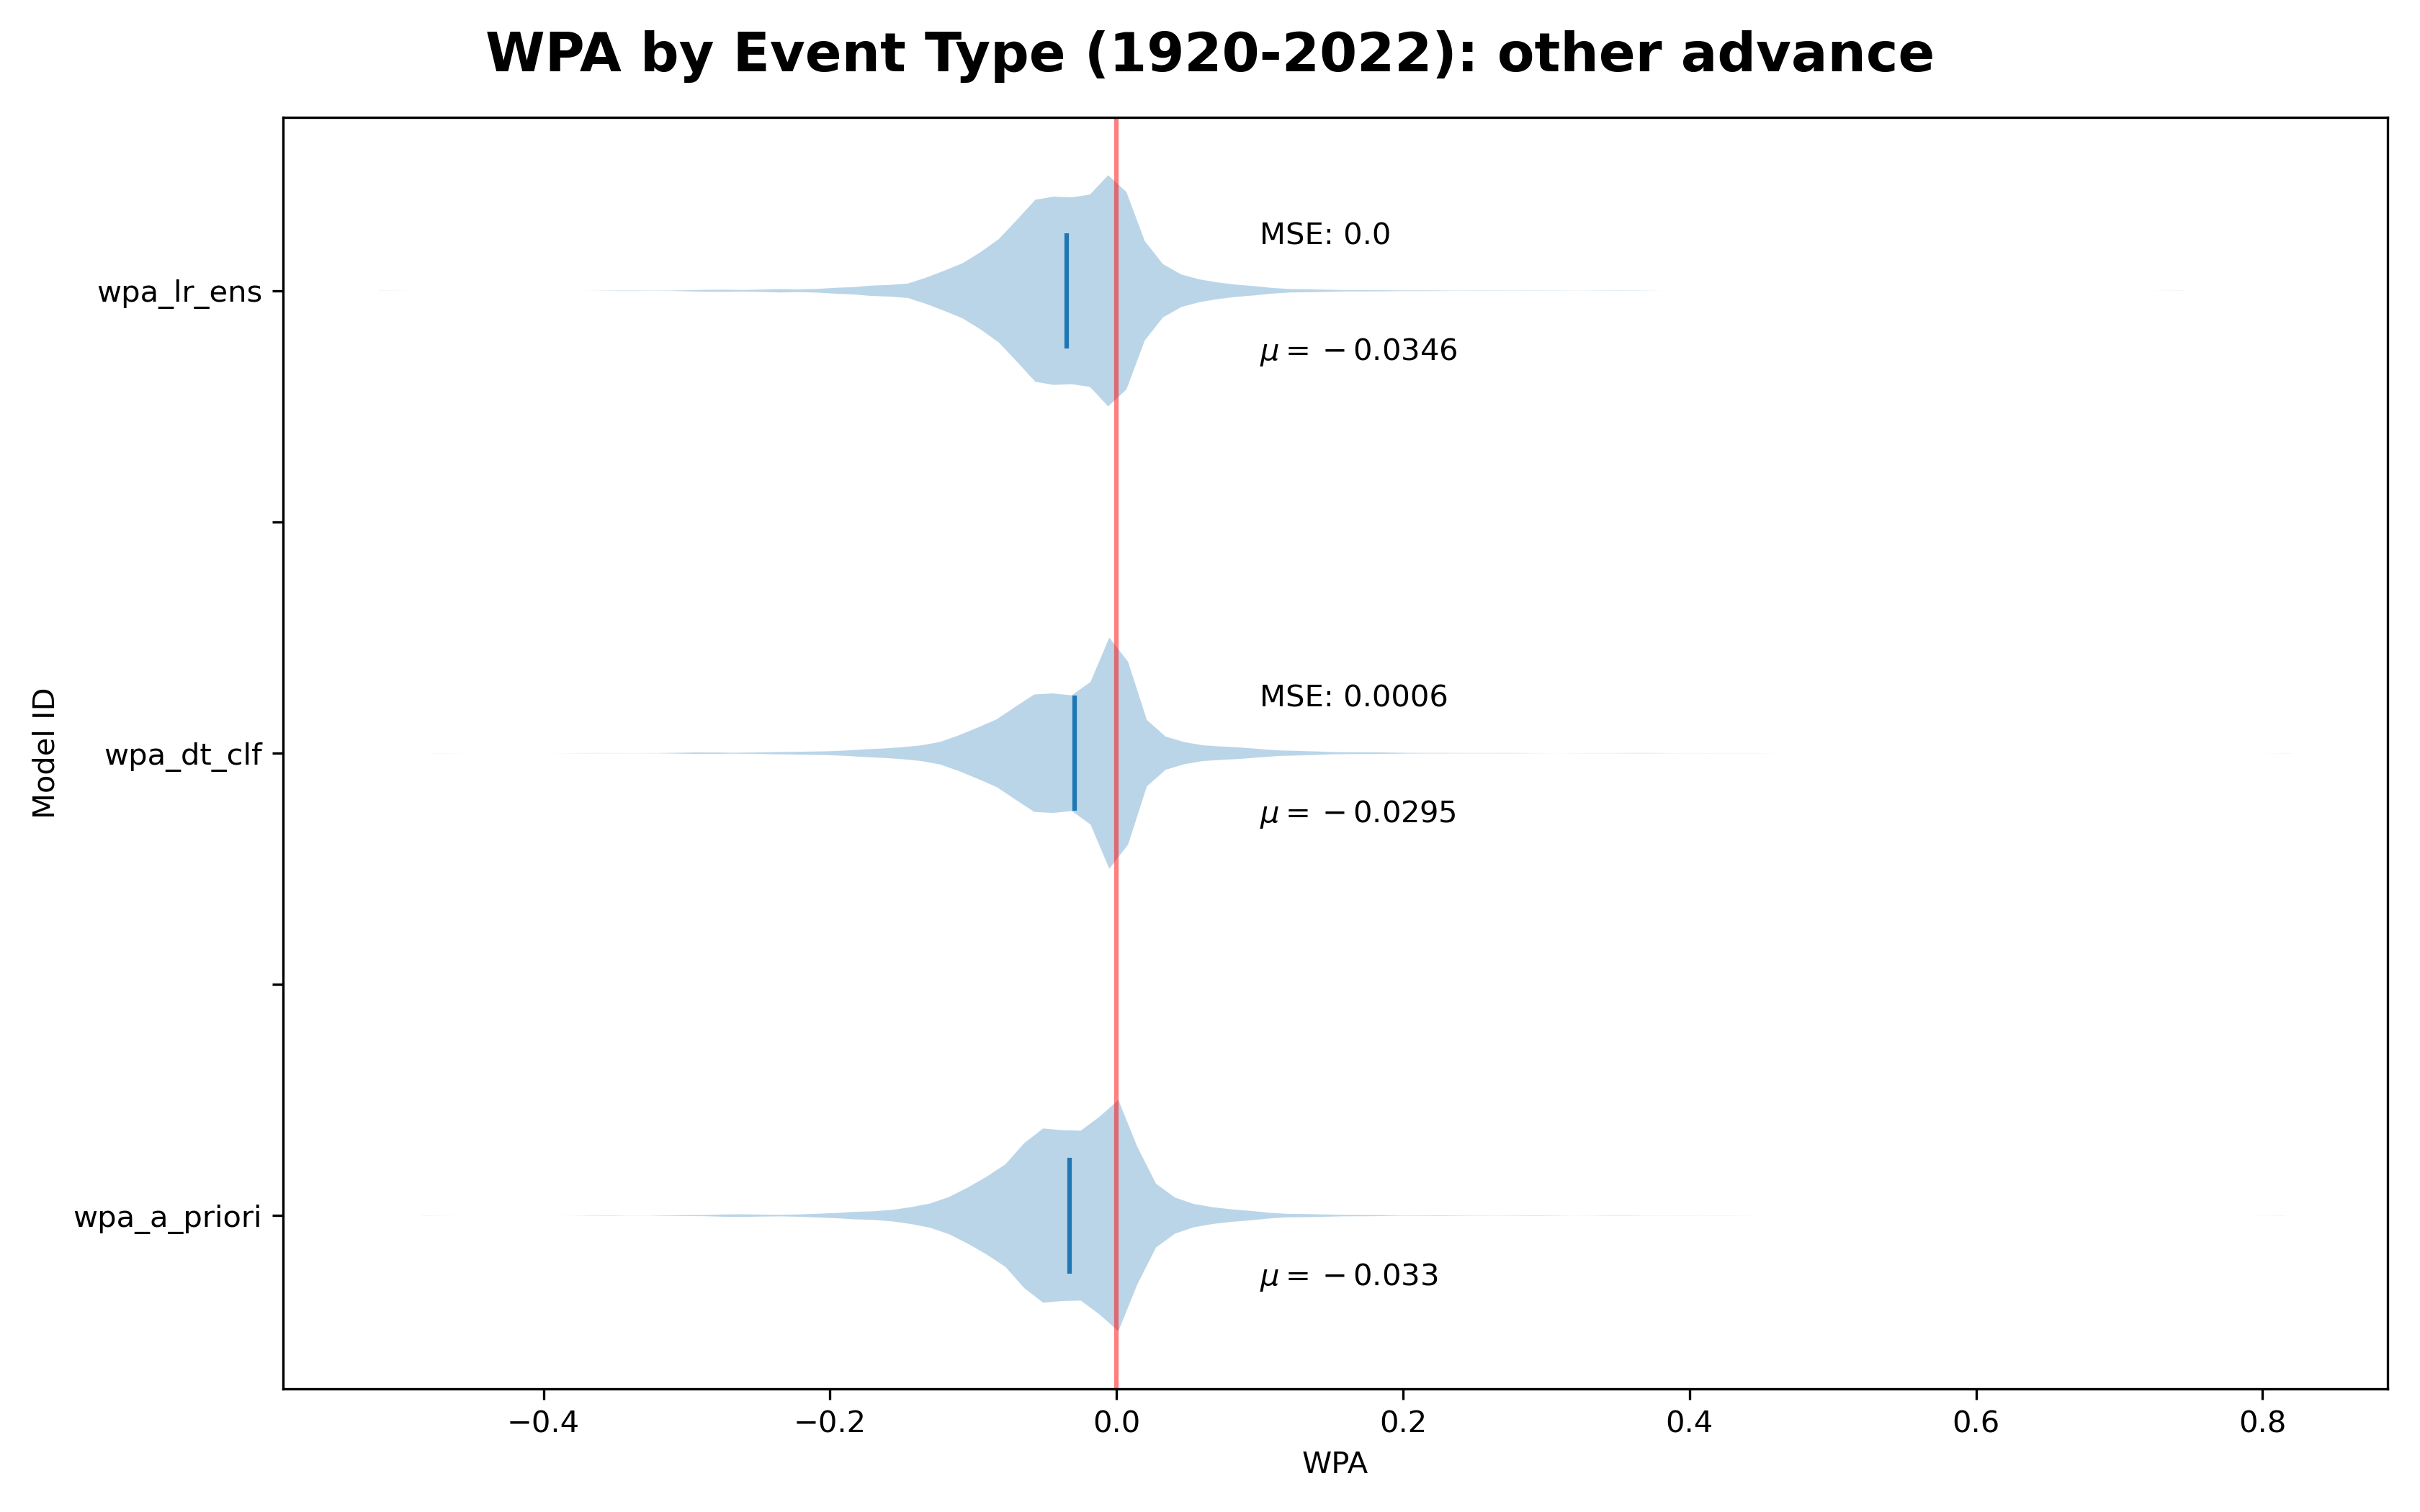

Strikeout:

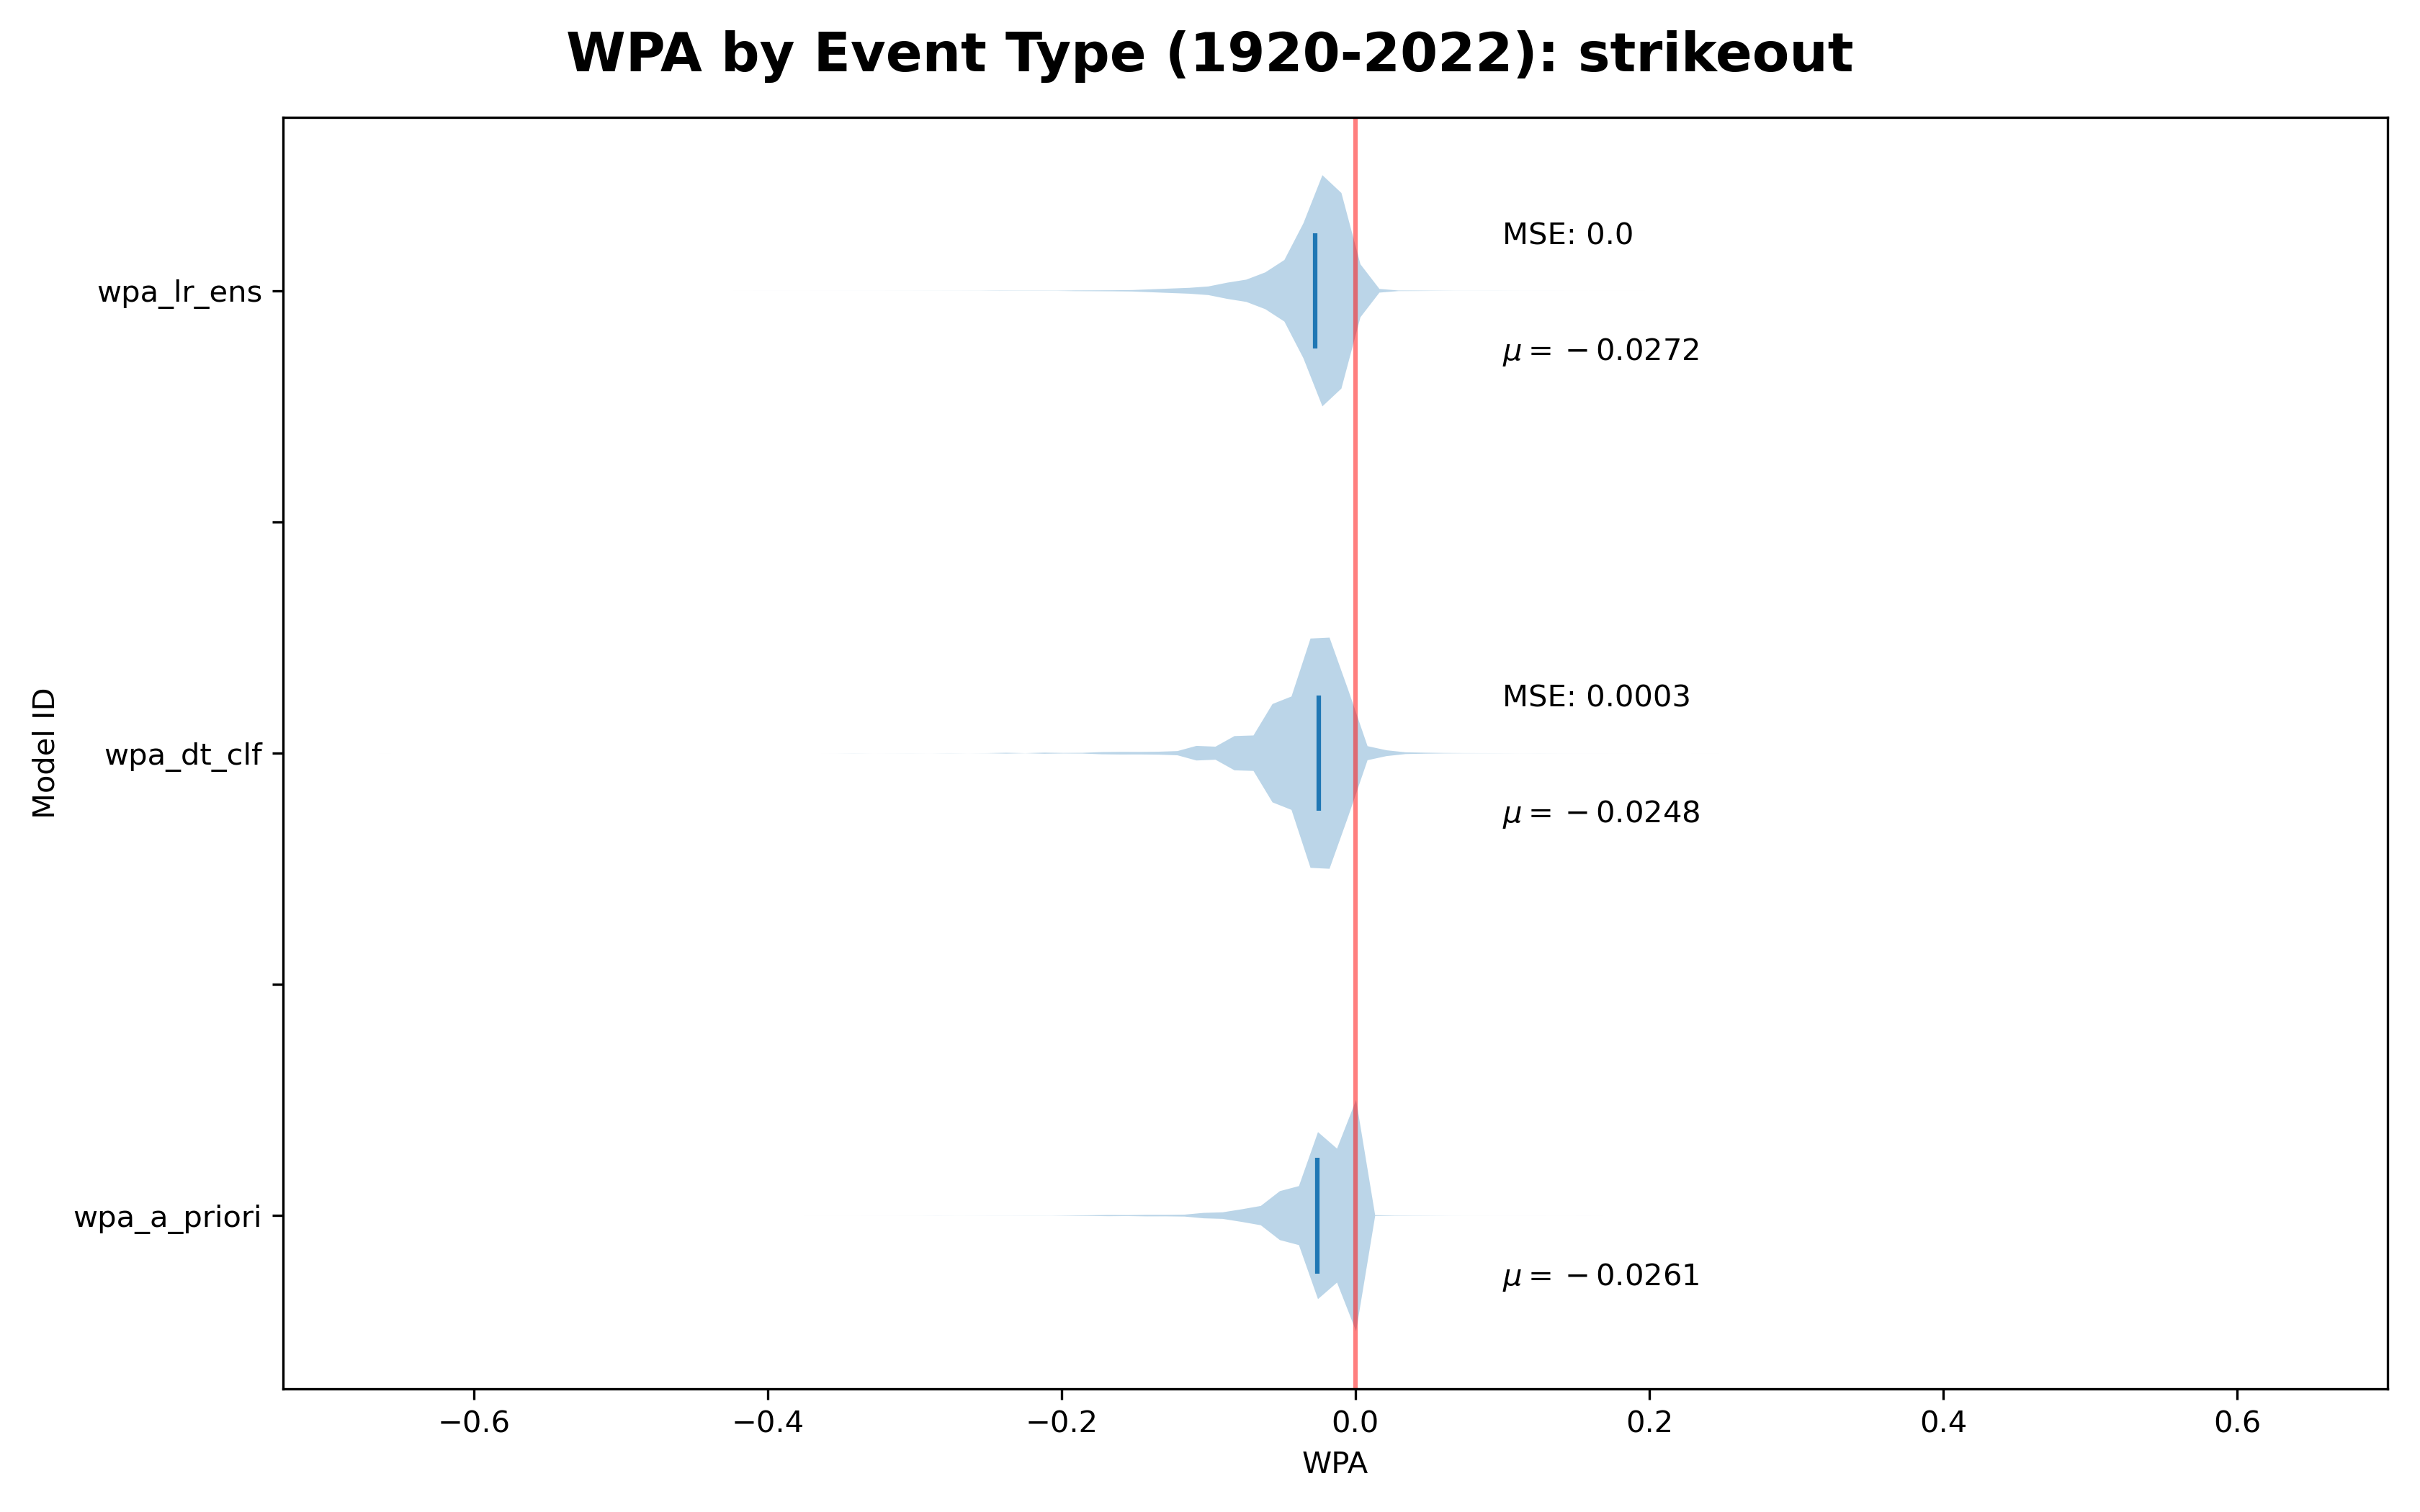

Generic out:

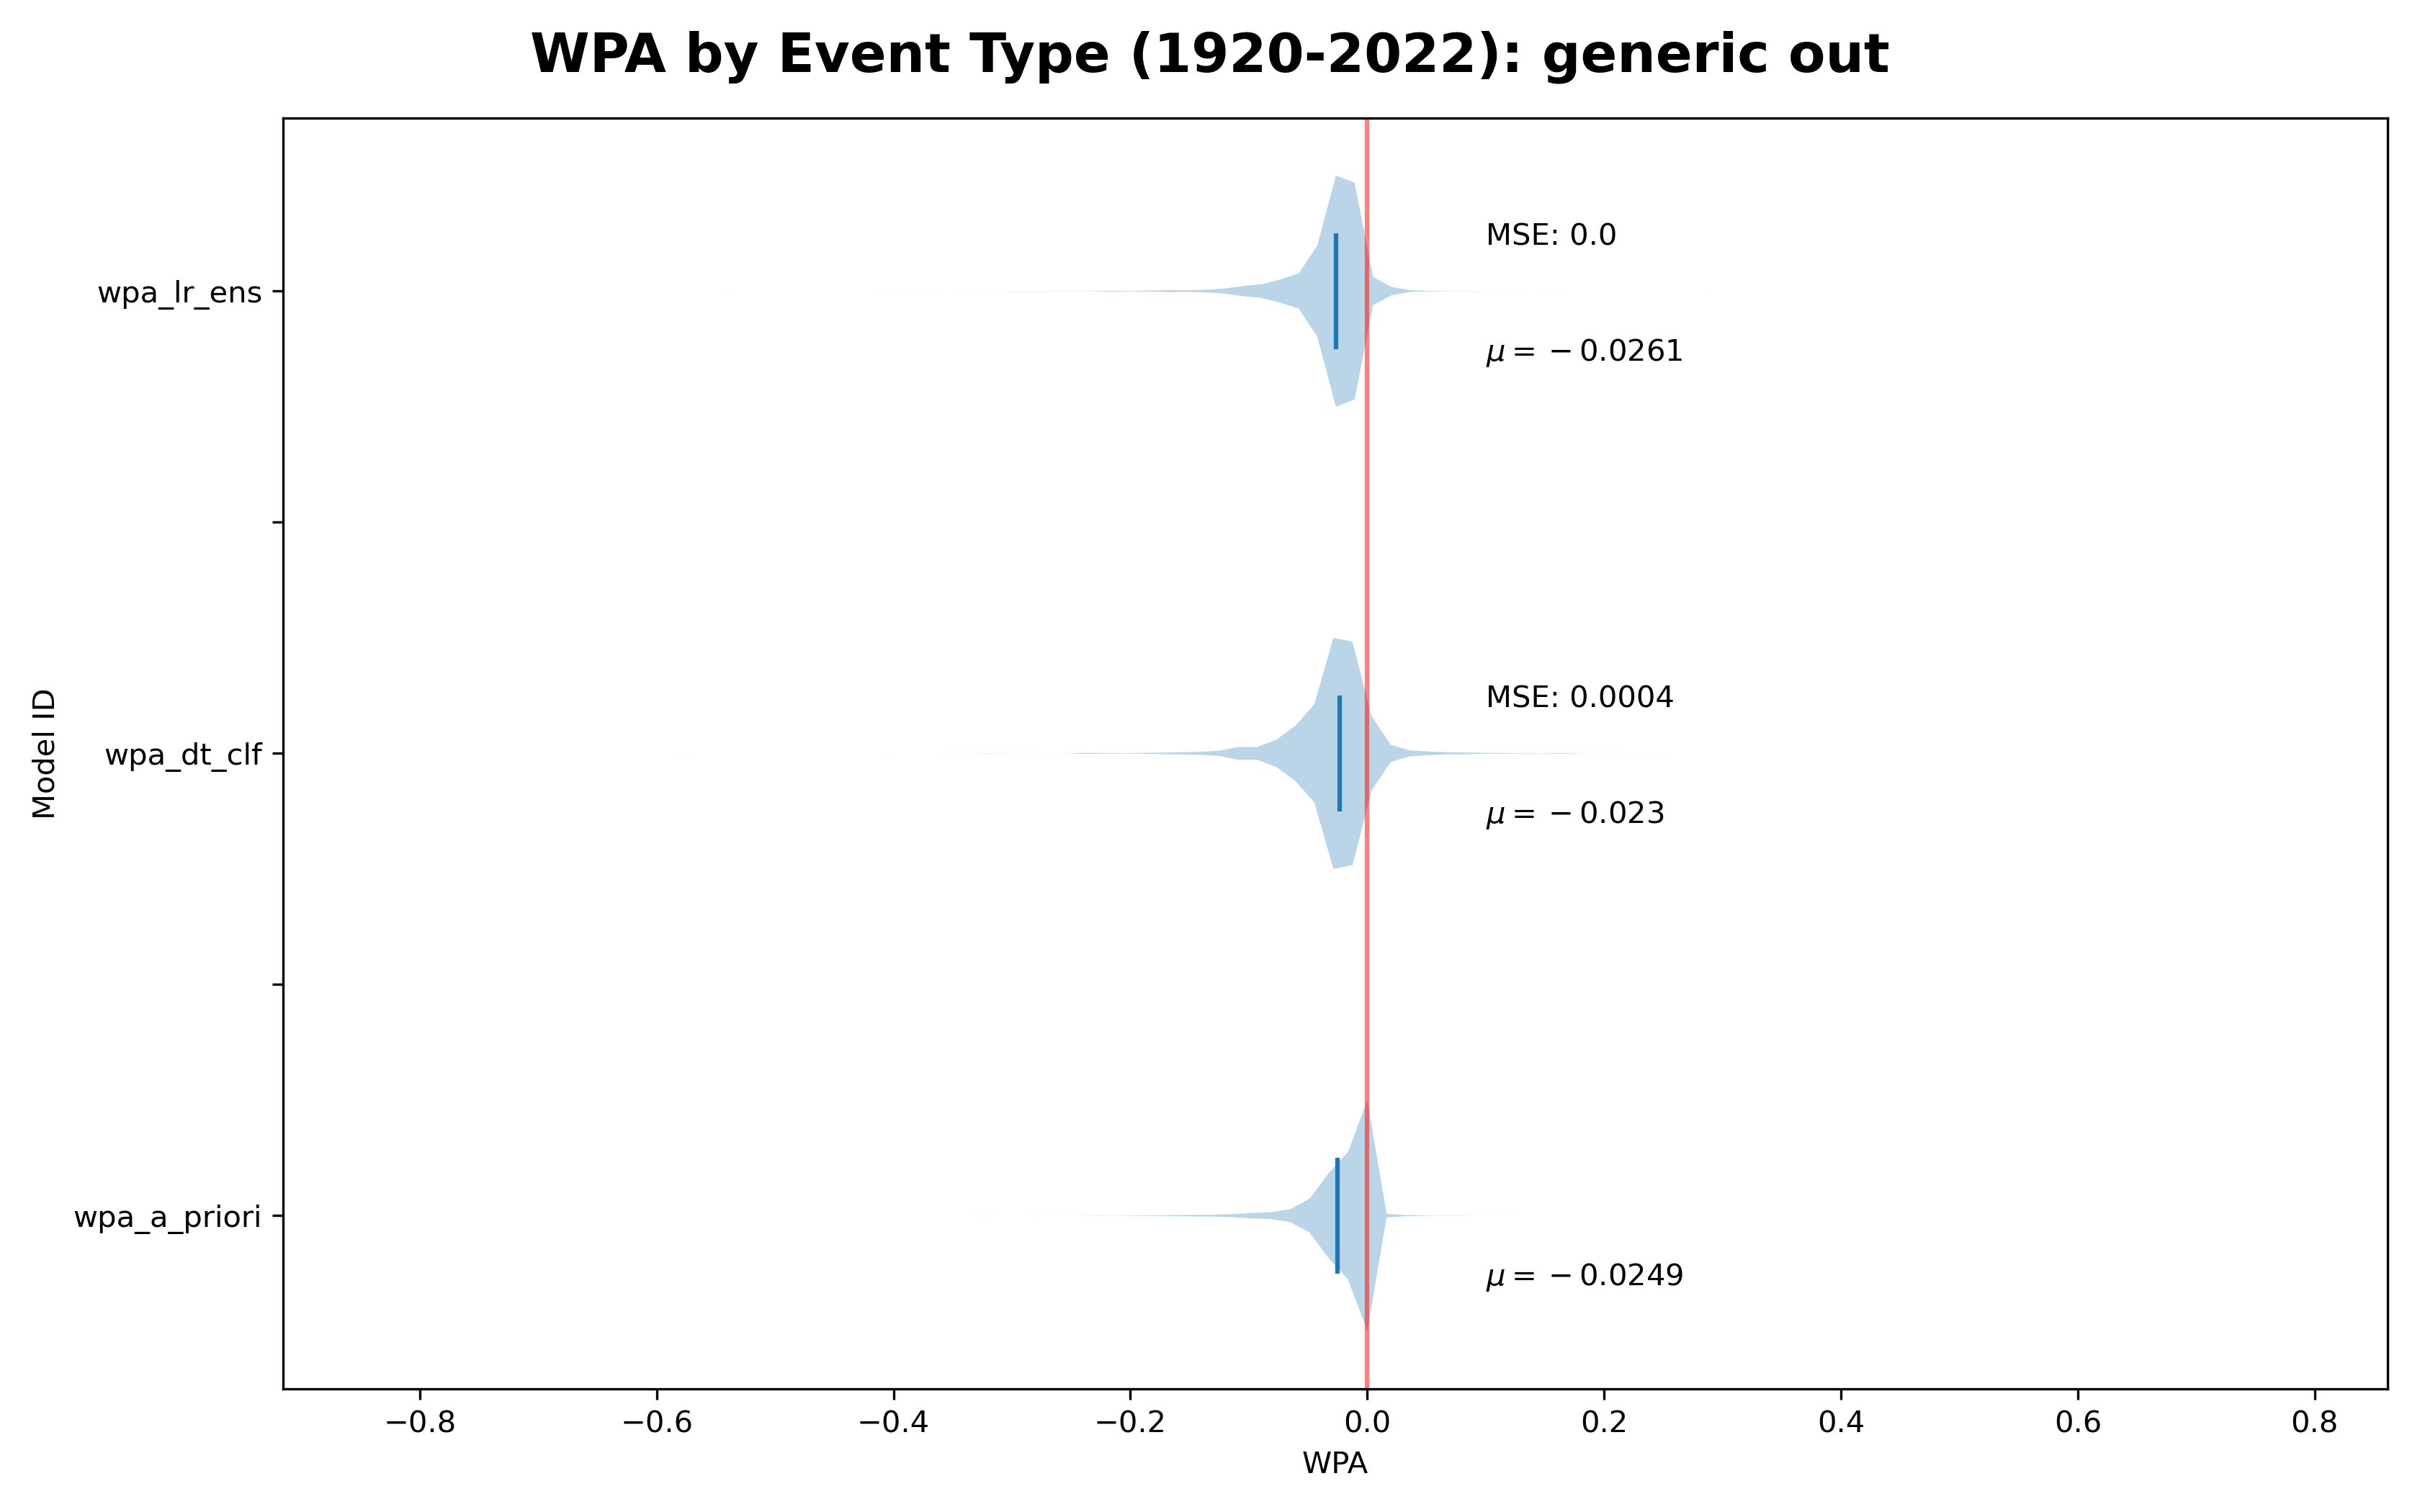

Caught stealing:

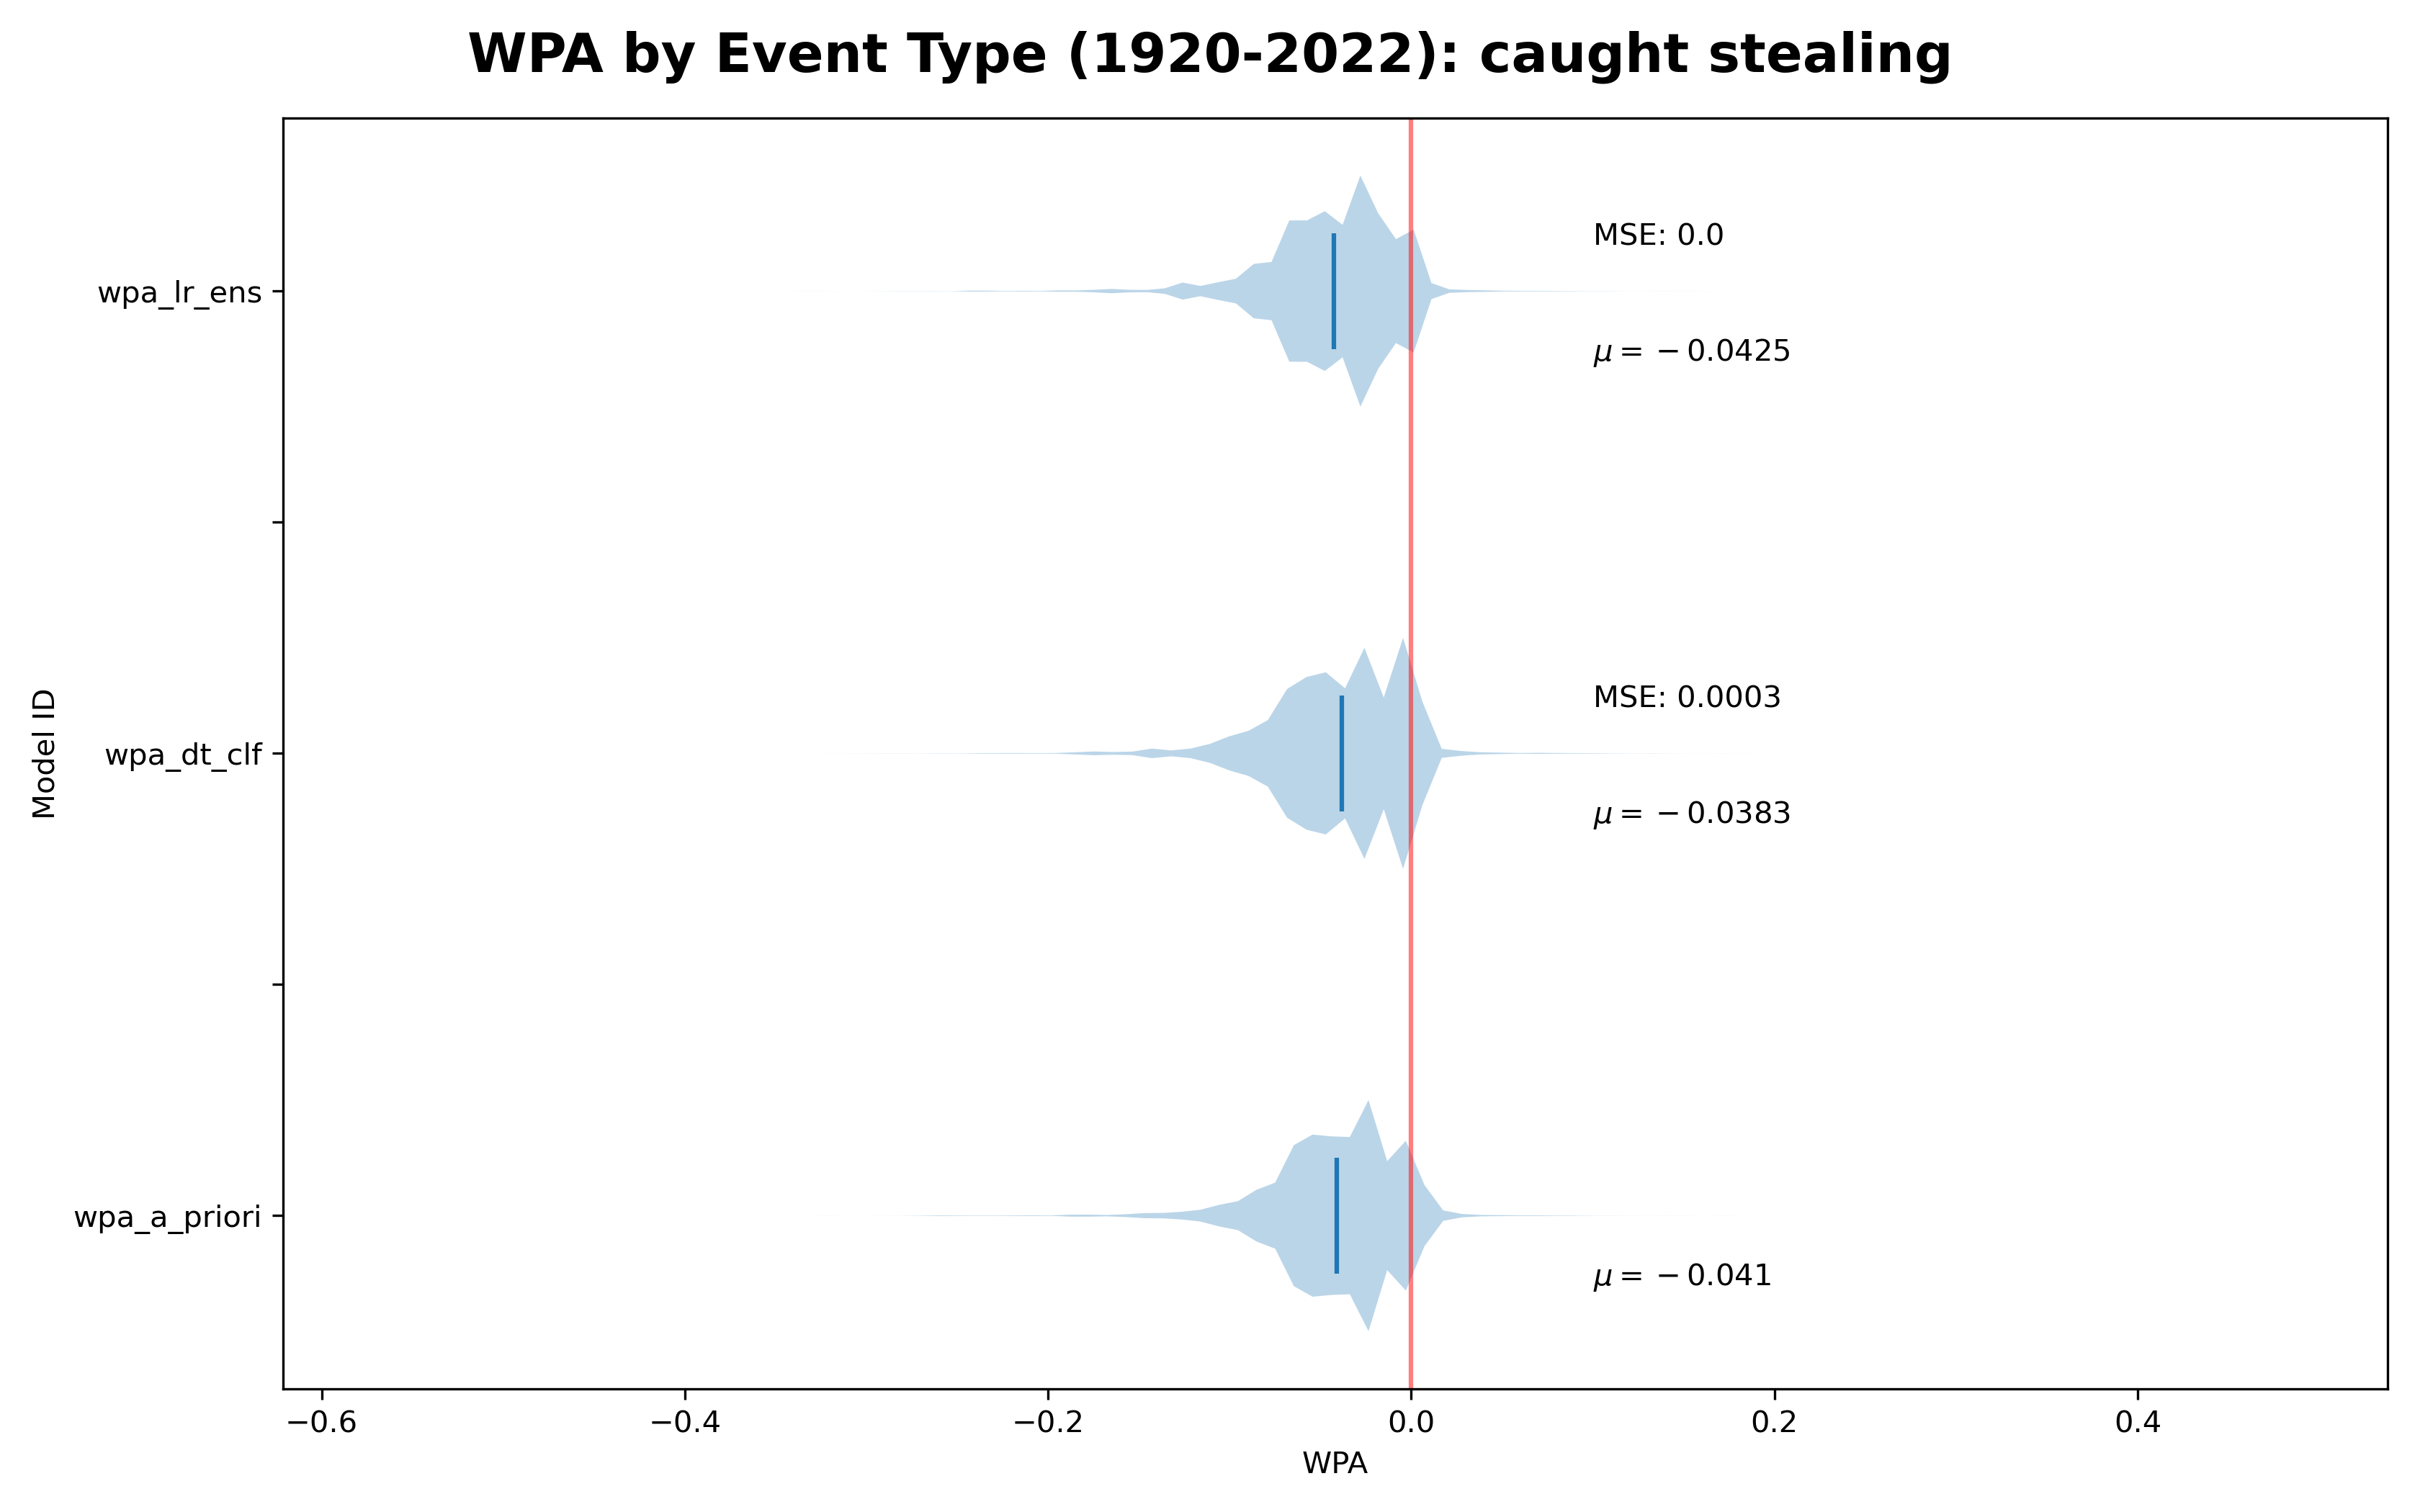

Pickoff:

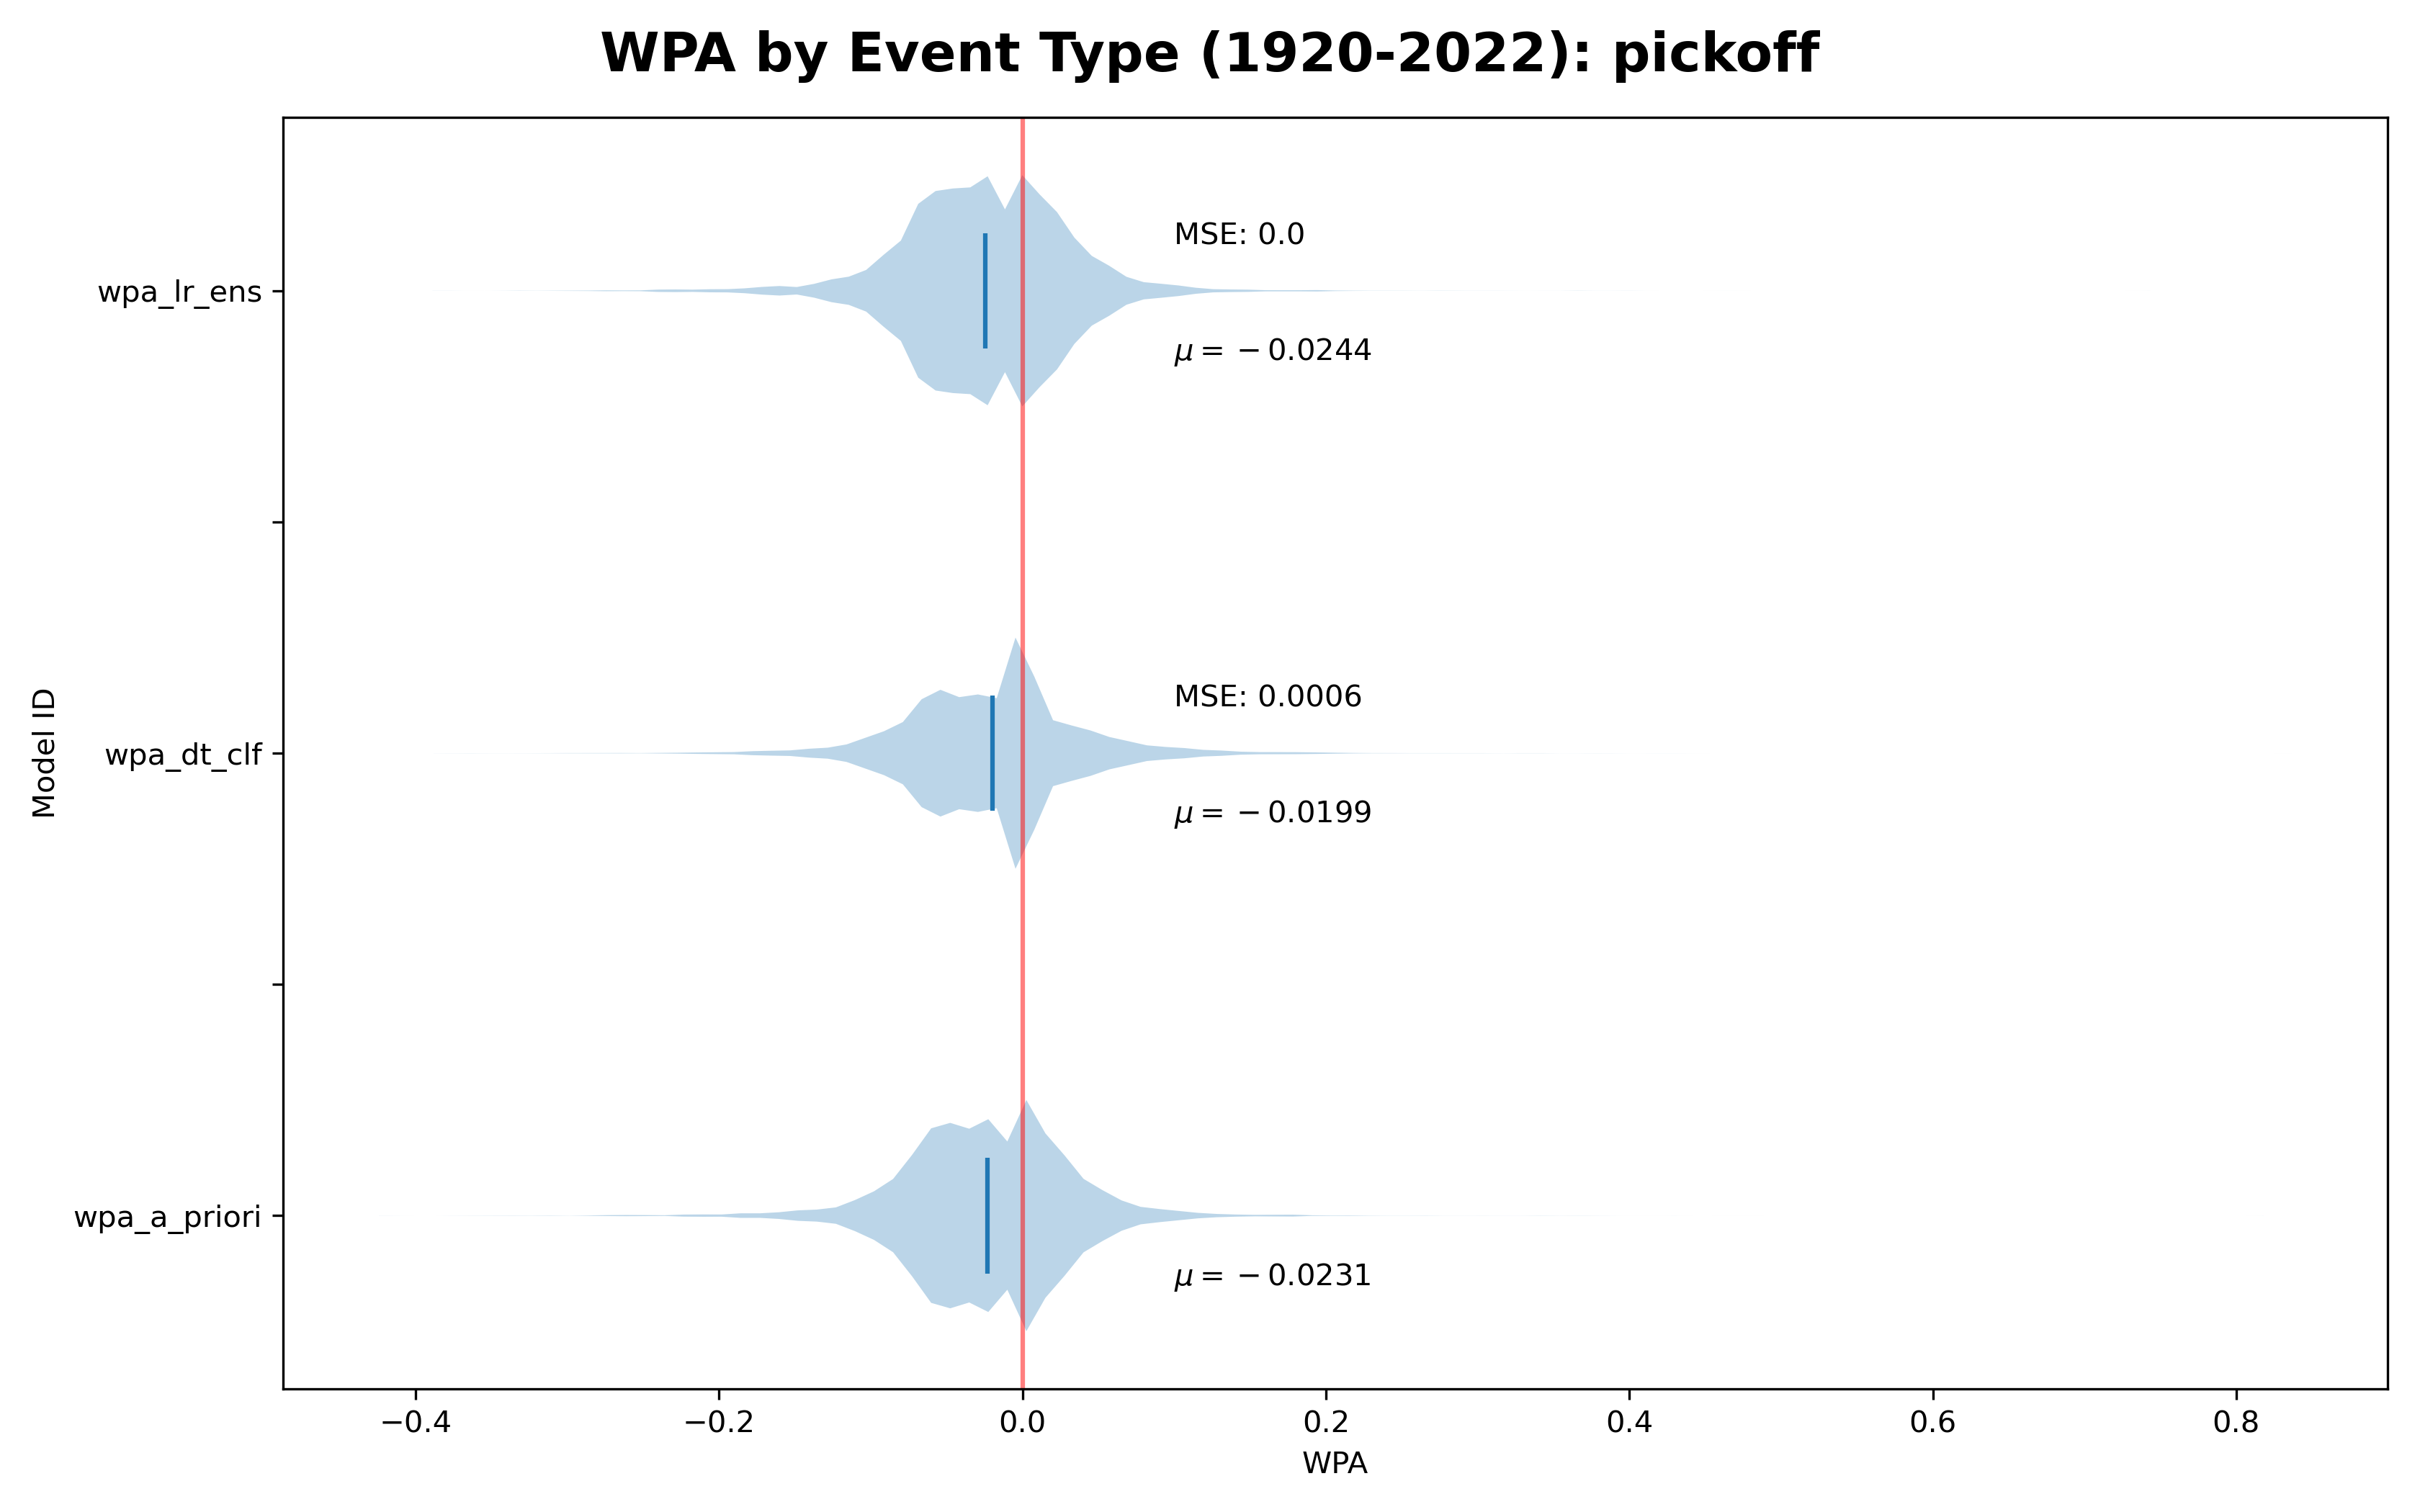

Fielder's choice:

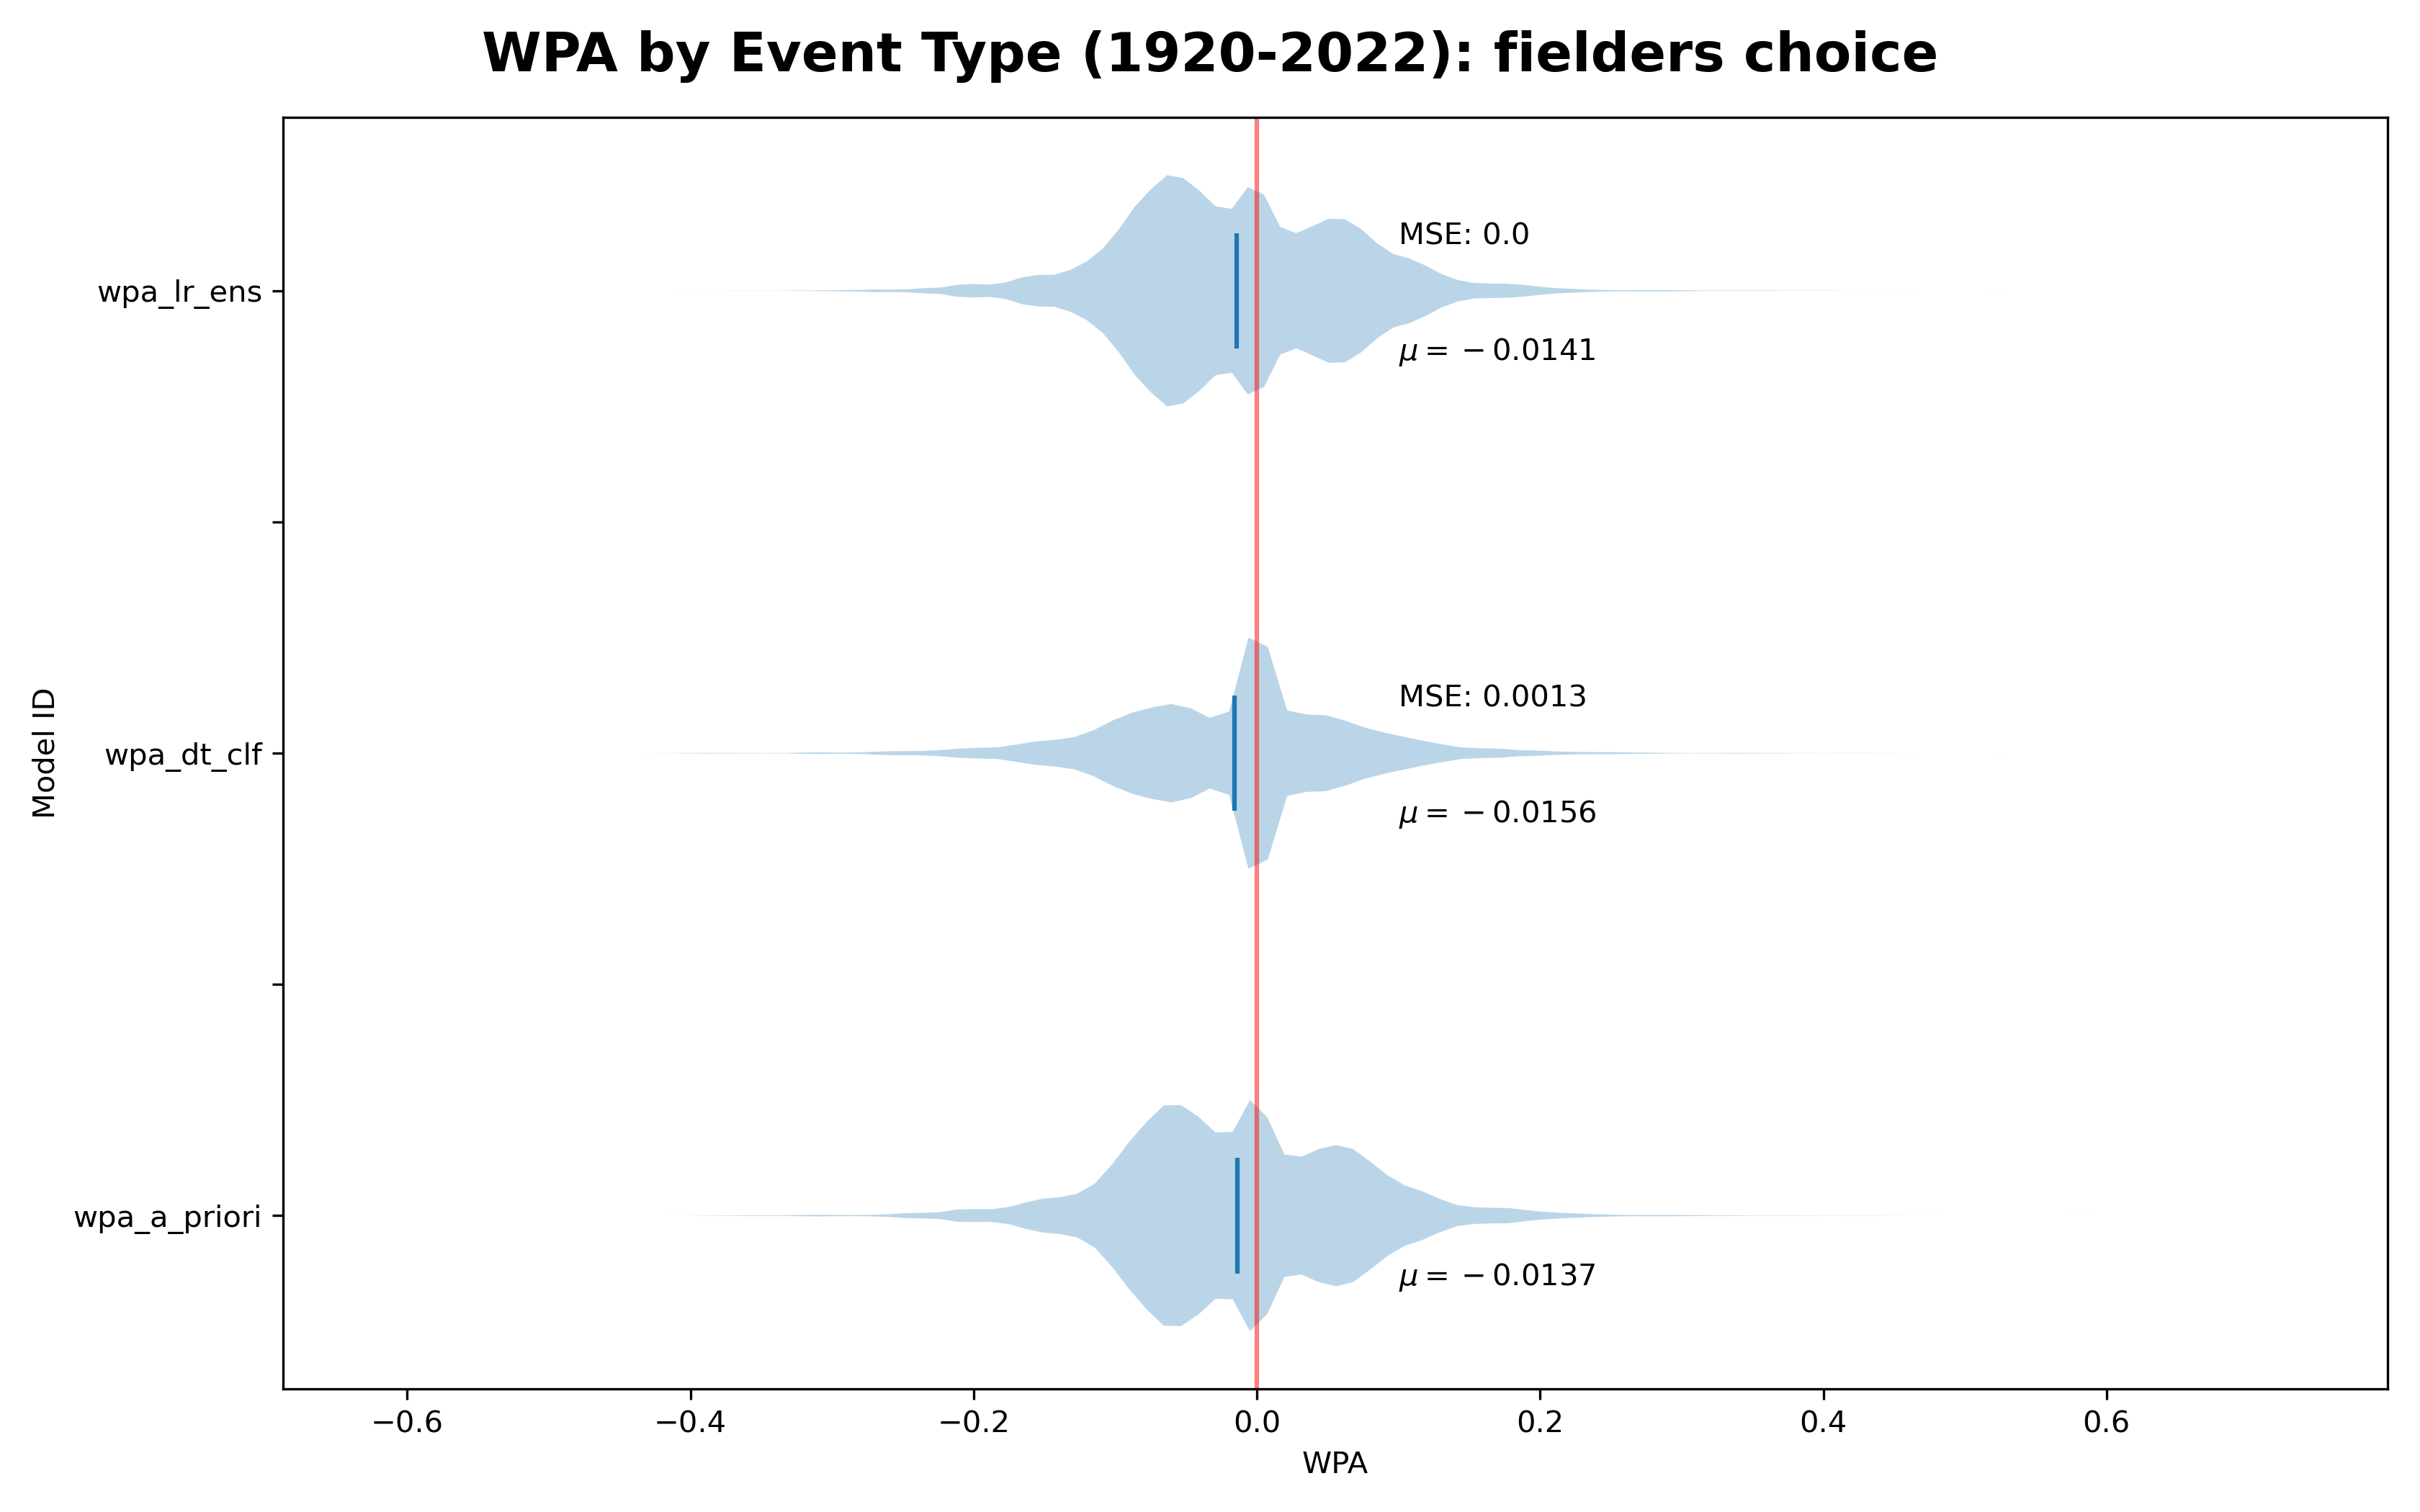

In every case, the logistic regression ensemble produces a distribution of WPA that is equal to or better than that of the decision tree classifier.

## 6 Applying Model

Having demonstrated a pair of feasible models for WE/WPA, let us apply them to answer some other questions of interest.

### 6.1 Pitching for 2010 Season

We apply the models to measure the relative performance of pitchers for the 2010 season.

In [19]:
# assign responsibility based on events directly related to pitcher
p_events = ['balk','double','generic out','hit by pitch','home run','other advance','pickoff','single','strikeout','triple','walk','wild pitch']

m0 = (df_slice['event_type'].isin(p_events)) & (df_slice['season']==2010)
df_grp2 = df_slice[['result_pitcher_id','wpa_dt_clf']].loc[m0].groupby(['result_pitcher_id']).sum()

# aggregate predicted values from lr_ens
temp = df_slice[['result_pitcher_id','wpa_lr_ens']].loc[m0].groupby(['result_pitcher_id']).sum()

#add predicted we/wpa
df_grp2 = df_grp2.merge(temp,
                        how='left',
                        left_index=True,
                        right_index=True)
df_grp2 = -1*df_grp2

del(temp, m0, p_events)

In [20]:
df_grp2.sort_values(by='wpa_lr_ens', ascending=False)

wpa_dt_clf  wpa_lr_ens
result_pitcher_id                        
hernf002             6.313288    7.104410
bellh001             5.149739    6.995915
hallr001             5.510850    6.251101
sorij001             4.268985    5.808426
sorir001             3.986816    5.737230
...                       ...         ...
hofft001            -2.999805   -2.484440
mortc002            -2.444639   -2.521096
rowlr002            -2.889080   -2.553752
millk004            -3.223795   -2.811779
felds001            -3.167800   -2.935092

[635 rows x 2 columns]

With some exceptions, these results broadly agree with the Baseball Reference figures.

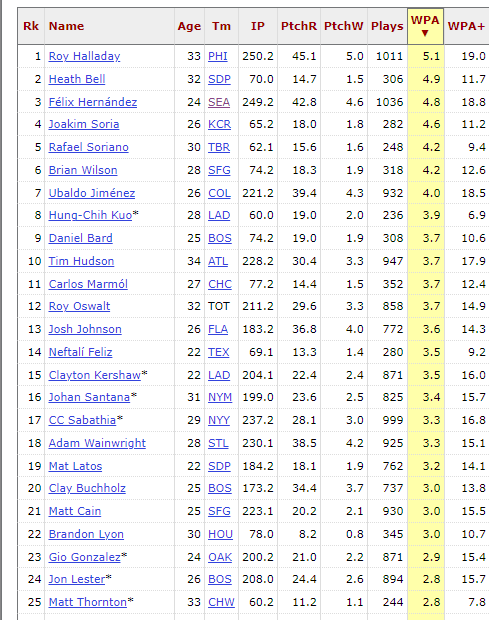

### 6.2 Left/Right Matchups

The 2010 season occurred well before the introduction of the “three-batter rule” that limits managers options for pitching changes. Left-handed and right-handed specialists emerged as bullpen options, typically only facing one batter in a high leverage, late game situations. This topic deserves a separate, detailed analysis, but we can look at the WPA distributions for left/right matchups and make some broad generalizations.



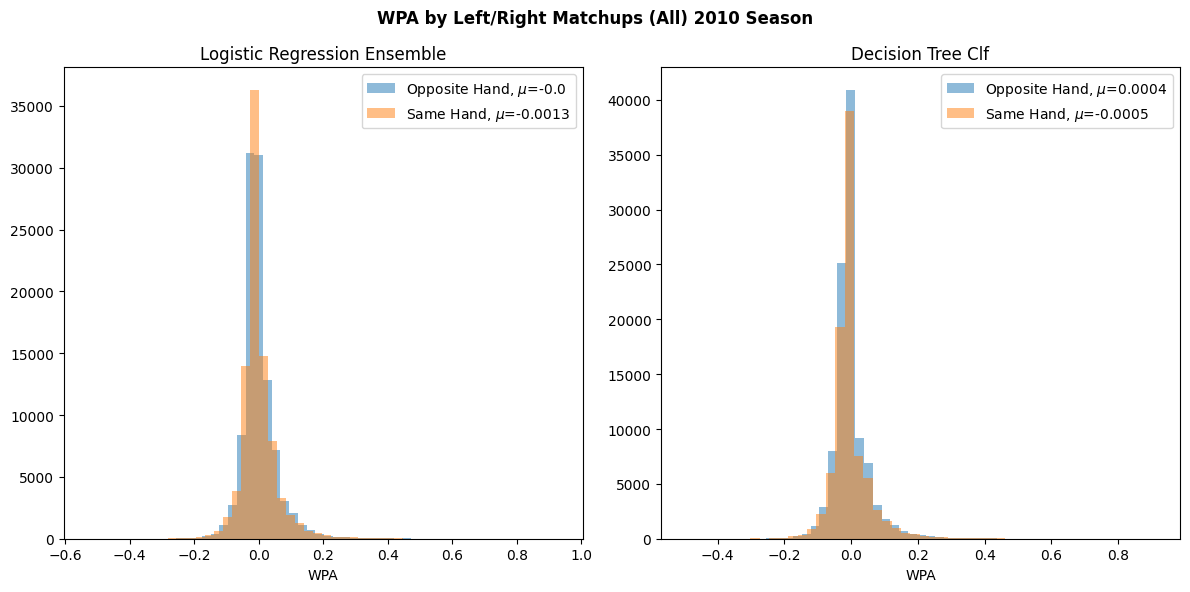

In [55]:
m0 = df_slice['batter_hand']!=df_slice['pitcher_hand']

fig = plt.figure(figsize=(12,6), tight_layout=True)
fig.suptitle('WPA by Left/Right Matchups (All) 2010 Season', fontweight='bold')
ax0 = fig.add_subplot(1,2,1)
ax0.hist(df_slice['wpa_lr_ens'].loc[m0],bins=50,density=False,alpha=0.5);
ax0.hist(df_slice['wpa_lr_ens'].loc[~m0],bins=50,density=False,alpha=0.5);
ax0.set_title('Logistic Regression Ensemble')
ax0.set_xlabel("WPA")
ax0.legend([rf"Opposite Hand, $\mu$={df_slice['wpa_lr_ens'].loc[m0].mean().round(4)}",
            rf"Same Hand, $\mu$={df_slice['wpa_lr_ens'].loc[~m0].mean().round(4)}"])

ax1 = fig.add_subplot(1,2,2)
ax1.hist(df_slice['wpa_dt_clf'].loc[m0],bins=50,density=False,alpha=0.5);
ax1.hist(df_slice['wpa_dt_clf'].loc[~m0],bins=50,density=False,alpha=0.5);
ax1.set_title('Decision Tree Clf')
ax1.set_xlabel("WPA")
ax1.legend([rf"Opposite Hand, $\mu$={df_slice['wpa_dt_clf'].loc[m0].mean().round(4)}",
            rf"Same Hand, $\mu$={df_slice['wpa_dt_clf'].loc[~m0].mean().round(4)}"])

del(m0, fig, ax0, ax1)

Now look at situations where the score difference is +/- 3 runs and it is the sixth inning or later, i.e., high leverage situations.

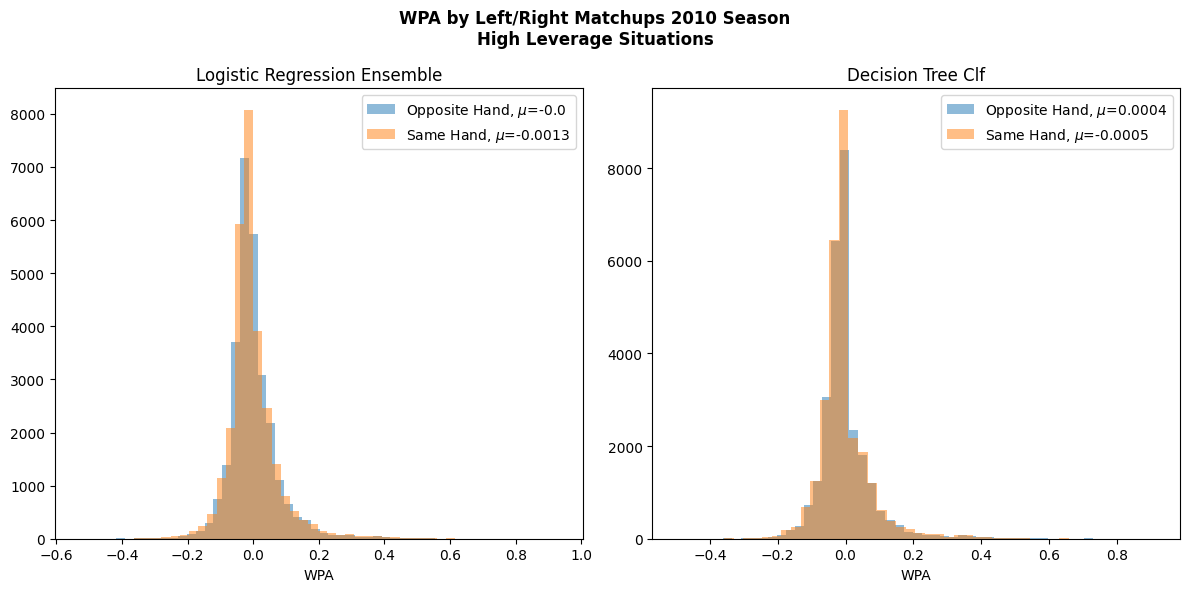

In [47]:
m0 = df_slice['batter_hand']!=df_slice['pitcher_hand']
m1 = (df_slice['score_diff'].abs()<=3)&(df_slice['inning']>=6)

fig = plt.figure(figsize=(12,6), tight_layout=True)
fig.suptitle('WPA by Left/Right Matchups 2010 Season\nHigh Leverage Situations', fontweight='bold')
ax0 = fig.add_subplot(1,2,1)
ax0.hist(df_slice['wpa_lr_ens'].loc[m1&m0],bins=50,density=False,alpha=0.5);
ax0.hist(df_slice['wpa_lr_ens'].loc[m1&~m0],bins=50,density=False,alpha=0.5);
ax0.set_title('Logistic Regression Ensemble')
ax0.set_xlabel("WPA")
ax0.legend([rf"Opposite Hand, $\mu$={df_slice['wpa_lr_ens'].loc[m0].mean().round(4)}",
            rf"Same Hand, $\mu$={df_slice['wpa_lr_ens'].loc[~m0].mean().round(4)}"])

ax1 = fig.add_subplot(1,2,2)
ax1.hist(df_slice['wpa_dt_clf'].loc[m1&m0],bins=50,density=False,alpha=0.5);
ax1.hist(df_slice['wpa_dt_clf'].loc[m1&~m0],bins=50,density=False,alpha=0.5);
ax1.set_title('Decision Tree Clf')
ax1.set_xlabel("WPA")
ax1.legend([rf"Opposite Hand, $\mu$={df_slice['wpa_dt_clf'].loc[m0].mean().round(4)}",
            rf"Same Hand, $\mu$={df_slice['wpa_dt_clf'].loc[~m0].mean().round(4)}"])

del(m0,m1, fig, ax0, ax1)

Foregoing a formal statistical test, it is clear that any benefit from using specialist left/right pitchers was marginal. This is true for all situations and not only late game, high leverage situations. However, we will leave a detailed analysis of this topic for another time.

## 7 Conclusions



### 7.1 Internal Self-Consistency

Baseball Reference relies on simulation to determine WE and WPA for the various run scoring environments. The simulations estimate the WE for situations where a team scores 3.0, 3.5, 4.0, ..., runs per 27 outs. One must interpolate or extrapolate the WE for instances (likely every instance) where the run scoring environment deviates from these figures. Interpolation or extrapolation is a linear process that is being applied to a non-linear system. Specifically, any estimation of WE should be a sigmoid function for most algorithms used to model it.

Our methods rely only on the observed data to estimate our WE/WPA. Furthermore, park and season factors are estimated using combined runs/outs played relative to the mean combined runs/outs played over the entire data set. Also, we do not truncate the scoring differential at +/- 11 runs. Run differentials of that magnitude are rare, but there is no benefit truncating them with our method.

Lastly, there is the issue of home field advantage. Our method preserves the notion that there is a home field advantage that the visiting team must overcome. By eliminating this baseline "leverage", Baseball Reference denies visting teams and their players some credit for successes on the road.


### 7.3  Simpler In Concept

Our methods are simple in concept: determine the current base-out situation and the run differential and estimate the WE/WPA from the observed wins and losses. The park and season factors quickly and easily determined, as well. The only transformations of the features are an adjustment to the score differential to account for said factors, and combining the inning, half-inning, and number of outs into a single variable.

### 7.4 Complexity in Practice?

The two models that emerged from our training and selection process are, perhaps, not so simple to apply in practice. First, decision tree classifier. We relied on the algorithm to efficiently and accurately divide the feature space, but trees often struggle capturing relationships among features. That is, if the decision boundary between classes is best described by a sloped line among a set of features, a decision tree is not well suited to describe that behavoir:


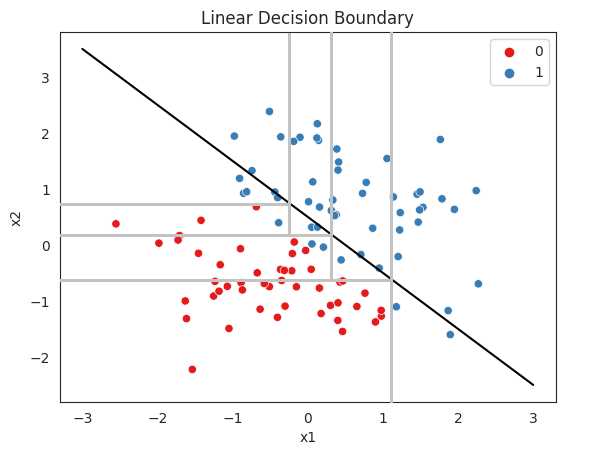

Either the complexity of the tree must increase, or one must settle with lesser performance.

While the decision tree classifier did not perform badly on this data set, the logistic regression ensemble is an improvement. We noted early on that the 432 possible base-out situations are independent and mutually exclusive. This, effectively, determined the optimal split of the feature set and left us with the task of fitting a univariate logsitic regression model to each region. The disadvantage of this method comes in applying and maintaining the models. Forturnately, 432 models is not an unreasonable number to deal with, but it is not the most elegant solution.



## 7.5 Final Thoughts

This approach to calculating WE/WPA, as an alternative to the Baseball Reference methodology, has merit. In particular, the logistic regression ensemble compares favorably to the Baseball Reference exemplars.